### 用Popularity做 OLS 模型

# 1 讀取資料

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
# 讀取 A1 與 A2 資料
high = pd.read_csv("spotify/data/high_popularity_spotify_data.csv")
low = pd.read_csv("spotify/data/low_popularity_spotify_data.csv")


df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')
df.head()

df['playlist_genre'].value_counts()
df.columns = df.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)


# 2 初步觀察

c:\Users\yuanr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


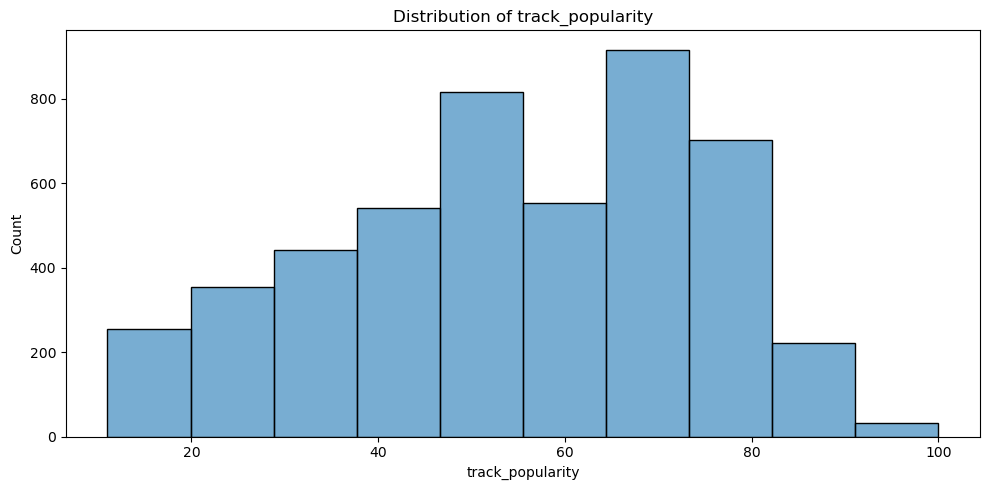

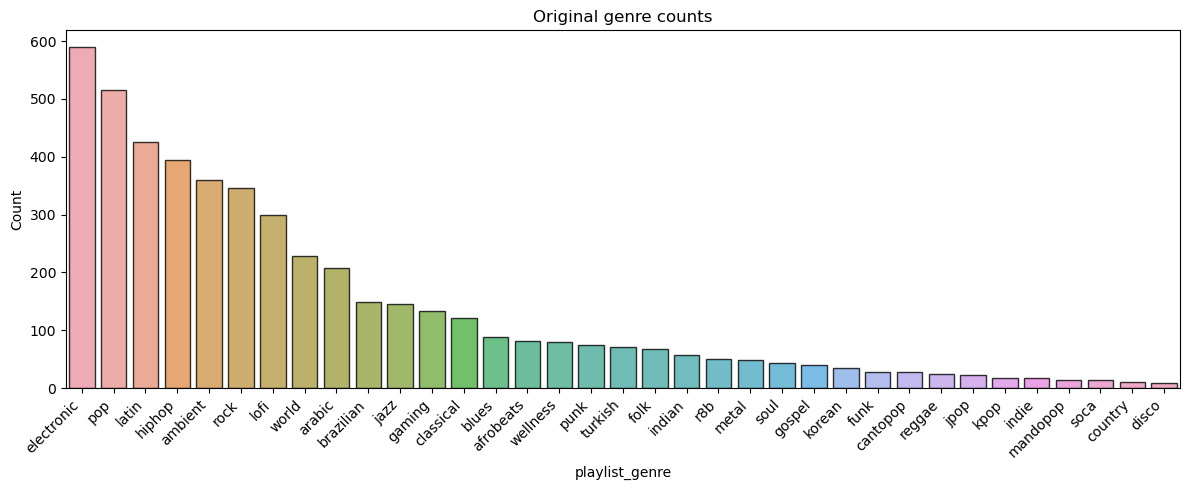

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# ── 第一欄：track_popularity 的Histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df,
    x="track_popularity",
    bins=10,          # 加大組數
    # kde=True,         # 加上密度曲線
    stat="count",
    edgecolor="black",
    alpha=0.6
)
plt.title("Distribution of track_popularity")
plt.xlabel("track_popularity")
plt.ylabel("Count")
plt.tight_layout()


# ── 第二欄：原始 playlist_genre 的次數條形圖
genre_counts = df["playlist_genre"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(
    x=genre_counts.index,
    y=genre_counts.values,
    edgecolor="black",
    alpha=0.8
)
plt.title("Original genre counts")
plt.xlabel("playlist_genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()




In [36]:
print(df['track_artist'].value_counts())

track_artist
Bad Bunny             30
Ren Avel              26
Asake                 21
Bnxn                  19
LoFi Waiter           18
                      ..
RADWIMPS, Toaka        1
結束バンド                  1
MAISONdes, 花譜, ツミキ     1
SPYAIR                 1
Sudha Ragunathan       1
Name: count, Length: 3390, dtype: int64


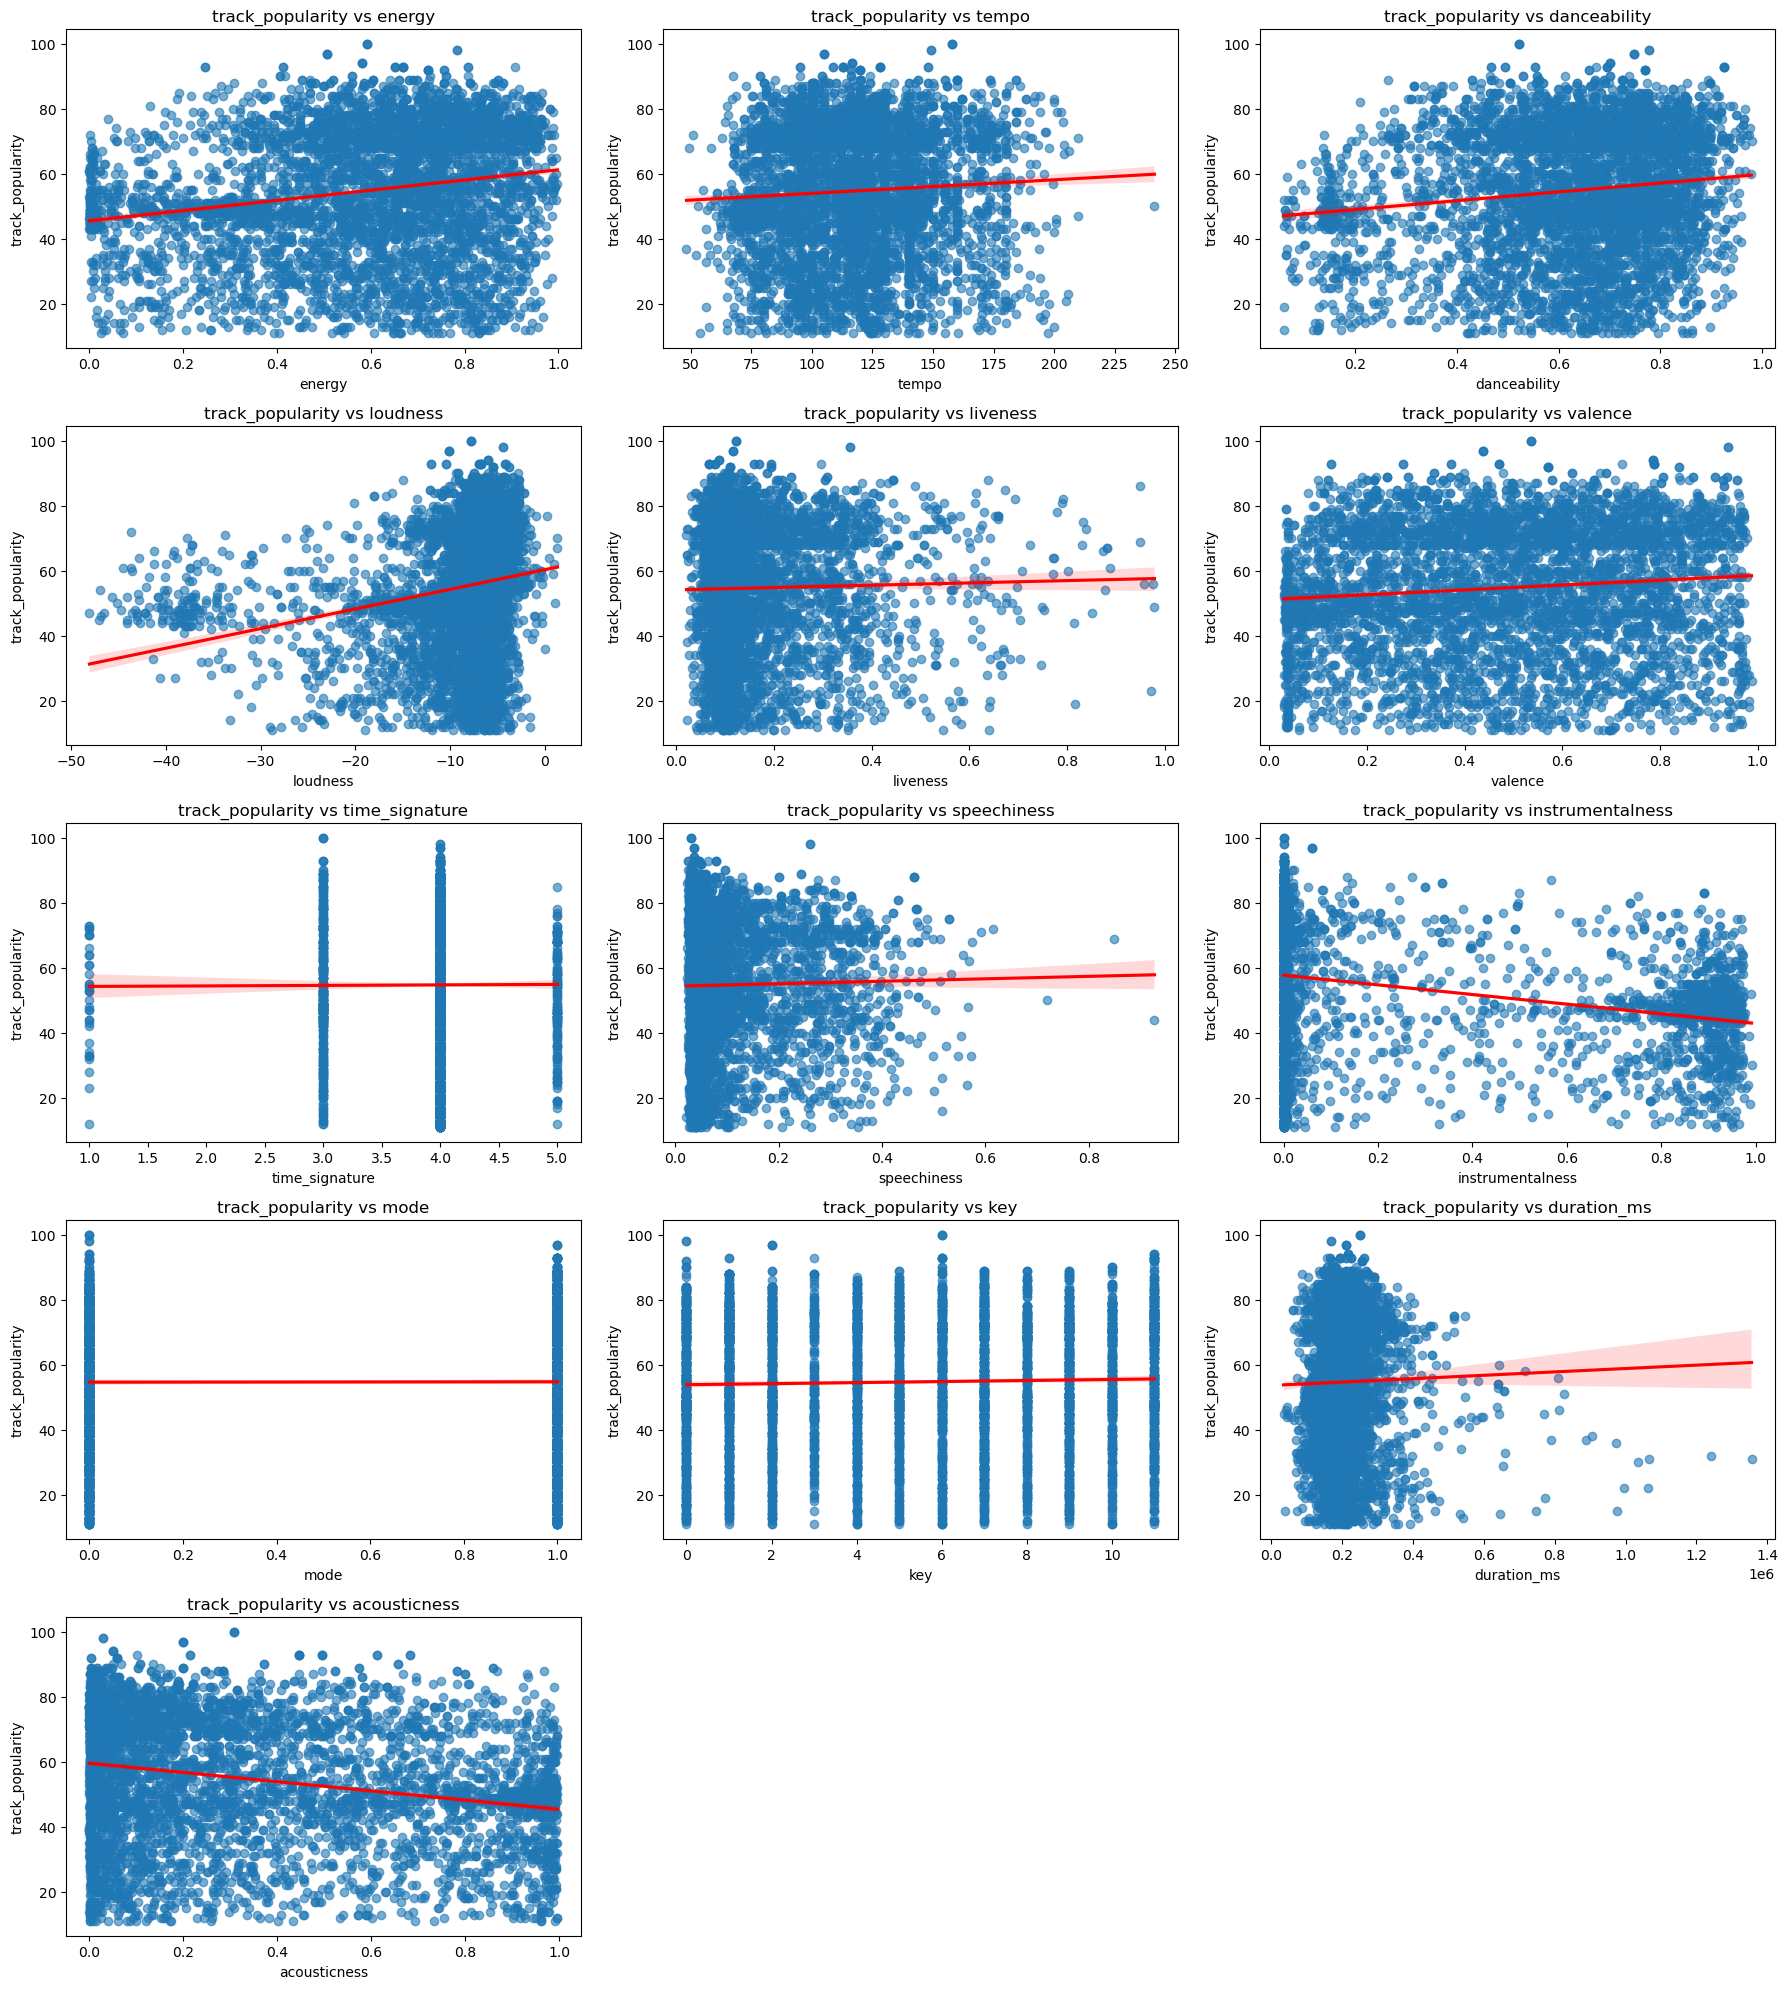

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 目標變數與自變數
response = "track_popularity"
predictors = df.select_dtypes(include="number").columns.tolist()
predictors.remove(response)

# 畫圖排版（每列最多 3 張圖）
n_cols = 3
n_rows = (len(predictors) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

for idx, var in enumerate(predictors):
    row = idx // n_cols
    col = idx % n_cols
    ax = axs[row][col] if n_rows > 1 else axs[col]

    sns.regplot(
        x=var, y=response, data=df,
        ax=ax,
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'}
    )
    ax.set_title(f"{response} vs {var}")
    ax.set_xlabel(var)
    ax.set_ylabel(response)

# 如果圖表數不是剛好填滿，把多出來的空圖清掉
total_plots = n_rows * n_cols
if total_plots > len(predictors):
    for idx in range(len(predictors), total_plots):
        fig.delaxes(axs[idx // n_cols][idx % n_cols])

plt.tight_layout()
plt.show()


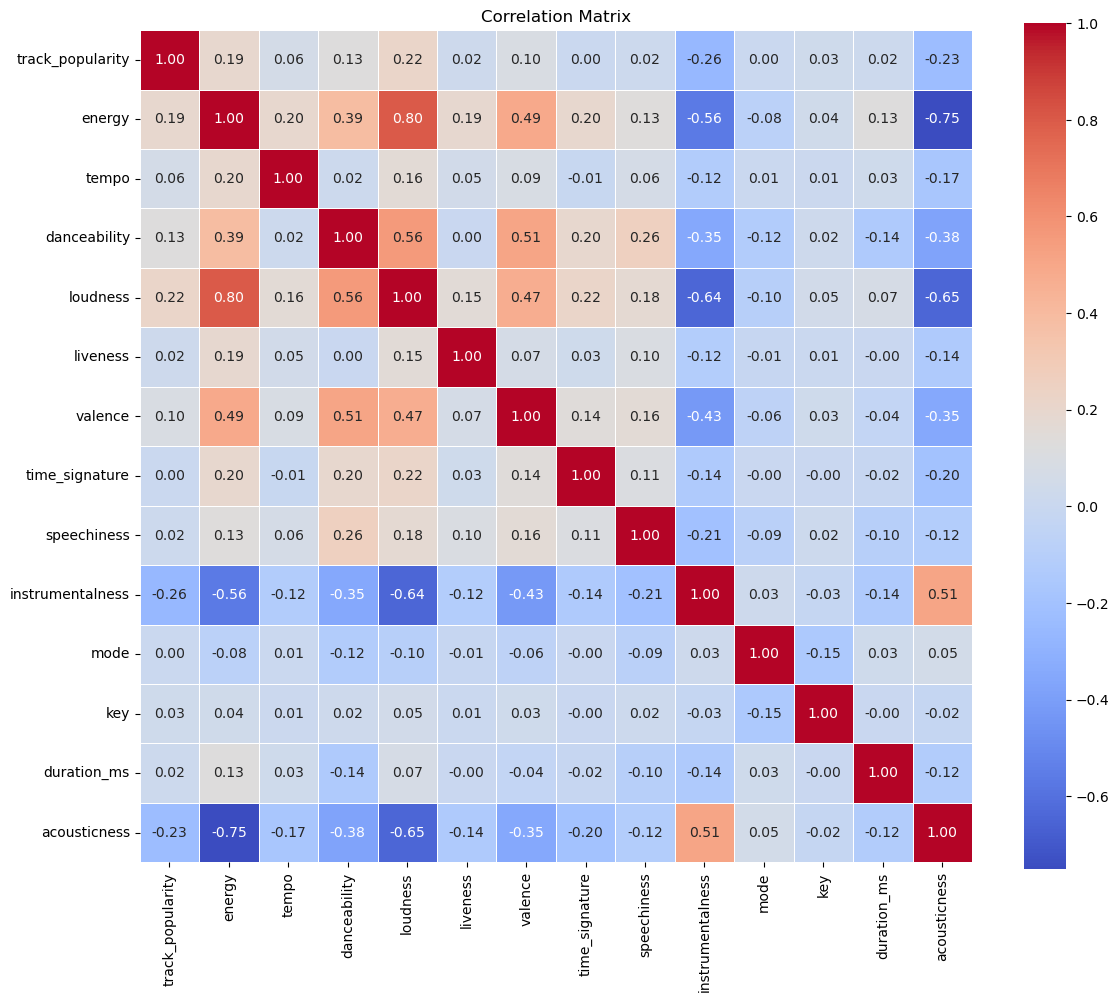

In [17]:
# 2) Correlation Matrix (係數矩陣)
# 先組成只含數值欄位的 DataFrame
corr_vars = [response] + predictors
corr = df[corr_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,      # 在每個格子顯示數值
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 3 資料前處理

### 去除唯一（曲名、UID、播放清單名）欄位

In [20]:
drop_cols = ['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)

### 合併欄位

In [13]:
# 合併 rare genres 為 "其他"
threshold = 80  # 少於 50 則視為 rare
vc = df['playlist_genre'].value_counts()
rare = vc[vc < threshold].index
df['playlist_genre'] = df['playlist_genre'].replace(rare, 'other')

### 設定虛擬變數

In [29]:
# 要轉換為 dummy 的欄位
dummy_columns = ["playlist_genre", "time_signature", "mode", "key", "playlist_subgenre", "track_artist"]

# 過濾出 df 中實際存在的欄位
available_columns = [col for col in dummy_columns if col in df.columns]

# ✅ prefix 也依照 available_columns 對齊
dummies = pd.get_dummies(df[available_columns], drop_first=True)

# 合併進原始資料（移除原類別欄位）
df_dummy = pd.concat([df.drop(columns=available_columns), dummies], axis=1)
print(df_dummy.shape)
df_dummy.head()


(4831, 3520)


energy    tempo  danceability  loudness  liveness  valence  speechiness  \
0   0.592  157.969         0.521    -7.777     0.122    0.535       0.0304   
1   0.507  104.978         0.747   -10.171     0.117    0.438       0.0358   
2   0.808  108.548         0.554    -4.169     0.159    0.372       0.0368   
3   0.910  112.966         0.670    -4.070     0.304    0.786       0.0634   
4   0.783  149.027         0.777    -4.477     0.355    0.939       0.2600   

   track_popularity  instrumentalness  duration_ms  ...  track_artist_浩宇  \
0               100            0.0000     251668.0  ...            False   
1                97            0.0608     210373.0  ...            False   
2                93            0.0000     166300.0  ...            False   
3                81            0.0000     157280.0  ...            False   
4                98            0.0000     169917.0  ...            False   

   track_artist_王赫野, 姚晓棠  track_artist_結束バンド  track_artist_艾薇  \
0                  False               False            False   
1                  False               False            False   
2                  False               False            False   
3                  False               False            False   
4                  False               False            False   

   track_artist_芒果醬 Mango Jump  track_artist_蕭秉治  track_artist_赵燮  \
0                        False             False            False   
1                        False             False            False   
2                        False             False            False   
3                        False             False            False   
4                        False             False            False   

   track_artist_邱軍  track_artist_陳華  track_artist_高爾宣 OSN, Patrick Brasca  
0            False            False                                 False  
1            False            False                                 False  
2            False            False                                 False  
3            False            False                                 False  
4            False            False                                 False  

[5 rows x 3520 columns]

In [30]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# 假設 df 是你的資料
response = 'track_popularity'

# Step 1: 異常值偵測
def detect_outliers(df, response):
    predictors = df.columns.tolist()
    predictors.remove(response)
    formula = f"{response} ~ {' + '.join(predictors)}"
    model = smf.ols(formula=formula, data=df)
    result = model.fit()
    influence = result.get_influence()
    std_resid = influence.resid_studentized_internal
    leverage = influence.hat_matrix_diag
    cooks_d = influence.cooks_distance[0]
    outlier_df = pd.DataFrame({'std_resid': std_resid, 'leverage': leverage, 'cooks_d': cooks_d})
    outlier_flags = (
        (np.abs(outlier_df['std_resid']) > 3) |
        (outlier_df['leverage'] > 3 * np.mean(leverage)) |
        (outlier_df['cooks_d'] > 4 / len(df))
    )
    outlier_index = outlier_df[outlier_flags].index
    return outlier_index

# Step 2: Forward Selection
def forward_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data=data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]

        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break
    return selected

# Step 3: Backward Elimination
def backward_elimination(data, response, threshold_out=0.05):
    predictors = list(data.columns)
    predictors.remove(response)

    while True:
        formula = "{} ~ {}".format(response, ' + '.join(predictors))
        model = smf.ols(formula, data=data).fit()
        p_values = model.pvalues.iloc[1:]  # skip intercept
        worst_pval = p_values.max()
        if worst_pval > threshold_out:
            worst_feature = p_values.idxmax()
            predictors.remove(worst_feature)
        else:
            break
    return predictors

# --- 主流程開始 ---

# (1) 移除異常值
outliers = detect_outliers(df_dummy, response)
df_clean = df_dummy.drop(index=outliers)
print(f"已移除異常值，共 {len(outliers)} 筆")

# (2) Forward 選擇變數
forward_vars = forward_selection(df_clean, response)
print("Forward 選擇的變數：", forward_vars)

# (3) Backward 刪除不顯著變數
df_forward = df_clean[[response] + forward_vars]
final_vars = backward_elimination(df_forward, response)
print("Backward 後保留的變數：", final_vars)

# (4) 最終模型
final_formula = f"{response} ~ {' + '.join(final_vars)}"
final_model = smf.ols(formula=final_formula, data=df_forward).fit()
print(final_model.summary())


PatsyError: error tokenizing input (maybe an unclosed string?)
    track_popularity ~ energy + tempo + danceability + loudness + liveness + valence + speechiness + instrumentalness + duration_ms + acousticness + time_signature + mode + key + playlist_genre_ambient + playlist_genre_arabic + playlist_genre_blues + playlist_genre_brazilian + playlist_genre_cantopop + playlist_genre_classical + playlist_genre_country + playlist_genre_disco + playlist_genre_electronic + playlist_genre_folk + playlist_genre_funk + playlist_genre_gaming + playlist_genre_gospel + playlist_genre_hiphop + playlist_genre_indian + playlist_genre_indie + playlist_genre_jazz + playlist_genre_jpop + playlist_genre_korean + playlist_genre_kpop + playlist_genre_latin + playlist_genre_lofi + playlist_genre_mandopop + playlist_genre_metal + playlist_genre_pop + playlist_genre_punk + playlist_genre_r8b + playlist_genre_reggae + playlist_genre_rock + playlist_genre_soca + playlist_genre_soul + playlist_genre_turkish + playlist_genre_wellness + playlist_genre_world + playlist_subgenre_90s + playlist_subgenre_academic + playlist_subgenre_african + playlist_subgenre_afro house + playlist_subgenre_afro-latin + playlist_subgenre_alternative + playlist_subgenre_amapiano + playlist_subgenre_american + playlist_subgenre_anime + playlist_subgenre_australian + playlist_subgenre_avant-garde + playlist_subgenre_bedroom + playlist_subgenre_bhangra + playlist_subgenre_bollywood + playlist_subgenre_cajun + playlist_subgenre_carnival + playlist_subgenre_celtic + playlist_subgenre_chill + playlist_subgenre_chinese + playlist_subgenre_choral + playlist_subgenre_cinematic + playlist_subgenre_classic + playlist_subgenre_classical + playlist_subgenre_cumbia + playlist_subgenre_death + playlist_subgenre_deep house + playlist_subgenre_delta + playlist_subgenre_desi + playlist_subgenre_drama + playlist_subgenre_drill + playlist_subgenre_essential + playlist_subgenre_experimental + playlist_subgenre_feel-good + playlist_subgenre_forró + playlist_subgenre_french + playlist_subgenre_funk + playlist_subgenre_fusion + playlist_subgenre_future + playlist_subgenre_future bass + playlist_subgenre_gangster + playlist_subgenre_global + playlist_subgenre_gqom + playlist_subgenre_grime + playlist_subgenre_hardstyle + playlist_subgenre_heavy + playlist_subgenre_hip-hop + playlist_subgenre_indie + playlist_subgenre_indigenous + playlist_subgenre_irish + playlist_subgenre_italo + playlist_subgenre_japanese + playlist_subgenre_jewish + playlist_subgenre_klezmer + playlist_subgenre_latin + playlist_subgenre_mainstream + playlist_subgenre_meditative + playlist_subgenre_melodic + playlist_subgenre_modern + playlist_subgenre_neo-classical + playlist_subgenre_nigerian + playlist_subgenre_noir + playlist_subgenre_nordic + playlist_subgenre_pop + playlist_subgenre_pop punk + playlist_subgenre_post-rock + playlist_subgenre_reggaeton + playlist_subgenre_retro + playlist_subgenre_samba + playlist_subgenre_scandi + playlist_subgenre_smooth + playlist_subgenre_soft + playlist_subgenre_soundtracks + playlist_subgenre_southern + playlist_subgenre_spanish + playlist_subgenre_tango + playlist_subgenre_techno + playlist_subgenre_throat singing + playlist_subgenre_throwback + playlist_subgenre_trap + playlist_subgenre_tropical + playlist_subgenre_vaporwave + playlist_subgenre_workout + playlist_subgenre_yoga + track_artist_$werve, TOKYOSLEEP, Mc Gw + track_artist_&friends, Nitefreak, eL-Jay, Oluwadamvic + track_artist_&friends, Samuel Cosmic, Oluwadamvic, Alex Wann + track_artist_*NSYNC + track_artist_.Eehou + track_artist_.diedlonely, énouement + track_artist_1da Banton + track_artist_21 Savage + track_artist_21 Savage, Metro Boomin + track_artist_21 Savage, Metro Boomin, Young Thug + track_artist_21 Savage, Travis Scott, Metro Boomin + track_artist_24kGoldn, iann dior + track_artist_2JtheRichest + track_artist_2Pac + track_artist_2Pac, Digital Underground + track_artist_2WEI, Joznez, Kataem + track_artist_3 Doors Down + track_artist_38 Special + track_artist_41, Kyle Richh, Jenn Carter, TaTa + track_artist_47ter + track_artist_50 Cent + track_artist_50 Cent, Olivia + track_artist_6YNTHMANE, RXDXVIL + track_artist_7038634357 + track_artist_7apes, Les Jardíns + track_artist_A & C + track_artist_A Boogie Wit da Hoodie + track_artist_A Tribe Called Quest + track_artist_A$AP Rocky + track_artist_A$AP Rocky, Imogen Heap, Clams Casino + track_artist_A$AP Rocky, Joe Fox, Kanye West + track_artist_A.K.A. Pella, Aryeh Kunstler + track_artist_A.Y. Bouzaglou + track_artist_A.Z. Louna + track_artist_ABAO阿爆 + track_artist_ABBA + track_artist_AC/DC + track_artist_AEMIA + track_artist_AFI + track_artist_AILEE + track_artist_AKA lisa + track_artist_ALI, AKLO + track_artist_ALMA + track_artist_ALMEA, Moonshine + track_artist_AMO + track_artist_ANORA, Stick Figure, Walshy Fire + track_artist_AP Dhillon + track_artist_AP Dhillon, Gminxr, Gurinder Gill, Shinda Kahlon + track_artist_AP Dhillon, Gurinder Gill, Money Musik, AR Paisley + track_artist_AUR + track_artist_AVAION + track_artist_AVAION, BUNT. + track_artist_AVAION, HÜMAN + track_artist_AXMO, DJ Junior (TW) + track_artist_AXMO, le Shuuk, LePrince + track_artist_Aaera Mio + track_artist_Aaron May + track_artist_Aaron Smith, Krono, Luvli + track_artist_Aaron Y Su Grupo Ilusion + track_artist_Aasmi Jayavant + track_artist_Aastn + track_artist_Abbey Glover + track_artist_Abby V, Ricky Kej, Benny Dayal + track_artist_Abby V, Ricky Kej, Sivaangi Krishnakumar + track_artist_Abhijit Pohankar, Ramakant Gaikwad, Samarth Desai, Amit Mishra + track_artist_Above & Beyond, PROFF + track_artist_Abril Olivera + track_artist_Ace of Base + track_artist_Across The Great Valley + track_artist_Adalione + track_artist_Adam Hawley, Marcus Anderson + track_artist_Adam Port, Stryv, Keinemusik, Orso, Malachiii + track_artist_Adam Space + track_artist_Addison Rae + track_artist_Adekunle Gold + track_artist_Adekunle Gold, Davido + track_artist_Adele + track_artist_Admira Mara + track_artist_Ado + track_artist_Adrian Eden + track_artist_Adrian Von Ziegler + track_artist_Adrianne Lenker + track_artist_Adrianwave + track_artist_Adèle Castillon, Videoclub + track_artist_Aerial Lakes + track_artist_Afro Medusa, Knee Deep + track_artist_Afro Swanky + track_artist_Afroboy + track_artist_Age Of Love, Brennan Heart, ANDY SVGE + track_artist_Ageena + track_artist_Agnes + track_artist_Ahmed Spins, Idd Aziz + track_artist_Ahmed Spins, Stevo Atambire + track_artist_Ahmet Can Dündar + track_artist_Aidin + track_artist_Aitne + track_artist_Ajebo Hustlers + track_artist_Ajebo Hustlers, Zlatan, Blaqbonez + track_artist_Akapellah + track_artist_Akkoro + track_artist_Akon, Hamsika Iyer + track_artist_Alan Tam + track_artist_Alan Walker + track_artist_Alan Walker, Ina Wroldsen + track_artist_Alana Coello + track_artist_Albertmp3, Jusjay, Zinoleesky + track_artist_Alberto Di Paulo + track_artist_Albin Johnsén, Moa Michaeli + track_artist_Albin Tingwall + track_artist_Alceu Valença + track_artist_Alek Faith + track_artist_Alembra + track_artist_Alemán + track_artist_Alemán, Gera MX + track_artist_Alesso, Tove Lo + track_artist_Alex Favela, Grupo Marca Registrada, Joaquin Medina + track_artist_Alex Gaudino, Crystal Waters + track_artist_Alex Isley, Masego, Jack Dine + track_artist_Alex Järvi + track_artist_Alex Lustig, Sølv + track_artist_Alex Wann, Route 94, Jess Glynne + track_artist_Alexander Borodin, Angelina Shvachka, Dmytro Popov, Mykola Koval, Taras Shtonda, Mykola Hobdych, Kiev Chamber Choir, Ukraine National Radio Symphony Orchestra, Theodore Kuchar + track_artist_Alexander Grandjean + track_artist_Aleyna Kalaycıoğlu + track_artist_Aleyna Tilki, Zeki Arkun + track_artist_Alfonso Peduto + track_artist_Alfredo De Angelis + track_artist_Alias Molombo, Skee + track_artist_Alice Coltrane + track_artist_Alice DiMar + track_artist_Alice In Chains + track_artist_Alice Wonder + track_artist_Alicia Keys + track_artist_Alison Hinds + track_artist_Alizzz + track_artist_Alka Yagnik, Arijit Singh + track_artist_Allen Stone + track_artist_Alma Meris + track_artist_Almir Guineto + track_artist_Alok, Bebe Rexha + track_artist_Alok, Ella Eyre, Kenny Dope, Never Dull + track_artist_Alok, Zeeba, Bruno Martini + track_artist_Alonso Lobo, Tenebrae, Nigel Short + track_artist_Alphabeat + track_artist_Altair Blake + track_artist_Amaria + track_artist_America, George Martin + track_artist_American Authors + track_artist_Ami Eller, Camp Simcha + track_artist_Amira Elfeky + track_artist_Ammy Virk + track_artist_Amon Amarth + track_artist_Amu Classic, Kappie, Djy Vino, Eemoh, Mpho Spizzy, Chronic Killer + track_artist_Amy Winehouse + track_artist_Amyl and The Sniffers + track_artist_Ana Tijoux + track_artist_Analog Bow + track_artist_Anders Schill Paulsen + track_artist_Andora + track_artist_Andra Day + track_artist_Andreas Hauschild + track_artist_Andreas Moe + track_artist_Andreas Waldetoft, Paradox Interactive + track_artist_Andreas Wijk + track_artist_Android Apartment + track_artist_Andrés Iwasaki + track_artist_Andy Lau + track_artist_Anendlessocean + track_artist_Angèle + track_artist_Angèle, Roméo Elvis + track_artist_Aniceto Molina + track_artist_Anis Flashbacks + track_artist_Ankhal, JHAYCO + track_artist_Anneline Hugo + track_artist_Antonio Ministeri + track_artist_Anuel AA + track_artist_Anuel AA, Bad Bunny + track_artist_Aphex Twin + track_artist_Aqua + track_artist_Aram Khachaturian, London Symphony Orchestra + track_artist_Arcadian + track_artist_Arch Enemy + track_artist_Arctic Monkeys + track_artist_Arcángel, Bad Bunny + track_artist_Ari Goldwag + track_artist_Ari Goldwag, Dovid Pearlman + track_artist_Ari Lennox + track_artist_Ariana Grande + track_artist_Ariana Grande, Justin Bieber + track_artist_Ariana Grande, Zedd + track_artist_Arijit Singh, Aditi Singh Sharma + track_artist_Arimasen, FORBIDDEN + track_artist_Arlindo Cruz & Sombrinha + track_artist_Arlindo Cruz, Sombrinha + track_artist_Arlos + track_artist_Armando Garzon + track_artist_Armando Mago + track_artist_Armin van Buuren, Trevor Guthrie + track_artist_Arny Margret + track_artist_AronChupa, Little Sis Nora + track_artist_ArrDee + track_artist_Art Vandeley + track_artist_Artemas + track_artist_Arvo Pärt, Mari Samuelsen, TrondheimSolistene + track_artist_Arvo Pärt, Vladimir Spivakov, Sergej Bezrodny + track_artist_Arwin + track_artist_Aryeh Kunstler + track_artist_As Galvão + track_artist_Asake + track_artist_Asake, Burna Boy + track_artist_Asake, LUDMILLA + track_artist_Asake, Stormzy + track_artist_Asake, Travis Scott + track_artist_Asake, Wizkid + track_artist_Ashanti + track_artist_Ashh + track_artist_Ashidapo, Asake + track_artist_Asian Traditional Music + track_artist_Assertive Fam + track_artist_Astred + track_artist_Astrid S + track_artist_Attic Dizzt + track_artist_Audio Armoury + track_artist_Audio Phill + track_artist_Audiomachine + track_artist_Audioslave + track_artist_Auggie Velarde + track_artist_Aurora 10 + track_artist_Aurora Dreamer + track_artist_Author S + track_artist_Avenged Sevenfold + track_artist_Aventura, Bad Bunny + track_artist_Avi Zelinger + track_artist_Avicii + track_artist_Avril Lavigne + track_artist_Avvy Sra, Karan Aujla, Jaani + track_artist_Axel Fiks + track_artist_Axwell /\ Ingrosso + track_artist_Aya Nakamura + track_artist_Aya Nakamura, Myke Towers + track_artist_Ayaz Erdoğan + track_artist_Ayaz Erdoğan, Shawty + track_artist_Ayla Nenura + track_artist_Ayo Maff + track_artist_Ayo Maff, Fireboy DML + track_artist_Ayra Starr + track_artist_Ayra Starr, Asake + track_artist_Ayra Starr, Seyi Vibez + track_artist_B Praak, Jaani + track_artist_B.W.H. + track_artist_BABYMONSTER + track_artist_BANNERS + track_artist_BESS + track_artist_BIBI + track_artist_BINYAMIN + track_artist_BLOK3 + track_artist_BLOND:ISH, Grace Tither + track_artist_BLOND:ISH, Stevie Appleton + track_artist_BOYS LIKE GIRLS + track_artist_BRADSP + track_artist_Baby Keem + track_artist_Baby Keem, Kendrick Lamar + track_artist_BabyChiefDoit + track_artist_Backstreet Boys + track_artist_Bad Bunny + track_artist_Bad Bunny, Bomba Estéreo + track_artist_Bad Bunny, Bryant Myers + track_artist_Bad Bunny, Buscabulla + track_artist_Bad Bunny, Chencho Corleone + track_artist_Bad Bunny, Don Omar + track_artist_Bad Bunny, Feid + track_artist_Bad Bunny, JHAYCO + track_artist_Bad Bunny, Jowell & Randy, Ñengo Flow + track_artist_Bad Bunny, Luar La L + track_artist_Bad Bunny, Mora + track_artist_Bad Bunny, Prince Royce, J Balvin, Mambo Kingz, DJ Luian + track_artist_Bad Bunny, ROSALÍA + track_artist_Bad Bunny, Sech + track_artist_Bad Bunny, Tainy + track_artist_Bad Bunny, The Marías + track_artist_Bad Bunny, Tony Dize + track_artist_Bad Bunny, Yaviah + track_artist_Bad Bunny, Young Miko + track_artist_Bad Bunny, Zion & Lennox + track_artist_Bad Milk + track_artist_Badflower + track_artist_Badshah, Diljit Dosanjh, Aastha Gill + track_artist_Bakar + track_artist_Baker Boy, JessB + track_artist_Bakermat + track_artist_Balloranking + track_artist_Balloranking, Seyi Vibez + track_artist_Balloranking, Shallipopi + track_artist_Baltimora + track_artist_Balu Brigada + track_artist_Banks, AC, Dryden + track_artist_BarbWalters + track_artist_Barbatuques + track_artist_Barrington Levy + track_artist_Baruch Levine + track_artist_Baruch Naftel, Caudio + track_artist_Bashy, GRM Daily + track_artist_Basswell, So Juice + track_artist_Beach Weather + track_artist_Beachwax + track_artist_Beastie Boys + track_artist_Beats Me, Innit? + track_artist_Beats by Tobÿ, Tobÿ + track_artist_Beck + track_artist_Becky G, Bad Bunny + track_artist_Becky G, KAROL G + track_artist_Bee DeeJay, Rhass, Mshayi, Mr Thela + track_artist_Bee Gees + track_artist_Beka O + track_artist_Bekar + track_artist_Belinda, Kenia OS + track_artist_Bella Shmurda + track_artist_Bella Shmurda, Tiwa Savage + track_artist_Ben Böhmer, Lykke Li + track_artist_Ben Böhmer, lau.ra + track_artist_Ben Crosland + track_artist_Ben E. King + track_artist_Ben Jammin' Beats + track_artist_Ben Laver + track_artist_Beneath The Mountain + track_artist_Bengü + track_artist_Benjamin + track_artist_Benjamin Drewitz + track_artist_Benjamin Gustafsson + track_artist_Benjin Blund + track_artist_Benny Goodman + track_artist_Benson Boone + track_artist_Benzz + track_artist_Beret + track_artist_Beret, Pablo Alborán + track_artist_Berhanio + track_artist_Bernadete França + track_artist_Beyoncé + track_artist_Beyoncé, JAY-Z + track_artist_Beyond + track_artist_Beéle + track_artist_BhadBoi OML + track_artist_Bibi Babydoll, Dj Brunin XM, KZA Produções + track_artist_Bicho de Pé + track_artist_Bicho de Pé, Janayna Pereira + track_artist_Big Bolaji + track_artist_Big Joe Williams + track_artist_Big Narstie, Sir Spyro + track_artist_Big Pun, Fat Joe + track_artist_Big Pun, Joe + track_artist_Big Soto, Neutro Shorty, De La Ghetto, Noriel + track_artist_Big Thief + track_artist_Big Zuu, D7, Crafty 893, Drifter + track_artist_BigXthaPlug + track_artist_Bigflo & Oli + track_artist_Bigflo & Oli, Fabian Ordonez + track_artist_Bigflo & Oli, Julien Doré + track_artist_Bilal Sonses, Merve Özbey + track_artist_Billie Eilish + track_artist_Billie Eilish, Khalid + track_artist_Billy Idol + track_artist_Billy Joel + track_artist_Billy Ocean + track_artist_Bingo Players, Far East Movement + track_artist_Bingo Players, Pure Shores + track_artist_Biola Yakubu + track_artist_Biosphere + track_artist_Bizarrap, Quevedo + track_artist_Black Eyed Peas + track_artist_Black M + track_artist_Black Sherif + track_artist_Blackberry Smoke + track_artist_Blackmagic + track_artist_Blacko SA, Mellow & Sleazy, Scotts Maphuma + track_artist_Blackstreet, Dr. Dre, Queen Pen + track_artist_Blaggards + track_artist_Blank x Blank + track_artist_Blaqbonez + track_artist_Blaqbonez, Jeriq + track_artist_Blaqbonez, M24 + track_artist_Blaqbonez, ODUMODUBLVCK + track_artist_Blaqbonez, Projexx + track_artist_Blaqbonez, Young Jonn + track_artist_Blaqbonez, Zlatan + track_artist_Bleachers + track_artist_Blessd, Anuel AA + track_artist_Blessing Lopez + track_artist_Blind Melon + track_artist_Blind Willie McTell + track_artist_Bloc Party + track_artist_Blondie + track_artist_Bloodlust, Holy Priest + track_artist_Blue Öyster Cult + track_artist_Blur + track_artist_Bnxn + track_artist_Bnxn, 2Baba + track_artist_Bnxn, Headie One + track_artist_Bnxn, Kizz Daniel, Seyi Vibez + track_artist_Bnxn, Olamide + track_artist_Bnxn, Popcaan + track_artist_Bnxn, Rema + track_artist_Bnxn, Wizkid + track_artist_Bnxn, taves + track_artist_Bob Marley & The Wailers + track_artist_Bob Marley & The Wailers, LVNDSCAPE, Bolier + track_artist_Bobby Helms + track_artist_Bobby, I Miss You + track_artist_Bogomolove, Senn + track_artist_Boj + track_artist_Boj, Ajebutter22 + track_artist_Boj, Gyakie + track_artist_Boj, Knucks, Tay Iwar + track_artist_Boj, ODUMODUBLVCK + track_artist_Bon Iver + track_artist_Bon Iver, St. Vincent + track_artist_Bon Jovi + track_artist_Bone Thugs-N-Harmony + track_artist_Boney James + track_artist_Boney James, October London + track_artist_Booba + track_artist_Boogey the Beat, Young Spirit, Drezus, Pj Vegas + track_artist_Boris Salchow + track_artist_Borrtex + track_artist_Bow Wow, Omarion + track_artist_Bowling For Soup + track_artist_Boyz II Men + track_artist_Brain + track_artist_Brambles + track_artist_Brandon Fiechter + track_artist_Brandy, Monica + track_artist_Brazeros Musical De Durango + track_artist_Breakfast For Brunch + track_artist_Brenda Lee + track_artist_Brendan Angelides, Assassin's Creed, Layth Sidiq + track_artist_Brendan Mills, Surfin' Sam + track_artist_Brennan Heart, Timmy Trumpet, Blademasterz + track_artist_Brent Faiyaz + track_artist_Brent Faiyaz, FELIX!, Tommy Richman + track_artist_Brian Culbertson + track_artist_Brian Keane, Omar Faruk Tekbilek + track_artist_Brian Simpson, Peter White + track_artist_Brian Tyler, Assassin's Creed + track_artist_Brian Tyler, Transformers + track_artist_Bright Lens + track_artist_Bring Me The Horizon + track_artist_Britney Spears + track_artist_Broken Colours + track_artist_Brray, JHAYCO, Ryan Castro + track_artist_Bruce Springsteen + track_artist_Bruno Mars + track_artist_Bryan Adams + track_artist_Bryant Myers, Bad Bunny + track_artist_Bryson Tiller + track_artist_Brytiago + track_artist_Buckwheat Zydeco + track_artist_Buffalo Springfield + track_artist_Bullet For My Valentine + track_artist_Bunji Garlin + track_artist_Burak Bulut + track_artist_Burak Bulut, Kurtuluş Kuş + track_artist_Burgundy Skies + track_artist_Burna Boy + track_artist_Burna Boy, Byron Messia + track_artist_Burna Boy, Dave + track_artist_Burna Boy, J. Cole + track_artist_Burna Boy, Wizkid + track_artist_Bus Topp + track_artist_Butterscotch + track_artist_Byron Juane, Kenyon Dixon + track_artist_C. Tangana + track_artist_C. Tangana, Ed Maverick + track_artist_C. Tangana, Paloma Mami + track_artist_C. Tangana, Toquinho + track_artist_C418 + track_artist_C4C, Plusma + track_artist_CHANCE デラソウル + track_artist_CHANYEOL, Punch + track_artist_CHEN, BAEKHYUN, XIUMIN + track_artist_CHEN, Punch + track_artist_CKay, Focalistic, Davido, Abidoza + track_artist_CKay, Joeboy, Kuami Eugene + track_artist_CKay, Olamide + track_artist_CRi + track_artist_CURSEDEVIL, DJ FKU, Skorde + track_artist_CYRIL + track_artist_CYRIL, Kita Alexander + track_artist_Caamp + track_artist_Cafe Accordion Orchestra + track_artist_Café Tacvba + track_artist_Cage The Elephant + track_artist_Caifanes + track_artist_Caiiro, AWEN, Adam Port + track_artist_Cairo CPT + track_artist_Cairo CPT, Don Vino + track_artist_Cairo CPT, Minollar + track_artist_Cairo CPT, Xola Sofuthe + track_artist_Caius + track_artist_Cal Credence + track_artist_Calil + track_artist_Calle 13 + track_artist_Calle 13, Totó La Momposina, Susana Baca, Maria Rita + track_artist_Calle 24, Chuyin + track_artist_Calmative + track_artist_Calogero, Passi + track_artist_Calum Scott + track_artist_Calvin Harris + track_artist_Calvin Harris, Alesso, Hurts + track_artist_Calvin Harris, Ellie Goulding + track_artist_Calvin Harris, John Newman + track_artist_Calvin Harris, Rihanna + track_artist_Camden Clown + track_artist_Camila + track_artist_Camille Saint-Saëns, Yo-Yo Ma, Kathryn Stott + track_artist_Candlebox + track_artist_Canserbero + track_artist_Cap Kendricks + track_artist_Carbonne + track_artist_Carin Leon, Gabito Ballesteros + track_artist_Carl Borg + track_artist_Carlos Di Sarli + track_artist_Carly Rae Jepsen + track_artist_Carwyn + track_artist_Casco + track_artist_Casero + track_artist_Casiamty + track_artist_Castorum + track_artist_Catching Flies + track_artist_Caterina Barbieri, Kara-Lis Coverdale + track_artist_Cavetown, Frankie Cosmos + track_artist_Cazzu, Brray, Luar La L, Ankhal + track_artist_Cazzu, Lyanno, Rauw Alejandro, Dalex + track_artist_Celestial Aura + track_artist_Celestial Echoes + track_artist_Central Cee + track_artist_Central Cee, JRK 19 + track_artist_Central Cee, Lil Baby + track_artist_Chaka Demus & Pliers + track_artist_Chama Chuva + track_artist_Chance Peña + track_artist_Chappell Roan + track_artist_Charles Trenet + track_artist_Charley Patton + track_artist_Charli xcx + track_artist_Charli xcx, Billie Eilish + track_artist_Charlie Ryder + track_artist_Chase & Status, Stormzy + track_artist_Chase Holfelder + track_artist_Chasing Storms + track_artist_Cher + track_artist_Cheryl Frances-Hoad, Owain Park, The Gesualdo Six + track_artist_Chezile + track_artist_Chief Keef + track_artist_Chike, Mohbad + track_artist_Childish Gambino + track_artist_Chill Def, alt.bin.beats + track_artist_Chill Vif + track_artist_Chilled Cougar + track_artist_Chilled Cougar, LoFi Waiter + track_artist_Chino Pacas + track_artist_Chip, Frisco, K-Trap, Krept + track_artist_Choclock + track_artist_Chris Ardoin + track_artist_Chris Brown + track_artist_Chris Brown, Davido, Lojay + track_artist_Chris Holsten + track_artist_Chris Standring + track_artist_Christian Löffler, Henry Green + track_artist_Christian Löffler, Mogli + track_artist_Christina Perri + track_artist_Christophe + track_artist_Christopher + track_artist_Christopher Galovan + track_artist_Christopher Lennertz + track_artist_Cigarettes After Sex + track_artist_Circulando De Fulo + track_artist_Citizen Deep, Nia Pearl, Bontle Smith + track_artist_Claire Rosinkranz + track_artist_Clairo + track_artist_Clams Casino, Imogen Heap + track_artist_Clara Klingenström + track_artist_Clarent, Mora + track_artist_Claude Debussy, Alice Sara Ott + track_artist_Claude François + track_artist_Clave Especial, Luis R Conriquez + track_artist_Clean Bandit, Jess Glynne + track_artist_Clean Bandit, Sean Paul, Anne-Marie + track_artist_Cleo Sol + track_artist_Clifton Chenier + track_artist_Cmd q + track_artist_Coldplay + track_artist_Coleman Hawkins + track_artist_Collinsworthy + track_artist_Color Tango + track_artist_Colter Wall + track_artist_Colter Wall, Tyler Childers + track_artist_Coltsfoot + track_artist_Comet Blue + track_artist_Cometta + track_artist_ConKi, Magnus Gunn + track_artist_Conan Gray + track_artist_Conjure kid + track_artist_Connie Isla + track_artist_Convivial + track_artist_Cordae, Lil Wayne + track_artist_Corona + track_artist_Cosmic Nuit + track_artist_Counting Tides + track_artist_Crayon + track_artist_Crayon, Ayra Starr + track_artist_Creedence Clearwater Revival + track_artist_Creeds + track_artist_Creepy Nuts + track_artist_Cris Mj + track_artist_Cris Mj, FloyyMenor, LOUKI + track_artist_Crumb + track_artist_Crush + track_artist_Crying Day Care Choir + track_artist_Crystal Castles + track_artist_Cthulhu Ramón + track_artist_Cupido + track_artist_Cyan_95 + track_artist_Cyndi Lauper + track_artist_Cypress Hill + track_artist_Cyrillus Kreek, Traditional, Anna-Liisa Eller, Angela Ambrosini, Marco Ambrosini, Vox Clamantis, Jaan-Eik Tulve + track_artist_Céline Dion + track_artist_Céline Dion, Peabo Bryson + track_artist_César Franck, Joshua Bell, Jeremy Denk + track_artist_D Double E, Sir Spyro + track_artist_D-Block Europe + track_artist_DAM + track_artist_DAVICHI + track_artist_DENNIS, MC Kevin o Chris + track_artist_DEVA + track_artist_DEX 1200 + track_artist_DIAMØND SNAKE + track_artist_DIOR 大穎 + track_artist_DIVINE + track_artist_DIVINE, Karan Aujla + track_artist_DJ AG O GRINGO + track_artist_DJ Dollynho Da Lapa, MC LEON, MC Pânico + track_artist_DJ Fluke, Nikita Afonso + track_artist_DJ GLK, MC LIPEX, Dj luis do grau + track_artist_DJ Guih Da ZO, Mc Delux + track_artist_DJ JOÃO PEREIRA, MC Koringa + track_artist_DJ Jeeh FDC, MC LCKaiique, MC Celo BK, DJ Menezes, DJ Arana, Mc Yoshi + track_artist_DJ Kawest, Joé Dwèt Filé + track_artist_DJ Khaled, Lil Baby, Lil Durk + track_artist_DJ Kraz + track_artist_DJ Kraz, Aryeh Kunstler + track_artist_DJ Kraz, Isaac Ben + track_artist_DJ Kraz, Sholom + track_artist_DJ Leo Cris, Dr. Victor + track_artist_DJ Luian, Mambo Kingz, Anuel AA, Nicky Jam, Darell, Brytiago + track_artist_DJ MESQUITA DE NV + track_artist_DJ NK3 + track_artist_DJ NpcSize, Mc Larissa + track_artist_DJ RAMON SP + track_artist_DJ Seinfeld + track_artist_DJ Shub + track_artist_DJ Snake, Bipolar Sunshine + track_artist_DJ Snake, Justin Bieber + track_artist_DJ TENEBROSO ORIGINAL, Mc Danflin + track_artist_DJ TOPO, Seu Jorge, Mc Leozin, MC G15 + track_artist_DJ Tunez, Terry Apala + track_artist_DJ Tunez, Wizkid, Seyi Vibez, Terry Apala + track_artist_DJ VM 22 + track_artist_DJ Zigão, DJ Lafon Do Md, Mc Rodrigo do CN, Mc Rf + track_artist_DKD Dancers, DASH, K.Clevenger + track_artist_DOPE LEMON + track_artist_DORA + track_artist_DUCAT + track_artist_Da Tweekaz + track_artist_Da Tweekaz, Used, LePrince + track_artist_Daddy Yankee, NATTI NATASHA, Becky G + track_artist_Daddy Yankee, Snow + track_artist_Dadju, Tayc + track_artist_Daft Punk + track_artist_Daft Punk, Julian Casablancas + track_artist_Daft Punk, Pharrell Williams, Nile Rodgers + track_artist_Dai Verse + track_artist_Daisy Jones & The Six + track_artist_Dalex, Lenny Tavárez, Anitta, NATTI NATASHA, Farruko, Justin Quiles + track_artist_Dalex, Lenny Tavárez, Chencho Corleone, Juhn, Dímelo Flow + track_artist_Damian Marley + track_artist_Damn Homies + track_artist_Damso + track_artist_Dan + Shay, Justin Bieber + track_artist_Dan García, Sergio Mayer Mori + track_artist_Dan Whitlam + track_artist_Daniel Caesar + track_artist_Daniel Caesar, H.E.R. + track_artist_Daniel Schulz + track_artist_Danny Ocean + track_artist_Danny Ocean, Kapo + track_artist_Danny Palgon + track_artist_Danny Palgon, K3LZ + track_artist_Danny Palgon, Yoni Z + track_artist_Danny Saucedo, Mapei + track_artist_Danzig + track_artist_Daprinski + track_artist_Darell + track_artist_Darell, Brytiago + track_artist_Darin + track_artist_Darkoo, Rema + track_artist_Darmian Coté + track_artist_Darren Styles, TNT, Technoboy, Tuneboy + track_artist_Dasunny + track_artist_Dave + track_artist_Dave Brubeck + track_artist_Dave Koz, Brian Culbertson + track_artist_Dave Tarras + track_artist_Dave, Burna Boy + track_artist_Dave, Central Cee + track_artist_Dave, Stormzy + track_artist_David Benoit + track_artist_David Bowie + track_artist_David Guetta, AFROJACK, Bebe Rexha, Nicki Minaj + track_artist_David Guetta, Alesso, Madison Love + track_artist_David Guetta, Alphaville, Ava Max + track_artist_David Guetta, Bebe Rexha + track_artist_David Guetta, Flo Rida, Nicki Minaj + track_artist_David Guetta, Ne-Yo, Akon + track_artist_David Guetta, Sia + track_artist_David Kushner + track_artist_Davido + track_artist_Davido, FAVE + track_artist_Davido, Focalistic + track_artist_Davido, Logos olori + track_artist_Davido, Morravey + track_artist_Davido, Musa Keys + track_artist_Davido, Skepta + track_artist_Davido, The Cavemen., Angelique Kidjo + track_artist_Davido, YG Marley + track_artist_Dayne S + track_artist_De La Ghetto, Luar La L, YOVNGCHIMI + track_artist_De La Ghetto, Yandel, Ñengo Flow, Daddy Yankee + track_artist_De Mthuda, Kabza De Small, Young Stunna, Mkeyz, McKenzie, Mthunzi + track_artist_DeScribe + track_artist_Dead Poet Society + track_artist_Dean Lewis + track_artist_Dear Gravity + track_artist_Dear Gravity, Music Within + track_artist_Decadance, Italoconnection + track_artist_Deep Chills, Brendan Mills + track_artist_Deep Vibrations + track_artist_Deepend, Madism + track_artist_Def Leppard + track_artist_Deftones + track_artist_Dele GT + track_artist_Dele GT, LAVIERY + track_artist_Delorme & Co + track_artist_Denilson, WMC + track_artist_Dennis Brown + track_artist_Dennis Ferrer, Jack Back, David Guetta + track_artist_Depeche Mode + track_artist_Derya Uluğ + track_artist_Desireless + track_artist_Destiny's Child + track_artist_Dexter and The Moonrocks + track_artist_Dhanda Nyoliwala + track_artist_Dhanura + track_artist_Dhira Gill, Aman Hayer, Saab Pangota + track_artist_Diam's + track_artist_Diddy, 112, Faith Evans + track_artist_Dido + track_artist_Diego Oliveira + track_artist_DigDat + track_artist_Dijon + track_artist_Dilpreet Dhillon, Sultaan, Desi Crew + track_artist_Dimitri Vegas & Like Mike + track_artist_Dimitri Vegas & Like Mike, Loic D, Ronald-V + track_artist_Dimitri Vegas & Like Mike, Tiësto, Dido, W&W, Dimitri Vegas, Like Mike + track_artist_Dimitri Vegas, Steve Aoki, Ann Lee, Sound Of Legend + track_artist_Dinamarca + track_artist_Dino P + track_artist_Dinos + track_artist_Diplo, Trippie Redd + track_artist_Dirty Heads + track_artist_Disclosure, Eliza Doolittle, Flume + track_artist_Disclosure, Eliza Doolittle, Rivo + track_artist_Disclosure, Sam Smith + track_artist_Disturbed + track_artist_Dizzy Boy + track_artist_Dj 4kerty, Bella Shmurda + track_artist_Dj Bountyhunter, Dimitri Vegas, Junkie Kid + track_artist_Dj Jhonatan Perú + track_artist_Dj LK da Escócia, Tchakabum, MC Ryan SP, mc jhenny, Mc RF + track_artist_Dj Samir, Rodricci, Launch13 + track_artist_Djo + track_artist_Dmitry V. Silantyev + track_artist_Doechii + track_artist_Dois Dobrado + track_artist_Doja Cat + track_artist_Dolly Parton + track_artist_Dominic Fike + track_artist_Dominic Fike, Weezer + track_artist_Dominum Nominum + track_artist_Don Henley + track_artist_Don McLean + track_artist_Don Omar, Tego Calderón + track_artist_Don Patricio + track_artist_Don Toliver + track_artist_Don Toliver, Travis Scott + track_artist_Doode, Teto, Matuê + track_artist_Dope Caesar, FAVE, Ajebo Hustlers + track_artist_Dotter + track_artist_Dovid Lowy + track_artist_Dovid Pearlman, Ari Goldwag + track_artist_Dovid Pearlman, C. Neuhaus + track_artist_Dozy Duzzn + track_artist_Doğu Swag + track_artist_Dpsht + track_artist_Dpsht, tenkousei. + track_artist_Dr. Dre + track_artist_Dr. Dre, Snoop Dogg + track_artist_Dr. Peacock + track_artist_Dr. Yaro + track_artist_Drake + track_artist_Drake, 21 Savage + track_artist_Drake, J. Cole + track_artist_Drake, Lil Baby + track_artist_Drake, Tems + track_artist_Drake, Yeat + track_artist_Drake, Young Thug, 21 Savage + track_artist_Dread Mar I + track_artist_Dream Theater + track_artist_Dreamlifter + track_artist_Drishti + track_artist_Dropkick Murphys + track_artist_Drumetic Boyz + track_artist_Drxnk, Myríad, Golden Ticket Tapes + track_artist_Dua Lipa + track_artist_Dual Damage + track_artist_Duke & Jones, Flowdan + track_artist_Duki, Headie One + track_artist_Duki, Myke Towers + track_artist_Duki, Wiz Khalifa, Arcángel + track_artist_Duki, YSY A + track_artist_Duncan Laurence + track_artist_Dunsin Oyekan, Lawrence Oyor + track_artist_Duran Duran + track_artist_Dusty Kadinsky + track_artist_Duvie Shapiro + track_artist_Dwayne Ford + track_artist_Dyan Dxddy + track_artist_Dylan Sitts + track_artist_Dynoro, Gigi D'Agostino + track_artist_E.S. Posthumus + track_artist_EBOLOKO, DRE-A + track_artist_ECLIPSE + track_artist_ED. + track_artist_EDIS + track_artist_ELEWAKA + track_artist_EMMY + track_artist_ENRA + track_artist_Eagles + track_artist_Earium + track_artist_Earl Hondo + track_artist_Earl Klugh + track_artist_Earth, Wind & Fire + track_artist_Earth, Wind & Fire, The Emotions + track_artist_Eben + track_artist_Ebru Yaşar, Burak Bulut, Kurtuluş Kuş + track_artist_Ebru Yaşar, Siyam, Zeyd + track_artist_Ebuka Songs + track_artist_Ece Mumay + track_artist_Echoes of Embers + track_artist_Ed Sheeran + track_artist_Eda Sakız, Siyam + track_artist_Eden Elf, Ren Avel + track_artist_Eden Shalev + track_artist_Edvard Grieg, Alexandra Dariescu, Philharmonia Orchestra, Tianyi Lu + track_artist_Edward Elgar, VOCES8 + track_artist_Egyptian Meditation Temple + track_artist_El Búho, Quantic + track_artist_Eladio Carrion + track_artist_Eladio Carrion, Arcángel, De La Ghetto + track_artist_Eladio Carrion, Bad Bunny + track_artist_Eladio Carrion, Beny Jr + track_artist_Eladio Carrion, Future + track_artist_Eladio Carrion, J Balvin, Daddy Yankee, Bobby Shmurda + track_artist_Eladio Carrion, Morad + track_artist_Elba Ramalho + track_artist_Elba Ramalho, Dominguinhos + track_artist_Eleanor Daley, The Chapel Choir of Pembroke College, Cambridge, The Pembroke College Girls’ Choir, Anna Lapwood + track_artist_Electra + track_artist_Electric Light Orchestra + track_artist_Eleonora Feldt + track_artist_Elevation Worship, Chris Brown + track_artist_Elh Kmer, So La Lune + track_artist_Eli & Fur + track_artist_Eli Skies, Dovid Gross + track_artist_Eli Skies, Shmuel Zimmer + track_artist_Elias Kaskinen + track_artist_Elijah Edwards + track_artist_Elina + track_artist_Ella Fitzgerald, Louis Armstrong + track_artist_Ella Henderson, Rudimental + track_artist_Elm Lake + track_artist_Elmiene + track_artist_Elsa & Emilie + track_artist_Elton John + track_artist_Elton John, Dua Lipa, PNAU + track_artist_Elton John, Kiki Dee + track_artist_Elvio Martín + track_artist_Elviras + track_artist_Emilia + track_artist_Emilia Pantic, Rasmus Wahlgren + track_artist_Eminem + track_artist_Eminem, Dido + track_artist_Eminem, Juice WRLD + track_artist_Eminem, Lil Wayne + track_artist_Eminem, Rihanna + track_artist_Emma Steinbakken + track_artist_EmmaOMG, The OhEmGee Choir, Pelumi Deborah, BBO + track_artist_Emmelie de Forest + track_artist_Emmylou Harris, Alison Krauss, Gillian Welch + track_artist_Eneko Artola + track_artist_Energy + track_artist_Engelwood + track_artist_Enma + track_artist_Ensemble Kineya + track_artist_Enya + track_artist_Epic North, Peter Roe + track_artist_Epic Score + track_artist_Epik High, LeeHi + track_artist_Eric Benét, Tamar Braxton + track_artist_Eric Chou + track_artist_Eric Prydz + track_artist_Eric Saade + track_artist_Eric Whitacre, Eric Whitacre Singers + track_artist_Erik Hassle + track_artist_Erik Satie, Alena Cherny + track_artist_Erphaan Alves + track_artist_Erwin Do, Lenny B + track_artist_Erwin Do, flâneur, Beto Braga, Raouf + track_artist_Esbjörn Svensson Trio + track_artist_Escix V + track_artist_Eternalistic + track_artist_Eternxlkz + track_artist_Euan Dalgarno + track_artist_Euge Groove + track_artist_Eugenio Esquivel, Dele GT, Los Esquivel, Sebastian Esquivel + track_artist_Euggy, Suraj, Mumba Yachi + track_artist_Europe + track_artist_Eurythmics, Annie Lennox, Dave Stewart + track_artist_Evanescence + track_artist_Eve + track_artist_Evelina, ANI + track_artist_Evgeny Grinko + track_artist_Evol December, Duccbod + track_artist_Evolutionists + track_artist_Ezhel + track_artist_Ezra Collective, Jme, Swindle + track_artist_Ezra Collective, Yazmin Lacey + track_artist_FISHER, Kita Alexander + track_artist_FL + track_artist_FLORIAN + track_artist_FOLA, Bnxn + track_artist_Fabrizio Paterlini + track_artist_Falamansa + track_artist_Fall Out Boy + track_artist_Falz, Flavour, ODUMODUBLVCK + track_artist_Fantasia + track_artist_Faolan + track_artist_Farruko + track_artist_Farruko, Anuel AA, Kendo Kaponi + track_artist_Farruko, White Star, J. Cross + track_artist_Favé + track_artist_Faye Webster + track_artist_Feet down Below + track_artist_Feid, ATL Jacob + track_artist_Feid, J Balvin, Maluma, Nicky Jam, Sech, Justin Quiles + track_artist_Feid, Rema + track_artist_Feid, Young Miko + track_artist_Felicia Takman + track_artist_Felix Harrer, Jerome + track_artist_Felix Jaehn, Jasmine Thompson + track_artist_Felix Rovitto + track_artist_Felo Le Tee, Scotts Maphuma, Thabza Tee, DJ Maphorisa, Djy Biza + track_artist_Feranbanks, Zinoleesky + track_artist_FiNE, Lizwi, Enoo Napa + track_artist_Fido + track_artist_Fido, Tiwa Savage + track_artist_Filipe Ret, Dallass, Hunter + track_artist_Finger Eleven + track_artist_Fireboy DML + track_artist_Fireboy DML, Jon Batiste + track_artist_Fireboy DML, Lagbaja + track_artist_Fireboy DML, Lojay + track_artist_Fireboy DML, Seun Kuti + track_artist_First Aid Kit + track_artist_Fito Olivares + track_artist_Fito Olivares y Su Grupo + track_artist_Flammy + track_artist_Flavio, daniel sabater + track_artist_Fleetwood Mac + track_artist_Flo Rida + track_artist_Flo Rida, David Guetta + track_artist_Flo Rida, Sia + track_artist_FloFilz, HNNY + track_artist_Flogging Molly + track_artist_Florence + The Machine + track_artist_Florence Beatrice Price, Jeneba Kanneh-Mason, Chineke! Orchestra, Leslie Suganandarajah + track_artist_Florindo Sassone Y Su Orquesta + track_artist_FloyyMenor + track_artist_FloyyMenor, Cris Mj + track_artist_FloyyMenor, Lewis Somes + track_artist_FloyyMenor, Ozuna, Anitta + track_artist_Flyndon + track_artist_Fontaines D.C. + track_artist_Foo Fighters + track_artist_Forest Blakk + track_artist_Forro In The Dark + track_artist_Forro In The Dark, Bebel Gilberto + track_artist_Forro In The Dark, Daivd Byrne + track_artist_Forroçacana + track_artist_Forró Bemtivi + track_artist_Fountains Of Wayne + track_artist_Francis Cabrel + track_artist_Francis Mercier, Kiesza + track_artist_Francisco Canaro, Orquesta Francisco Canaro + track_artist_Francisco Canaro, Roberto Maida + track_artist_Frank Ocean + track_artist_Frank Sinatra, Count Basie + track_artist_Frank Yates + track_artist_FrankJavCee + track_artist_Frankie Valli & The Four Seasons + track_artist_Franky Wah, Rae Morris + track_artist_Frans Bak, Mari Samuelsen, Hakon Samuelsen, Keld Haaning Ibsen, TrondheimSolistene + track_artist_Franz Ferdinand + track_artist_Franz Liszt, Lang Lang + track_artist_Franz Liszt, Lise de la Salle + track_artist_Franz Schubert, Wiener Philharmoniker, Josef Krips + track_artist_Françoise Hardy + track_artist_Freak Slug + track_artist_Fred again.., Duskus, Four Tet, Joy Anonymous, Skrillex + track_artist_Fred again.., Obongjayar + track_artist_Fredo, Defkhan, Rollen, Aysemen + track_artist_Frida Sundemo + track_artist_From Somewhere Quiet + track_artist_Frontliner, The Prophet + track_artist_Fryderyk HD, Lilibet + track_artist_Frédéric Chopin, Mikhail Pletnev + track_artist_Fréro Delavega + track_artist_Fuerza Regida + track_artist_Fuerza Regida, Luis R Conriquez + track_artist_Fumez The Engineer, OTP, BM, BM X MINI + track_artist_Furry Beats + track_artist_Future + track_artist_Future, Drake, Tems + track_artist_Future, Juice WRLD + track_artist_Future, Lil Uzi Vert + track_artist_Future, Metro Boomin, Kendrick Lamar + track_artist_Future, Metro Boomin, Travis Scott, Playboi Carti + track_artist_Fya Playce + track_artist_G DUBS + track_artist_G:sson + track_artist_GA + track_artist_GBM Nutron + track_artist_GIMS + track_artist_GIMS, DYSTINCT + track_artist_GIMS, Lossa + track_artist_GISHIN, AmanderSings + track_artist_GULEED + track_artist_Gabito Ballesteros, Natanael Cano, Luis R Conriquez, Neton Vega + track_artist_Gabriel Fauré, Berliner Philharmoniker, Daniel Barenboim + track_artist_Gabriel Morais Jr, Ayla Nova + track_artist_Gabriela Richardson + track_artist_Gabry Ponte, LUM!X, Prezioso + track_artist_Gabry Ponte, Sean Paul, NATTI NATASHA + track_artist_Gad Feureisen + track_artist_Gal Costa + track_artist_Gala, Molella, Phil Jay + track_artist_Galactica Pivot + track_artist_Galantis + track_artist_Galt MacDermot + track_artist_Galva-Nice + track_artist_Ganesh & Kumaresh + track_artist_Gang Starr + track_artist_Ganlas + track_artist_Gazo, Tiakola + track_artist_Gene Ammons + track_artist_George Benson + track_artist_George Claymon + track_artist_George Frideric Handel, Alexander Briger, Academy of St. Martin in the Fields + track_artist_George Frideric Handel, Trevor Pinnock, The English Concert, Simon Preston, The Choir Of Westminster Abbey + track_artist_George Ian Hewitt + track_artist_George Knight + track_artist_George Strait + track_artist_Georges Bizet, Michel Plasson, Orchestre National Du Capitole De Toulouse + track_artist_Georges Brassens + track_artist_Georgia Vesper + track_artist_Gepe + track_artist_Geraldo Azevedo + track_artist_Gerard Marino + track_artist_Gerda Holmes + track_artist_Ghetts, Skepta + track_artist_Ghostnaut, Lunath + track_artist_Gianni Romano, Emanuele Esposito, Helen Tesfazghi + track_artist_Gibran Alcocer + track_artist_Giggs, Lojay + track_artist_Gigi Perez + track_artist_Gilberto Gil + track_artist_Gioachino Rossini, Arthur Fiedler, Boston Pops Orchestra + track_artist_Gisele De Santi + track_artist_Gittiye + track_artist_Giuliano Poles + track_artist_Giveon + track_artist_Glimlip, Louk, Elior + track_artist_Glitter Party + track_artist_GloRilla, Sexyy Red + track_artist_Glory Oath + Blood, Robert Leslie Bennett + track_artist_Godspeed You! Black Emperor + track_artist_Goldmax, Dlala Thukzin, Funky Qla, Zee Nxumalo, Beast Rsa + track_artist_Good Charlotte + track_artist_Good Kid + track_artist_Goodnight, Texas + track_artist_Gooee + track_artist_Gordo, Drake + track_artist_Gorillaz + track_artist_Gorillaz, Tame Impala, Bootie Brown + track_artist_Gotye, FISHER, Chris Lake, Kimbra, Sante Sansone + track_artist_Gotye, Kimbra + track_artist_Goya Menor, Nektunez + track_artist_Grace Belly + track_artist_Grace Lokwa, Moses Bliss, Prinx Emmanuel + track_artist_Gracie Abrams + track_artist_Gradur + track_artist_Grand Corps Malade, Camille Lellouche + track_artist_Grand Corps Malade, Louane + track_artist_Grandi + track_artist_Gravagerz + track_artist_Greatman Takit + track_artist_Green Day + track_artist_Green Montana, SDM + track_artist_Greg Edmonson + track_artist_Gregg Karukas + track_artist_Gregory Alan Isakov + track_artist_Gregory Tan, Atom Music Audio + track_artist_Gretch'N + track_artist_Gretchen Wilson + track_artist_Grimm Jack + track_artist_Grupo Frontera + track_artist_Grupo Frontera, Bad Bunny + track_artist_Grupo Fundo De Quintal + track_artist_Grupo Mojado + track_artist_Guentaê! + track_artist_Guidolain beats, brass.beats + track_artist_Gummy + track_artist_Gunna + track_artist_Gunna, Roddy Ricch + track_artist_Gunnhild Sundli, Ski-VM Trondheim 2025 + track_artist_Guns N' Roses + track_artist_Guru Josh Project, Klaas + track_artist_Gus Viseur + track_artist_Gustav Mahler, Daniel Barenboim, Chicago Symphony Orchestra + track_artist_Gustavo Santaolalla + track_artist_Guy2Bezbar + track_artist_Guy2Bezbar, JEY BROWNIE, Josman + track_artist_Guzimi + track_artist_Gym Class Heroes, Adam Levine + track_artist_Gökçe Kırgız Taner + track_artist_Gülşen + track_artist_H I K E + track_artist_H.E.R., Bryson Tiller + track_artist_HAECHAN + track_artist_HEIZE, Han Suji + track_artist_HM Surf, sove + track_artist_HON + track_artist_HOUDI + track_artist_HOYO-MiX + track_artist_HPY DAYZ + track_artist_HUGEL, Diplo, Malou, Yuna + track_artist_HUGEL, GROSSOMODDO + track_artist_HUGEL, Topic, Arash, Daecolm + track_artist_HUGEL, Totó La Momposina + track_artist_HUMBE + track_artist_HYBS + track_artist_Hadise + track_artist_Halo, Sean Callery, Colin Stetson + track_artist_Halsey + track_artist_Hammocks & Lime + track_artist_Hamza + track_artist_Hande Yener + track_artist_Hande Ünsal + track_artist_Hania Rani + track_artist_Hank Locklin + track_artist_Hanna Ferm + track_artist_Hanna Ferm, Junie + track_artist_Hanna Haïs, KingDonna + track_artist_Hannah Laing, RoRo + track_artist_Hanne Mjøen + track_artist_Hans Hu$tle + track_artist_Hans Hu$tle, KOMOREBI + track_artist_Hans Zimmer + track_artist_Hanumankind, Kalmi + track_artist_Hanz, emawk + track_artist_Hardwell, Outsiders + track_artist_Harry Gregson-Williams + track_artist_Harry Styles + track_artist_Have a Cigar + track_artist_Headhunterz + track_artist_Headie One, AJ Tracey, Stormzy + track_artist_Headie One, Drake + track_artist_Heal Divisions + track_artist_Heart + track_artist_Hector Gachan + track_artist_Hedda Mae + track_artist_Heiko Streicher, Stefan Heinz + track_artist_Heno + track_artist_Henri Salvador + track_artist_Henrik + track_artist_Henrik Lindstrand + track_artist_Her's + track_artist_Hermeto Pascoal + track_artist_Heroes Del Silencio + track_artist_Hershel, iZZy D JaY + track_artist_Hi Hat Henry + track_artist_Hideo Osaka Ensemble + track_artist_Hikaru Utada + track_artist_Hildá Länsman, Tuomas Norvio + track_artist_Hiromitsu Agatsuma, Chen Min, Akira Senju + track_artist_Hisohkah, WMD + track_artist_Hobes, NEIMY + track_artist_Hoffy Beats, Tonion, Louk + track_artist_Holo + track_artist_Holy Jamie + track_artist_Hombres G + track_artist_Home + track_artist_Hoobastank + track_artist_Horace Silver + track_artist_Hoshi + track_artist_Hossam Ramzy, Phil Thornton + track_artist_Hotkeed, Yo X + track_artist_House of Protection + track_artist_Hozier + track_artist_Hrothgar Tarek + track_artist_Huma + track_artist_Humble Francis + track_artist_Hurricane on Saturn + track_artist_Hurricane on Saturn, Deuce + track_artist_Hyce, BoyPee, Brown Joel + track_artist_Hydawai, CMC$, Benji (UK) + track_artist_Härlanda Chamber Choir, David Molin + track_artist_ILLENIUM, Annika Wells + track_artist_IShowSpeed + track_artist_IVE, David Guetta + track_artist_IZZY MEOCK + track_artist_Ibquake + track_artist_Ice Cube + track_artist_Ice Cube, Das EFX + track_artist_Ice Prince, J-Milla, Yung L + track_artist_Ichiss + track_artist_Icon + track_artist_Icona Pop + track_artist_Icona Pop, Charli xcx + track_artist_Idealism + track_artist_Idris Kelly + track_artist_Ilan Eshkeri + track_artist_Ilker James, Ayaz Erdoğan + track_artist_Illum Noyz + track_artist_Imagine Dragons + track_artist_Imanbek, BYOR + track_artist_Immanu El + track_artist_Impuls + track_artist_Ina Wroldsen + track_artist_Indian Wells + track_artist_Indila + track_artist_Inhaler + track_artist_Innocent Panda + track_artist_Inon Zur + track_artist_Internet Money, Gunna, Don Toliver, NAV + track_artist_Invadable Harmony + track_artist_Inventor Ace + track_artist_Irene Cara + track_artist_Iron Maiden + track_artist_Irshad Khan + track_artist_Isac Elliot + track_artist_Isak Danielson + track_artist_Ishay Ribo + track_artist_ItsArius, Lynnic, Dinia + track_artist_Itzik Orlev + track_artist_Iván Torrent, Julie Elven + track_artist_Iyaz + track_artist_J Balvin + track_artist_J Balvin, Bad Bunny + track_artist_J Balvin, Bad Bunny, Marciano Cantero + track_artist_J Balvin, Bad Bunny, Mr Eazi + track_artist_J Balvin, Farruko + track_artist_J Balvin, Feid + track_artist_J Balvin, Mr Eazi + track_artist_J Balvin, Sech + track_artist_J Balvin, Sky Rompiendo + track_artist_J Balvin, Zion & Lennox + track_artist_J Capri, Charly Black + track_artist_J Hus, Drake + track_artist_J. Cartwright + track_artist_J. Cole + track_artist_JACKBOYS, Pop Smoke, Travis Scott + track_artist_JAE5, NSG + track_artist_JAY-Z + track_artist_JAY-Z, Mr Hudson + track_artist_JAY-Z, UGK + track_artist_JENNIE + track_artist_JID, 21 Savage, Baby Tate + track_artist_JP Saxe, Julia Michaels + track_artist_Ja Rule, Ashanti + track_artist_Jabs CPT, Sangzin + track_artist_Jack Harlow + track_artist_Jack White + track_artist_Jackiem Joyner + track_artist_Jackson Do Pandeiro + track_artist_Jacky Cheung + track_artist_Jacob Reddy + track_artist_Jacqline + track_artist_Jacques Offenbach, Arthur Fiedler, Boston Pops Orchestra + track_artist_Jaguares + track_artist_Jain, Ian Asher + track_artist_Jakob Ahlbom + track_artist_Jakob Ahlbom, Anna Dager, Hanna Ekström + track_artist_Jakob Ahlbom, Hanna Ekström, Anna Dager + track_artist_Jalen Ngonda + track_artist_James Arthur + track_artist_James Blunt + track_artist_James Heather + track_artist_James Hype, Miggy Dela Rosa + track_artist_James Mac, Vall, Rosalie + track_artist_Jan Garlow + track_artist_Japanese Taiko Drums + track_artist_Jarabe De Palo + track_artist_Jasiel Nuñez, Peso Pluma + track_artist_Jasleen Royal, B Praak, Romy, Anvita Dutt + track_artist_Jasmine Sandlas, Garry Sandhu, Tanishk Bagchi, Intense + track_artist_Jasmine Viola + track_artist_Jason Morrigan + track_artist_Jason Mraz + track_artist_Javed-Mohsin, Darshan Raval + track_artist_Jax Jones, Calum Scott + track_artist_Jax Jones, MNEK + track_artist_Jax Jones, Zoe Wees + track_artist_Jay Sean, Lil Wayne + track_artist_Jay Statham + track_artist_Jay Wheeler, Myke Towers, Rauw Alejandro, DJ Nelson, JHAYCO, Lunay, Kendo Kaponi + track_artist_JayO + track_artist_Jayanthi Kumaresh + track_artist_Jaykae + track_artist_Jazim Sharma, Kumar Sharma, Kathak Rockers + track_artist_Jazzy James + track_artist_Jean Ferrat + track_artist_Jennifer Lopez, Pitbull + track_artist_Jens Kleist, JASMIN, Da Bartali Crew + track_artist_Jeremy Soule + track_artist_Jeremy Soule, Daniil Trifonov + track_artist_Jerry Di + track_artist_Jerry Ropero, HUGEL, Mijangos, Jesús Fernández + track_artist_Jeryko + track_artist_Jesper Jenset + track_artist_Jesper Jenset, vinni + track_artist_Jesper Kyd, Assassin's Creed + track_artist_Jess Sharon + track_artist_Jesus Image + track_artist_Jesús Alejandro El Niño + track_artist_Jet + track_artist_Jewel Usain + track_artist_Jewel Usain, Béesau, Hedges + track_artist_Jhené Aiko, Kendrick Lamar + track_artist_Jhené Aiko, Swae Lee + track_artist_Jikuru, Lola + track_artist_Jim Croce + track_artist_Jimi Hendrix + track_artist_Jimin + track_artist_Jimin, HA SUNG WOON + track_artist_Jimmy Cliff + track_artist_Jimmy Eat World + track_artist_Jin + track_artist_Jme, Giggs + track_artist_Jmss, PØPE + track_artist_Joan Jett & the Blackhearts + track_artist_Joaquín Rodrigo, Thibaut García, Ben Glassberg, Orchestre National Du Capitole De Toulouse + track_artist_Joe + track_artist_Joeboy, Bnxn, ODUMODUBLVCK + track_artist_Joep Beving + track_artist_Joey Bada$$ + track_artist_Joey Newcomb + track_artist_Johan Söderqvist, Mari Samuelsen, TrondheimSolistene + track_artist_Johann Sebastian Bach, Lang Lang + track_artist_Johannes Baumer, Distant Cowboy + track_artist_John Coltrane + track_artist_John Denver + track_artist_John Grout + track_artist_John Legend + track_artist_John Lundvik + track_artist_John Mellencamp + track_artist_John Paesano + track_artist_John Paesano, Ben Billions + track_artist_John Robert Matz + track_artist_John Skyfield, BNHM, Levka Rey + track_artist_Johnny Cash + track_artist_Johnny Drille + track_artist_Johnny Drille, Don Jazzy + track_artist_Joji Hirota Taiko Drummers + track_artist_Jomega + track_artist_Jon Hassell + track_artist_Jonas Blue, Dakota + track_artist_Jonas Blue, JP Cooper + track_artist_Jonas Sandberg + track_artist_Jonas Wall, Umbaji + track_artist_Jonathan Butler, Boney James + track_artist_Jonathan Dove, The Choir of Magdalen College, Oxford, Edward Byrne, Mark Williams + track_artist_Jordan Rakei, STUTS + track_artist_Jordan Sandhu, Mehar Vaani, Desi Crew + track_artist_Jordiz + track_artist_Josa + track_artist_Joseff Shields + track_artist_Josh Leake + track_artist_Josman + track_artist_Jost Esser, SOFLUX + track_artist_Jost Esser, Sleeping Dove, very noise person + track_artist_Journey + track_artist_Jovaan, KEVVO, Ñengo Flow, Brray, YOVNGCHIMI, Jon Z + track_artist_Jowell & Randy, J Balvin + track_artist_Joyce Santana, Feid + track_artist_Juanes + track_artist_Juanes, Nelly Furtado + track_artist_Jubin Nautiyal, Emraan Hashmi + track_artist_Judas Priest + track_artist_Juice WRLD + track_artist_Juice WRLD, Marshmello + track_artist_Jul + track_artist_Jul, DYSTINCT + track_artist_Jul, SDM + track_artist_Julia Alvarez + track_artist_Julia Lov + track_artist_Julia Michaels + track_artist_Juliander + track_artist_Julie Bergan + track_artist_Juliette + track_artist_Julión Álvarez y su Norteño Banda + track_artist_Juls + track_artist_Juls, Victony + track_artist_Jung Kook + track_artist_Jung Seung Hwan + track_artist_Jungeli, Imen Es, Alonzo, Abou Debeing, Lossa + track_artist_Jungle + track_artist_Junior H + track_artist_Justin Bieber + track_artist_Justin Bieber, Ludacris + track_artist_Justin Burnett + track_artist_Justin Quiles, Eladio Carrion + track_artist_Justin Quiles, NATTI NATASHA, Farruko, Lenny Tavárez, Dalex, Zion + track_artist_Justin Timberlake + track_artist_Justin Timberlake, Timbaland + track_artist_Jóhann Jóhannsson + track_artist_Jónsi, Georg Holm, Kjartan Sveinsson, Orri Pall Dyrason, VOCES8, Thomas Gould, Emma Denton, Sam Becker + track_artist_Jósean Log + track_artist_K-Ci & JoJo + track_artist_K.S Makhan, Manpreet Hans, Laddi Gill + track_artist_K.Will + track_artist_K3LZ, Avi Abikhzer + track_artist_K3LZ, Eli Levin + track_artist_K3LZ, Eli Levin, MOiSHE'LE + track_artist_KAESTYLE, Omah Lay + track_artist_KAROL G + track_artist_KAROL G, Feid, DFZM, Ovy On The Drums, J Balvin, Maluma, Ryan Castro, Blessd + track_artist_KAROL G, Maldy + track_artist_KAROL G, Mariah Angeliq + track_artist_KAROL G, Peso Pluma + track_artist_KATSEYE + track_artist_KEVIN ROLDAN, Bryant Myers, Lyanno + track_artist_KHEA, Omar Varela, Asan + track_artist_KHEMIS, BNHM, Levka Rey + track_artist_KR$NA + track_artist_KR$NA, Mukesh, Shankar Jaikishan + track_artist_KUUMAA + track_artist_Kabza De Small, Vigro Deep, DJ Maphorisa, Scotts Maphuma, Young Stunna + track_artist_Kainbeats + track_artist_Kaio Viana, MC CJ + track_artist_Kali Uchis + track_artist_Kanari Music + track_artist_Kanisan, lost echoes + track_artist_Kansas + track_artist_Kanye West + track_artist_Kanye West, Chris Martin + track_artist_Kanye West, Dwele + track_artist_Kanye West, Rick Ross + track_artist_Kapo + track_artist_Karan Aujla + track_artist_Karan Aujla, Mxrci + track_artist_Karl Jenkins, Carmine Lauri, David Alberman, London Symphony Orchestra + track_artist_Karl Jenkins, Mike Ratledge, Adiemus, Jody K. Jenkins, London Philharmonic Orchestra, Mary Carewe + track_artist_Kasimir + track_artist_Kaskade, Lauren L'aimant + track_artist_KaspaHauser + track_artist_Kate Bollinger + track_artist_Kathleen Regan + track_artist_Katrina & The Waves + track_artist_Katy Perry + track_artist_Kavinsky + track_artist_KayBlack, Wall Hein, AMUSIK + track_artist_KeBlack, SDM + track_artist_Keane + track_artist_Kehlani, Ty Dolla $ign + track_artist_Keith Frank, The Soileau Zydeco Band + track_artist_Kelis, Alex Wann + track_artist_Kendji Girac + track_artist_Kendrick Lamar + track_artist_Kenneth C M Young + track_artist_Kenneth Leighton, David Cuthbert, The Choir of The Queen's College Oxford, Owen Rees, Britten Sinfonia + track_artist_Kenny Dorham + track_artist_Kenny G + track_artist_Kenny Rogers + track_artist_Kenshi Yonezu + track_artist_Kenya Grace + track_artist_Kerensa Briggs, Anna Lapwood, The Chapel Choir of Pembroke College, Cambridge + track_artist_Kerim Araz + track_artist_Kerim Araz, Sevgim Yılmaz + track_artist_Kes + track_artist_Kes, Nailah Blackman + track_artist_Kesha + track_artist_Kevin Riepl, Jason Graves + track_artist_Key Glock + track_artist_Key Largo + track_artist_Key Largo, LEDG + track_artist_Khan Bhaini + track_artist_Ki!, Al Agami + track_artist_KiDi, Black Sherif + track_artist_Kid AlpHa + track_artist_Kiddie Gang + track_artist_Killloane + track_artist_Kim Cesarion + track_artist_Kimberley Tell + track_artist_Kimmø, Kid Tarô, Shuko + track_artist_Kina, Adriana Proenza + track_artist_Kina, Snøw + track_artist_King + track_artist_King Chango + track_artist_King Gnu + track_artist_King Von + track_artist_Kings of Leon + track_artist_Kirk Whalum + track_artist_Kizz Daniel + track_artist_Kizz Daniel, Adekunle Gold + track_artist_Kizz Daniel, Tekno + track_artist_Kizz Daniel, Thyself + track_artist_Klockrent! + track_artist_Knowmadic + track_artist_Kodak Black + track_artist_Kodak Black, XXXTENTACION + track_artist_Kodo + track_artist_Kofs, Soso Maness, Elams, Jul, SCH, Naps, Solda, Houari, 13 Organisé + track_artist_Koino Yokan + track_artist_Kora + track_artist_Korala Maan, Youngstarr Pop Boy + track_artist_Koralle + track_artist_Korn + track_artist_KoruSe, mzmff + track_artist_KoruSe, stellar + track_artist_KoruSe, stellar, Arimasen + track_artist_Koshun Nakao + track_artist_Kouek + track_artist_Kouyou + track_artist_Kris Kross + track_artist_Kroma + track_artist_Kronan, Nyaruach, Bakermat + track_artist_Krosfyah + track_artist_Kudasaibeats, Biskwiq + track_artist_Kulwinder Kaily, Gurlez Akhtar + track_artist_Kuma + track_artist_Kungs, Cookin' On 3 Burners + track_artist_Kupla + track_artist_Kuroki + track_artist_Kuroki, Lemage + track_artist_Kuroki, Yume.Play + track_artist_Kurtuluş Kuş + track_artist_Kurtuluş Kuş, Burak Bulut + track_artist_Kygo, Ava Max + track_artist_Kygo, Conrad Sewell + track_artist_Kygo, Sandro Cavazza + track_artist_Kygo, Zak Abel, Nile Rodgers + track_artist_Kyle Preston + track_artist_Kylie Minogue + track_artist_L.Dre + track_artist_L1NA + track_artist_LADIPOE, Bnxn + track_artist_LADIPOE, Chocobantis + track_artist_LADIPOE, Rozzz, Morrelo + track_artist_LANE + track_artist_LATIN MAFIA + track_artist_LAUWE, Marcus Layton + track_artist_LAVINIA, Ely Oaks + track_artist_LIAMOO + track_artist_LISA + track_artist_LISA, ROSALÍA + track_artist_LMFAO, Lauren Bennett, GoonRock + track_artist_LNY TNZ, Lil Jon + track_artist_LORD CHAOS!, NTPV + track_artist_LVTA + track_artist_LXNGVX + track_artist_LZee + track_artist_La Chanchona De Tito Mira + track_artist_La Fuente, Outsiders + track_artist_La Fève + track_artist_La Sonora Dinamita, Alvaro Pava + track_artist_Laddi Chahal, Parmish Verma, Gurlez Akhtar + track_artist_Ladji Mouflet + track_artist_Lady Gaga + track_artist_Lady Gaga, Bruno Mars + track_artist_Lady Gaga, Colby O'Donis + track_artist_Lakwister, Aweko Brian, Moses rallo + track_artist_Lamar Azul, Mindscape + track_artist_Lamii + track_artist_Lana Del Rey + track_artist_Lana Del Rey, Bleachers + track_artist_Lana Del Rey, Cedric Gervais + track_artist_Lancelot, Clara Klingenström + track_artist_Lane 8 + track_artist_Larry Gaaga, Patoranking, ODUMODUBLVCK + track_artist_Lars-Luis Linek + track_artist_Lary Over, Anuel, Bryant Myers, Almighty, Brytiago + track_artist_Latché Swing + track_artist_Latehours + track_artist_Latto + track_artist_Lauren Daigle + track_artist_Laurent Emmmerling + track_artist_Lavern + track_artist_Lavinium + track_artist_Lazlow + track_artist_Lazza, Lil Baby + track_artist_Le U, Akim Beats + track_artist_Le Youth, Jerro, Lizzy Land + track_artist_Lead Belly + track_artist_League of Legends, NewJeans + track_artist_Lectric Workers + track_artist_Led Zeppelin + track_artist_Lee Young Ji, D.O. + track_artist_LeeHi + track_artist_Leith Ross + track_artist_Lemage + track_artist_Lenni Kim + track_artist_Lenny Kravitz + track_artist_Leo Motta, Toti Cisneros + track_artist_Leon Bridges + track_artist_Leon Thomas, Baby Rose + track_artist_Leona Lewis + track_artist_Lewis Capaldi + track_artist_Leya Watson + track_artist_LiSA + track_artist_Liana Flores + track_artist_Libby Flores + track_artist_Libianca + track_artist_Lights & Motion + track_artist_Lil Baby + track_artist_Lil Baby, 42 Dugg + track_artist_Lil Baby, Drake + track_artist_Lil Baby, Gunna + track_artist_Lil Baby, Gunna, Lil Uzi Vert + track_artist_Lil Durk + track_artist_Lil Durk, J. Cole + track_artist_Lil Durk, Lil Baby, Polo G + track_artist_Lil Durk, Morgan Wallen + track_artist_Lil Durk, Only The Family + track_artist_Lil Frosh, Zinoleesky + track_artist_Lil Kesh + track_artist_Lil Kesh, Young Jonn + track_artist_Lil Loaded + track_artist_Lil Peep, Lil Tracy + track_artist_Lil Peep, XXXTENTACION + track_artist_Lil Skies + track_artist_Lil Tecca + track_artist_Lil Tecca, Don Toliver + track_artist_Lil Tecca, Juice WRLD + track_artist_Lil Texas + track_artist_Lil Tjay + track_artist_Lil Tjay, Offset, Moneybagg Yo + track_artist_Lil Uzi Vert + track_artist_Lil Uzi Vert, sped up nightcore, ARIZONATEARS + track_artist_Lil Wayne, Bruno Mars + track_artist_Lil Yachty + track_artist_Lil Yachty, Veeze + track_artist_Lil' Bob & the Lollipops + track_artist_Lilly Ahlberg + track_artist_Lime Cordiale + track_artist_Lime Nyorobon + track_artist_Linda Sundblad + track_artist_Linkin Park + track_artist_Lionel Richie + track_artist_Lit + track_artist_Litany + track_artist_Living Room, ØNEMOR3 + track_artist_Lizzy McAlpine + track_artist_Lloyd, Lil Wayne + track_artist_LoFi Waiter + track_artist_Loco, Punch + track_artist_Lofive + track_artist_Lojay, Olamide + track_artist_Lojay, Sarz + track_artist_Lola, Bluewerks + track_artist_Lomepal + track_artist_Lomepal, Roméo Elvis + track_artist_Loomington + track_artist_Loop Schrauber + track_artist_Looper Boy + track_artist_Lord Huron + track_artist_Lorde + track_artist_Loreen + track_artist_Los Aldeanos + track_artist_Los Cafres + track_artist_Los Enanitos Verdes + track_artist_Los Francos + track_artist_Los Hermanos Flores + track_artist_Los Miticos Del Ritmo, Quantic + track_artist_Los Pericos, Carla Morrison + track_artist_Los Pericos, The Original Wailers + track_artist_Los Poboycitos + track_artist_Los Tigrillos + track_artist_Los Ángeles Azules + track_artist_Los Ángeles Azules, Natalia Lafourcade + track_artist_Lost Frequencies + track_artist_Lost Frequencies, Calum Scott + track_artist_Lost Frequencies, Tom Odell + track_artist_Lotus Beats, Notation + track_artist_Lotus Vega + track_artist_Lou Bega + track_artist_Lou Reed + track_artist_Louie's Tapes, Lemon Kids + track_artist_Louis The Child, Caroline Ailin + track_artist_Louise Attaque + track_artist_Luca + track_artist_Luca Magliano + track_artist_Lucas Estrada, Couché, Polar Notes, Mentum + track_artist_Lucas Estrada, Deepend, Dan Caplen + track_artist_Lucas Estrada, NEIMY + track_artist_Lucas Estrada, TWOPILOTS + track_artist_Lucas Estrada, TWOPILOTS, Brendan Mills + track_artist_Lucas Felix, Mestrinho + track_artist_Lucho Bermúdez + track_artist_Lucky Daye + track_artist_Lucía Fernanda, Rocco S + track_artist_Ludovico Einaudi + track_artist_Ludovico Einaudi, Daniel Hope, I Virtuosi Italiani + track_artist_Ludwig van Beethoven, Igor Levit + track_artist_Ludwig van Beethoven, Paul Lewis + track_artist_Luedji Luna, Maz + track_artist_Luh Tyler, BossMan Dlow + track_artist_Luidji + track_artist_Luigi Boccherini, Orpheus Chamber Orchestra + track_artist_Luis R Conriquez, Joel De La P, Chimbala + track_artist_Luiz Carlos Da Vila + track_artist_Luiz Gonzaga + track_artist_Luiz Gonzaga, Gal Costa + track_artist_Luka Vida + track_artist_Lukas Graham + track_artist_Luke Combs + track_artist_Luke Howard + track_artist_Luna Novina + track_artist_Lunar Lullaby & yorukaze + track_artist_Lunatic + track_artist_Lunay, Daddy Yankee, Bad Bunny + track_artist_Luniz, Michael Marshall + track_artist_Lush Lotus + track_artist_Luther Vandross, Mariah Carey + track_artist_Luttrell + track_artist_Luttrell, Molly Moonwater + track_artist_Lux Alba + track_artist_Lynyrd Skynyrd + track_artist_Léo Ferré + track_artist_M Lisa + track_artist_M. Pokora + track_artist_M. S. Subbulakshmi + track_artist_M.I Hakone + track_artist_M.I. Abaga + track_artist_M.anifest, The Cavemen., Flea + track_artist_MAISONdes, 花譜, ツミキ + track_artist_MAN WITH A MISSION, milet + track_artist_MC Hammer + track_artist_MC Kevin o Chris, Dj Nk Da Serra, Mc Magrinho + track_artist_MC L da Vinte, MC Gury + track_artist_MC Levin + track_artist_MC Mazzie, DJ CARAI + track_artist_MC Mazzie, DJ NpcSize, DJ Wizard + track_artist_MC Mazzie, Mc Rd, DJ NpcSize, DJ Wizard + track_artist_MC Meno K, MC Cria, Dj Matheus Silva + track_artist_MC Meno K, Ricky Ribeiro + track_artist_MC Random, Mista Ed + track_artist_MC Rogê, DJ Meek, Boladinho DJ, Mc G Talibã + track_artist_MC SQUARE, Hiten + track_artist_MC Teteu + track_artist_MC Teuzin PV, MC Skcot + track_artist_MC's Zaac, Jerry Smith + track_artist_METAHESH + track_artist_MEUTE, pølaroit + track_artist_MF DOOM, Pebbles The Invisible Girl + track_artist_MGMT + track_artist_MINNIE + track_artist_MORTEN, Frida Sundemo + track_artist_MVCA, SCHWARZ + track_artist_Mac Ayres + track_artist_Mac DeMarco + track_artist_Mac Miller + track_artist_Mac Miller, Miguel + track_artist_Macabre Plaza + track_artist_Machel Montano + track_artist_Machinedrum + track_artist_Machito & His Orchestra, Candido Camero, Paul Cohen, Curtis Fuller, Joe Newman, Herbie Mann, Cannonball Adderley, Doc Cheatham + track_artist_Mack Keane + track_artist_Macklemore, Ryan Lewis, Macklemore & Ryan Lewis, Ray Dalton + track_artist_Macross 82-99 + track_artist_Madame Kapuscinska + track_artist_Madcon, Ray Dalton + track_artist_Madden + track_artist_Maddix, Leila K, D-Block & S-te-Fan + track_artist_Madhubanti Bagchi, Shashwat Sachdev + track_artist_Madism, Philip Strand + track_artist_Madonna + track_artist_Madonna, Justin Timberlake, Timbaland + track_artist_Maffio, Justin Quiles, Nacho, Shelow Shaq + track_artist_Maggotts&Becketts, chill.farm + track_artist_Magic System + track_artist_Magic System, Chawki + track_artist_Magnito, Olamide, Wizzy Flon + track_artist_Magnolia Dreams + track_artist_Maisak, Feid + track_artist_Maiwan + track_artist_Majeeed, Tiwa Savage + track_artist_Major Lazer, MØ, DJ Snake + track_artist_Malen + track_artist_Malin Pettersen + track_artist_Malone the Chemist + track_artist_Maluma + track_artist_Maninder Buttar, Zahrah S Khan, Tanishk Bagchi + track_artist_Mankirt Aulakh, Gurlez Akhtar + track_artist_Mannywellz + track_artist_Manu Chao + track_artist_Manu Dibango + track_artist_Maná + track_artist_Maná, Juan Luis Guerra 4.40 + track_artist_Map Of My Mind + track_artist_Marc Seguí + track_artist_Marc Seguí, Rauw Alejandro, Pol Granch + track_artist_Marc Seguí, Xavibo + track_artist_Mareina + track_artist_Marem Ladson + track_artist_Mari Samuelsen, Hakon Samuelsen, Johan Söderqvist, Uno Helmersson, TrondheimSolistene + track_artist_Maria Becerra, Yandel + track_artist_Mariah Carey + track_artist_Mariana Aydar + track_artist_Mariette + track_artist_Mario + track_artist_Mario Puglia + track_artist_Mark Ambor + track_artist_Mark Morrison + track_artist_Mark Ronson, Miley Cyrus + track_artist_Marnik, Naeleck, VINAI + track_artist_Maroon 5 + track_artist_Maroon 5, Christina Aguilera + track_artist_Marsh + track_artist_Marsh, Volen Sentir + track_artist_Marshmello + track_artist_Marshmello, Bastille + track_artist_Marshmello, Jonas Brothers + track_artist_Marshmello, Kane Brown + track_artist_Marten Lou, Sasson (FR) + track_artist_Martin Garrix, Bebe Rexha + track_artist_Marvin Gaye + track_artist_Marvin Gaye, Kygo + track_artist_Mary J. Blige + track_artist_Mary Lou Williams + track_artist_María José Llergo + track_artist_Mas Musiq, Nia Pearl + track_artist_Masayo Ishigure + track_artist_Mase, Total + track_artist_Matheo Lyon + track_artist_Mathis + track_artist_Matilda + track_artist_Matoma, Gabrielle, Hver gang vi møtes + track_artist_Matoma, Jonah Kagen + track_artist_Matsu Take Ensemble + track_artist_Matt Bleu + track_artist_Matt Dubb + track_artist_Matt Dubb, Itzik Dadya + track_artist_Matt Maltese + track_artist_Matt Sassari + track_artist_Matuê + track_artist_Matuê, Veigh + track_artist_Mauri Zeen + track_artist_Maurice Ravel, Bertrand Chamayou + track_artist_Mauro Diniz + track_artist_Maverick City Music, Chandler Moore, Jonathan McReynolds, DOE, Mav City Gospel Choir + track_artist_Maverick City Music, Naomi Raine, Chandler Moore, Tasha Cobbs Leonard + track_artist_Max Hayward + track_artist_Max Janowski, Sheku Kanneh-Mason, VOCES8 + track_artist_Max Richter, Daniel Hope, Konzerthaus Kammerorchester Berlin, Andre de Ridder + track_artist_Maximilian Sievert + track_artist_Maxwell + track_artist_May-Flowa + track_artist_Mayflower + track_artist_Mayorkun + track_artist_Maz, APACHE (FR), MAXI MERAKI, Tabia + track_artist_Mazi Floss + track_artist_Mc Delux, DJ ABDO, CLUB DA DZ7 + track_artist_Mc Delux, DJ Guih Da ZO + track_artist_Mc Delux, DJ Guilherme + track_artist_Mc Menor Do Alvorada, dj caxa da zl, Mc Gw + track_artist_Mc Pogba, DJ Guih Da ZO + track_artist_Mc Rf, Dj Kaio VDM + track_artist_Medi Mindler + track_artist_Meek Mill, Drake + track_artist_Meet Bros Anjjan, Kanika Kapoor + track_artist_Meeza, Zinoleesky + track_artist_Megadeth + track_artist_Meghan Trainor, John Legend + track_artist_Meghdeep Bose + track_artist_Mel Malonga + track_artist_Mellow & Sleazy, Scotts Maphuma, Mr Pilato, Seemah, Yanda Woods + track_artist_Mellow Line + track_artist_Memphis Cult, Groove Dealers, SPLYXER + track_artist_Men I Trust + track_artist_Mendeville + track_artist_Mendy Piamenta + track_artist_Mercy Chinwo + track_artist_Merve Özbey + track_artist_Meryl Street + track_artist_Metallica + track_artist_Metro Boomin, 21 Savage + track_artist_Metro Boomin, Future, Chris Brown + track_artist_Metro Boomin, Future, Don Toliver + track_artist_Metro Boomin, Travis Scott, Young Thug + track_artist_Mical Teja + track_artist_Michael Curran + track_artist_Michael Forster, Anna Stevens + track_artist_Michael Jackson + track_artist_Michael Marcagi + track_artist_Michel LeBond + track_artist_Michel Sardou + track_artist_Micro TDH + track_artist_Midan, Beats for Trees + track_artist_Midnight Oil + track_artist_Midnight Pass, Ruffnux + track_artist_Migos, Lil Uzi Vert + track_artist_Miguel + track_artist_Mike Posner, Seeb + track_artist_Mikey Mocton + track_artist_Miley Cyrus + track_artist_Milli Major, Jme, Scorcher, SeriousXSyikes, Crazy Titch + track_artist_Mindeliq, Billa Qause + track_artist_Mindeliq, ØNEMOR3 + track_artist_Mindscape + track_artist_Miranda Lambert + track_artist_Miren + track_artist_Miriam Bryant, Joakim Berg + track_artist_Miriam van Steeg + track_artist_Mirá + track_artist_Misha Burton + track_artist_Mississippi Fred McDowell + track_artist_Mister V, Juice + track_artist_Mitski + track_artist_Mk.gee + track_artist_MoBlack, Salif Keita, Benja (NL), Franc Fala, Cesária Evora + track_artist_Mobb Deep + track_artist_Modjo + track_artist_Modular 53 + track_artist_Mohbad + track_artist_Mohbad, Bella Shmurda + track_artist_Mohbad, Zlatan + track_artist_Molly Hammar + track_artist_Molly Sandén + track_artist_Monica Lopez + track_artist_Monica Williams + track_artist_Monocloud, Lazlow + track_artist_Moon Cheese + track_artist_Mora Navarro + track_artist_Mora, Bad Bunny, Sech + track_artist_Mora, Feid + track_artist_Mora, JHAYCO + track_artist_Mora, SAIKO + track_artist_Morat + track_artist_Mordechai Shapiro + track_artist_Mordechai Shapiro, Freilach Band + track_artist_Morgan Wallen + track_artist_Morten Lauridsen, Chamber Choir Of Europe, Nicol Matt + track_artist_Mos Def + track_artist_Moses Bliss, Festizie, Chizie, Neeja, S.O.N Music, Ajay Asika + track_artist_Moses Bliss, Neeja, Ajay Asika, Festizie, S.O.N Music, Chizie + track_artist_Moshe Lang, A.Y. Bouzaglou + track_artist_Moshe Lang, Waterbury Mesivta, Sruli, Moyo + track_artist_Moshe Lichtenstein + track_artist_Moshe Siegel + track_artist_Moshe Storch, DRS Senior Choir + track_artist_Moshe Tischler + track_artist_Mossdeep + track_artist_Motrik + track_artist_Moussa, Claire Laffut + track_artist_Mozzie + track_artist_Mozzie, flut + track_artist_Mr Eazi + track_artist_Mr Eazi, Angelique Kidjo + track_artist_Mr Eazi, Joeboy + track_artist_Mr Eazi, Soweto Gospel Choir + track_artist_Mr Eazi, Tekno + track_artist_Mr Pilato, Ego Slimflow, Tebogo G Mashego, SJE Konka, Focalistic, DJ Maphorisa, Scotts Maphuma, CowBoii + track_artist_Mr Thela + track_artist_Mr Thela, Njelic + track_artist_Mr Thela, Peace + track_artist_Mr. Belt & Wezol + track_artist_Mr. Flagio + track_artist_Mr. Käfer, Niklas Nadidai + track_artist_Mr. President + track_artist_Mr. Probz, Robin Schulz + track_artist_MrNotYet + track_artist_Mrs. GREEN APPLE + track_artist_Ms. Lauryn Hill + track_artist_Mshayi & Mr Thela, Rhass + track_artist_Mshayi, Mr Thela, Betusile + track_artist_Mt. Joy + track_artist_Muni Long, Mariah Carey + track_artist_Murcof + track_artist_Murda, Dhurata Dora + track_artist_Musa Keys + track_artist_Muse + track_artist_Music Time + track_artist_Mustafa Ceceli, Rabia Tunçbilek + track_artist_Mustafa Sandal + track_artist_Mustard, Roddy Ricch + track_artist_Muzari + track_artist_My Chemical Romance + track_artist_Myke Towers + track_artist_Myke Towers, Bad Bunny + track_artist_Myke Towers, Farruko, Arcángel, Sech, Zion + track_artist_Myke Towers, Juhn + track_artist_Myke Towers, Maluma, Farruko + track_artist_Myke Towers, Peso Pluma + track_artist_Myke Towers, YOVNGCHIMI + track_artist_Myke Towers, benny blanco + track_artist_Myles Smith + track_artist_Måneskin + track_artist_Måns Zelmerlöw + track_artist_Månvarv + track_artist_N.O.I.A. + track_artist_NAAK, Atmos Blaq + track_artist_NAYEON + track_artist_NCT DREAM + track_artist_NEIKED, Ayra Starr + track_artist_NEIMY + track_artist_NINJA TRACKS + track_artist_NK DA V, MC Pânico + track_artist_NLE Choppa + track_artist_NLE Choppa, 41, Kyle Richh + track_artist_NLE Choppa, Roddy Ricch + track_artist_NOEL + track_artist_NSG + track_artist_NSG, Libianca, JAE5 + track_artist_NSG, Seyi Vibez + track_artist_NSG, Steel Banglez, ODUMODUBLVCK + track_artist_NSH + track_artist_Naarly, Thabza De Soul, Idd Aziz + track_artist_Nachas + track_artist_Naira Marley + track_artist_Naira Marley, Zinoleesky + track_artist_Namic, Meynberg + track_artist_Naomi Sharon, Marten Lou + track_artist_Nas + track_artist_Nas, Ms. Lauryn Hill + track_artist_Nat King Cole + track_artist_Natalia Lacunza + track_artist_Natalia Lacunza, mori + track_artist_Natanael Cano, Uriel Gaxiola, Ganggy, Victor Mendivil + track_artist_Nathan Dawe, Ella Henderson + track_artist_Nathaniel Rateliff + track_artist_Naza + track_artist_Ndotz + track_artist_Ne-Yo + track_artist_Neil Young + track_artist_Nekfeu + track_artist_Nell Widmer + track_artist_Nelly + track_artist_Nelly, City Spud + track_artist_Nelly, Kelly Rowland + track_artist_Nemzzz + track_artist_Neon Vectors, Macross 82-99 + track_artist_Neon Vectors, Macross 82-99, Vantage + track_artist_Nessa Wright + track_artist_New Radicals + track_artist_NewJeans + track_artist_Nexeri, Tara Louise + track_artist_Ngyn, nitsua. + track_artist_Niall Horan + track_artist_Nick Arundel + track_artist_Nick Colionne + track_artist_Nicki Minaj + track_artist_Nicki Nicole + track_artist_Nicki Nicole, Dread Mar I, Bizarrap + track_artist_Nicki Nicole, Rauw Alejandro + track_artist_Nickodemus, Fémina, El Búho + track_artist_Nicky Lee, 郑润泽 + track_artist_Nicola Cruz, Castello Branco + track_artist_Nicola Cruz, Chato + track_artist_Nicola Cruz, Huaira + track_artist_Niello, Lisa Ajax + track_artist_Night Skinny, Nerissima Serpe, Papa V + track_artist_Night Tempo, JEF + track_artist_Night Tempo, Maki Nomiya + track_artist_Niklas Dee, René Miller + track_artist_Nikolai Rimsky-Korsakov, Lars Hjalmar Joakim + track_artist_Nils Hoffmann, Rae Morris + track_artist_Nimus, RED + track_artist_Niniola + track_artist_Nino Ferrer + track_artist_Nio Garcia, J Balvin, Bad Bunny + track_artist_Nirmala Rajasekar, Raghavendra Rao, Tanjore K. Murugaboopathi, V. Suresh + track_artist_Nirvana + track_artist_Niska + track_artist_Niska, Booba + track_artist_Nissim Black + track_artist_Nissim Black, Oryahh + track_artist_Nitefreak, Emmanuel Jal + track_artist_Nitta' Gritta' + track_artist_No Spirit, Sátyr, Sitting Duck + track_artist_Noah Kahan + track_artist_Noah Kahan, Gregory Alan Isakov + track_artist_Noah Moon + track_artist_Noflik, Pleij + track_artist_NogEgg + track_artist_Noir Désir + track_artist_Nonso Amadi, Zinoleesky + track_artist_Nora En Pure + track_artist_Norlie & KKV + track_artist_Norman Brown + track_artist_Nosy! + track_artist_Notre Dame + track_artist_Nova Ambia + track_artist_Nova Night + track_artist_Novo Amor + track_artist_Nsqk + track_artist_NxWorries, Anderson .Paak, Knxwledge + track_artist_Ny Cic + track_artist_Nymano, Pandrezz + track_artist_OBOY + track_artist_ODESZA + track_artist_ODESZA, Zyra + track_artist_ODUMODUBLVCK + track_artist_ODUMODUBLVCK, Amaarae + track_artist_ODUMODUBLVCK, Black Sherif + track_artist_ODUMODUBLVCK, Blaqbonez + track_artist_ODUMODUBLVCK, Blaqbonez, Lekaa Beats + track_artist_ODUMODUBLVCK, Bloody Civilian, Wale + track_artist_ODUMODUBLVCK, Zlatan, ECko Miles + track_artist_OFFICIAL HIGE DANDISM + track_artist_OK Go + track_artist_OMI, Felix Jaehn + track_artist_ONE OK ROCK + track_artist_OSKIDO, Master KG, MaWhoo, LilyFaith, Lowsheen, Theo Kgosinkwe + track_artist_Oaty. + track_artist_Oaty., Chancla + track_artist_Oba Reengy, Limoblaze, Gaise Baba + track_artist_Ocean Alley + track_artist_Oceanic Voices + track_artist_Ocie Elliott + track_artist_October London, Boney James + track_artist_Odd Panda, Hikari + track_artist_Odeal + track_artist_Odetari + track_artist_Offset, Travis Scott + track_artist_Oilix + track_artist_OjosPielCanela + track_artist_Oklahoma + track_artist_Okunade Adedeji + track_artist_Ol' Dirty Bastard, Kelis + track_artist_Ola Gjeilo, The Choir of Royal Holloway, Royal Philharmonic Orchestra, Rupert Gough + track_artist_Olamide + track_artist_Olamide, Asake + track_artist_Olamide, Bnxn + track_artist_Olamide, Fireboy DML + track_artist_Olamide, Pheelz, Young Jonn, Lil Kesh + track_artist_Olamide, Rema + track_artist_Olamide, Russ + track_artist_Olamilekan Akamo + track_artist_Old Mervs + track_artist_Olga Napoli, Mustafa Sandal + track_artist_Olivetheboy + track_artist_Olivia Dean + track_artist_Olivia Rodrigo + track_artist_Ollie Twist + track_artist_Olly Alexander (Years & Years) + track_artist_Omah Lay + track_artist_Omar Courtz, De La Rose + track_artist_Omar Faruk Tekbilek + track_artist_Omarion + track_artist_One Direction + track_artist_OneRepublic + track_artist_Onedin + track_artist_Onur Tarçın + track_artist_Ookean + track_artist_Orchestra Eleni Karaindrou + track_artist_Orelsan + track_artist_Orelsan, Angèle + track_artist_Orelsan, Ibeyi + track_artist_Orelsan, Stromae + track_artist_Origami Boy + track_artist_Orion Sun + track_artist_Orishas + track_artist_Oroshi + track_artist_Orthodox Celts + track_artist_Os Fulano + track_artist_Oscar Maydon, Fuerza Regida + track_artist_Oscar Stembridge + track_artist_Oscar Zia + track_artist_Osian Lewis + track_artist_Otaku + track_artist_Otaku, LoFi Waiter + track_artist_Outkast + track_artist_Outsiders + track_artist_Ovy On The Drums, Beéle + track_artist_Owl City, Carly Rae Jepsen + track_artist_Oxlade + track_artist_Oxlade, Dave + track_artist_Oxlade, Flavour + track_artist_Oxlade, Popcaan + track_artist_Oxmo Puccino + track_artist_Ozo Nakuru + track_artist_Ozuna + track_artist_Ozuna, Anuel AA, Chris Jedi + track_artist_Ozuna, Bad Gyal + track_artist_Ozuna, J Balvin, Chencho Corleone + track_artist_Ozzy Osbourne, Lemmy, Motörhead + track_artist_P Money, Silencer, Chip, Dizzee Rascal, D Double E + track_artist_P Money, Silencer, Tobi + track_artist_P!nk + track_artist_P!nk, Nate Ruess + track_artist_P.T. Adamczyk + track_artist_PARTYNEXTDOOR + track_artist_PAWSA + track_artist_PLK, Jul + track_artist_PLÜM + track_artist_PSY + track_artist_Pablo Chill-E, Piero47 + track_artist_Pahua, Eva de Marce + track_artist_Pajaro Sunrise, Yuri Méndez + track_artist_Palaye Royale + track_artist_Pale Jay, Ironsides + track_artist_Panache! + track_artist_Panic! At The Disco + track_artist_Pantera + track_artist_Paperboy Fabe, Brent Faiyaz + track_artist_Paramore + track_artist_Paratone + track_artist_Parcels + track_artist_Parra for Cuva + track_artist_Parting Clouds + track_artist_Pastel Ghost + track_artist_Pat Benatar + track_artist_Pathetic + track_artist_Patoranking + track_artist_Patrick Hernandez + track_artist_Patrick Saussois + track_artist_Patrick Watson + track_artist_Patrik Berg Almkvisth, LUCHS, Hollie Kenniff + track_artist_Paul Dukas, Philharmonia Orchestra + track_artist_Paul Mealor, Tenebrae, Nigel Short + track_artist_Paul Russell + track_artist_Paula Cendejas, C. Tangana + track_artist_Paulo Londra, Lenny Tavárez + track_artist_Paulo May + track_artist_Peach Pit + track_artist_Pearl Jam + track_artist_Peg Parnevik + track_artist_Peggy Gou + track_artist_Peixelétrico + track_artist_Pepper + track_artist_Pepper, Stick Figure + track_artist_Perry Goldfish + track_artist_Peso Pluma, Anitta + track_artist_Peter Kind + track_artist_Peter Sandberg + track_artist_Peter White + track_artist_Petros Idris + track_artist_Pharoah Sanders + track_artist_Pheelz + track_artist_Pheelz, Bnxn + track_artist_Pheelz, Young Jonn + track_artist_Phil Collins + track_artist_Philanthrope + track_artist_Philanthrope, Sleepy Fish + track_artist_Phive O + track_artist_Phoebe Bridgers + track_artist_Phoenix + track_artist_Phresh Milk + track_artist_Phyno + track_artist_Phyno, Burna Boy + track_artist_Phyno, Johnny Drille + track_artist_Phyno, NSG + track_artist_Pi Teddy + track_artist_Pierce The Veil + track_artist_Pierce The Veil, Kellin Quinn + track_artist_Pierrette Tremblay + track_artist_Pink Floyd + track_artist_Pink Jagg + track_artist_Pino D'Angiò + track_artist_Piso 21 + track_artist_Pitbull, AFROJACK, Ne-Yo, Nayer + track_artist_Pitbull, Chris Brown + track_artist_Pitbull, Christina Aguilera + track_artist_Pitbull, Kesha + track_artist_Pitbull, Ne-Yo + track_artist_Pixies + track_artist_Placidous + track_artist_Platinum Dust + track_artist_Playboi Carti + track_artist_Poison + track_artist_Pol Granch + track_artist_Polar Youth + track_artist_Polo G + track_artist_Polo G, Lil Tjay + track_artist_Poncho Sanchez + track_artist_Ponzi Skeemz + track_artist_Poof Tricks + track_artist_Pooh Shiesty, Lil Durk + track_artist_Poolkant + track_artist_Poor Man's Poison + track_artist_Pop Smoke + track_artist_Pop Smoke, 50 Cent, Roddy Ricch + track_artist_Portugal. The Man + track_artist_Post Malone + track_artist_Post Malone, Meek Mill, Lil Baby + track_artist_Post Malone, Morgan Wallen + track_artist_Post Malone, Ozzy Osbourne, Travis Scott + track_artist_Post Malone, Swae Lee + track_artist_Post Malone, Young Thug + track_artist_Prabh Singh, Jay Trak, Rooh Sandhu + track_artist_Preditah + track_artist_Prem Dhillon + track_artist_Prince + track_artist_Prince Buster + track_artist_Prinx Emmanuel + track_artist_Prinx Emmanuel, Limoblaze + track_artist_Priscilla Chan + track_artist_Pritam, Arijit Singh + track_artist_Pritam, Daler Mehndi + track_artist_Pritam, Sreerama Chandra, Kausar Munir + track_artist_Problem Child, Jus Jay King, Nelieux + track_artist_Puddle of Head + track_artist_Purple Disco Machine, Benjamin Ingrosso, Nile Rodgers, Shenseea + track_artist_Pushkin RSA, Eltee, Springle, Choco Dynasty, ManKay + track_artist_Putumayo, Cuba Quartet + track_artist_Putumayo, Dany Martinez & His Charanga + track_artist_Putumayo, Guaschara + track_artist_PuzzleWaves + track_artist_Pyotr Ilyich Tchaikovsky, André Previn, London Symphony Orchestra + track_artist_Pé de Mulambo + track_artist_Qendresa + track_artist_Qing Madi + track_artist_Quality Control, Lil Baby + track_artist_Quality Control, Lil Baby, DaBaby + track_artist_Quantic, Flowering Inferno + track_artist_Quantic, Los Miticos Del Ritmo + track_artist_Quantic, Nidia Gongora + track_artist_Quarry, SUPER-Hi + track_artist_Queen + track_artist_Queen, David Bowie + track_artist_Queens of the Stone Age + track_artist_Quevedo + track_artist_Quiet Point + track_artist_Quiet Tones + track_artist_Quininho De Valente + track_artist_R-Wan, Minz + track_artist_R.E.M. + track_artist_R2Bees, Wizkid + track_artist_R3HAB, A Touch Of Class + track_artist_RADWIMPS, Toaka + track_artist_RAFFA GUIDO + track_artist_RAFIK + track_artist_RAMZi + track_artist_RIIZE + track_artist_RJ2 + track_artist_RJ2, Moshe Lang + track_artist_ROC + track_artist_ROMderful, KayFaraway + track_artist_ROSALÍA + track_artist_ROSALÍA, J Balvin, El Guincho + track_artist_ROSALÍA, Ozuna + track_artist_ROSÉ, Bruno Mars + track_artist_RST + track_artist_RY X, Notre Dame + track_artist_Raaban, Julie Bergan + track_artist_Rabia Tunçbilek, Amo988 + track_artist_Rachel Platten + track_artist_Radical Redemption, Act of Rage, GLDY LX + track_artist_Radiohead + track_artist_Rage Against The Machine + track_artist_Ralph Castelli + track_artist_Ram Jam + track_artist_Ramin Djawadi, Brandon Campbell + track_artist_Rampa, Adam Port, &ME, chuala, Keinemusik + track_artist_Ran-D, D-Block & S-te-Fan + track_artist_Ran-D, Rebelion + track_artist_Rand0m, GV Cunha, DJ Guilherme + track_artist_Randy Travis + track_artist_Raphah + track_artist_Raphah, We Dream of Eden + track_artist_Rastapé + track_artist_Rauw Alejandro + track_artist_Rauw Alejandro, Bad Bunny + track_artist_Rauw Alejandro, Chencho Corleone + track_artist_Rauw Alejandro, Chencho Corleone, KEVVO, Bryant Myers, Lyanno, Dalex + track_artist_Rauw Alejandro, Farruko + track_artist_Rauw Alejandro, Romeo Santos + track_artist_Rawayana, Jambene + track_artist_Ray Lozano + track_artist_Raymix + track_artist_Real Boss, BIG KAY SMG + track_artist_Real Boston Richey + track_artist_Rebecca & Fiona + track_artist_Rebecca Aadland + track_artist_Rebecca Dale, Robert Frost, Tenebrae, Nigel Short + track_artist_Recycled J, Selecta + track_artist_Red Cedar + track_artist_Red Hot Chili Peppers + track_artist_Red Velvet + track_artist_Rednex + track_artist_Regard + track_artist_Reid Anderson + track_artist_Reik + track_artist_RejSende + track_artist_Rels B + track_artist_Rema + track_artist_Rema, AJ Tracey + track_artist_Reminisce, Mohbad + track_artist_Remlarr + track_artist_Ren Avel + track_artist_Reso Nata + track_artist_Reuven Garber ראובן גרבר + track_artist_Reuven Garber ראובן גרבר, DJ Roi Cohen + track_artist_Revol, Ozuna, Cosculluela, Arcángel, Brytiago + track_artist_Revolt Production Music + track_artist_Rex Orange County + track_artist_Rexxie, Zinoleesky + track_artist_Reynmen + track_artist_Reynmen, Bilal Sonses + track_artist_Rhass, Mapressa, Dj Ndista, Luzzar + track_artist_Rhass, Mr Thela + track_artist_Rhass, Mshayi, Mr Thela + track_artist_Rhodes Rodosu + track_artist_Rhys + track_artist_Rhys, AKA lisa + track_artist_Riccardo Tesi + track_artist_Rich Amiri + track_artist_Rich Music LTD, Sech, Dalex, Justin Quiles, Lenny Tavárez, Feid + track_artist_Rich The Kid + track_artist_Richard Elliot + track_artist_Richy Mitch & The Coal Miners + track_artist_Ricky Martin + track_artist_Rihanna + track_artist_Rihanna, Calvin Harris + track_artist_Rihanna, Ne-Yo + track_artist_Rio Romeo + track_artist_Ritmo Machine + track_artist_Rival Consoles + track_artist_Rob Zombie + track_artist_Robert Johnson + track_artist_Roberta Flack + track_artist_Robin Schulz, CYRIL, Sam Martin + track_artist_Robin Schulz, Francesco Yates + track_artist_Robin Thicke, T.I., Pharrell Williams + track_artist_Rockin' Sidney + track_artist_Rod Wave + track_artist_Roddy Ricch + track_artist_Rolipso, Foínix, Jordan Grace + track_artist_Rollen + track_artist_Romántica Milonguera + track_artist_Roméo Elvis + track_artist_Ronja Mair + track_artist_Rooler + track_artist_Rooler, Kronos + track_artist_Rooler, Sickmode, Paul Elstak + track_artist_Rosa Rogers + track_artist_Rosemary beats + track_artist_Ross Lara + track_artist_Ross Quinn + track_artist_Rossington Collins Band + track_artist_Rotimi, Wale + track_artist_Roxette + track_artist_Roy Hargrove + track_artist_Royal MusiQ, 2woBunnies, Djy Biza + track_artist_Royel Otis + track_artist_Ruger, Bnxn + track_artist_Ruger, Tiwa Savage + track_artist_Rules + track_artist_Russ Millions + track_artist_Russ Millions, Buni, YV + track_artist_Russ Millions, Tion Wayne, Aitch, Swarmz, Sav'o, JAY1 + track_artist_Rustique Beats + track_artist_Rusty Clanton + track_artist_Ruvi New + track_artist_Rvssian, Darell, Zion & Lennox, Myke Towers + track_artist_Rvssian, Rauw Alejandro, Ayra Starr + track_artist_Rvssian, Rauw Alejandro, Chris Brown + track_artist_Ryan Castro + track_artist_Ryan Castro, Peso Pluma, SOG + track_artist_Rybeena + track_artist_Ryder, Skepta + track_artist_Rymdpojken + track_artist_Ryokuoushoku Shakai + track_artist_Ryuven, Ner Leva + track_artist_RŮDE + track_artist_S.O.N Music, Neeja + track_artist_S3BZS, Mc Gw, Mc Menor Do Alvorada + track_artist_SAG, Lvtin Mvfia + track_artist_SAINt JHN, Lil Baby + track_artist_SAULT + track_artist_SCH + track_artist_SHINee + track_artist_SIE Sound Team + track_artist_SJUR, Liza Owen + track_artist_SKAAR + track_artist_SKEN + track_artist_SOYOU + track_artist_SPINALL, Asake + track_artist_SPINALL, Wizkid + track_artist_SPYAIR + track_artist_SR + track_artist_STARSET + track_artist_STOiK, Jah'kota, Plex, Drezus + track_artist_STRFKR + track_artist_STRIPE + track_artist_SUPERCAT64 ビンクス猫 + track_artist_SWAMP&STAR + track_artist_SYML + track_artist_SZA + track_artist_SZA, Travis Scott + track_artist_Sabina Ddumba + track_artist_Sabrina Carpenter + track_artist_Sachet Tandon, Kunaal Vermaa, The Fusion Project + track_artist_Saco, Sparkle + track_artist_Saco, Sparkle, Isabel Prada + track_artist_Saide Guliyeva + track_artist_Saiko, Joe Sunrise + track_artist_Sailsetter + track_artist_Saint Motel + track_artist_Sainté + track_artist_Salim–Sulaiman, Salim Merchant, Sunidhi Chauhan, Amitabh Bhattacharya + track_artist_Sally Yeh + track_artist_Salt Of The Sound, Simon Wester + track_artist_Salvador, Nick's chill factory + track_artist_Sam Deep, Zuma, LeeMcKrazy, The Bless + track_artist_Sam Feldt, Kimberly Anne, EDX + track_artist_Sam Fender + track_artist_Sam Fischer, Camilo + track_artist_Sam Kim + track_artist_Samantha Lam + track_artist_Samet Kardeşler, Sıla Şahin + track_artist_SamuW, Kimmø + track_artist_SamuW, Mendeville, Lazlow + track_artist_Samuel Barber, Sir Simon Rattle, Berliner Philharmoniker + track_artist_Samuel Coleridge-Taylor, Chineke! Orchestra, Anthony Parnther + track_artist_San Holo + track_artist_Sandy Lam + track_artist_Sandy Lam, Wong Kei Wah + track_artist_Santana + track_artist_Santhosh Venky, Ravi Basrur, Swanand Kirkire + track_artist_Santi Pidal + track_artist_Sarah Klang + track_artist_Sarah Watson + track_artist_Sarcastic Sounds + track_artist_Sarz, Asake, Gunna + track_artist_SativaMusic, Morad, GIMS + track_artist_Satoshi Nakamoto + track_artist_Scizzie + track_artist_Screen Jazzmaster, Zmeyev + track_artist_Seal + track_artist_Seame + track_artist_Sean Dagher, Nils Brown, Michiel Schrey, Assassin's Creed + track_artist_Sean Kingston + track_artist_Sean Paul + track_artist_Sean Paul, Dua Lipa + track_artist_Sebastian Yatra + track_artist_Sebastián Cortés + track_artist_Sebastián Cortés, Roy Borland + track_artist_Secession Studios, Greg Dombrowski + track_artist_Sech, Farruko, Zion & Lennox + track_artist_Sech, Ozuna, Anuel AA, Darell, Nicky Jam + track_artist_Seedhe Maut, KR$NA + track_artist_Seek + track_artist_Sefo + track_artist_Selena Gomez + track_artist_Sem0r, Loyae + track_artist_Semicenk + track_artist_Semicenk, Doğu Swag + track_artist_Sen Senra + track_artist_Sepultura + track_artist_Serge Gainsbourg, Jane Birkin + track_artist_Sergei Prokofiev, Behzod Abduraimov, Orchestra Sinfonica Nazionale Della RAI, Juraj Valcuha + track_artist_Sergei Rachmaninoff, Daniil Trifonov, Philadelphia Orchestra, Yannick Nézet-Séguin + track_artist_Sergei Rachmaninoff, Valentina Lisitsa, London Symphony Orchestra, Michael Francis + track_artist_Setareha + track_artist_Seungmin + track_artist_Sexion d'Assaut + track_artist_Seyi Vibez + track_artist_Seyi Vibez, Young Jonn + track_artist_Sezer Sarıgöz + track_artist_Señor Siesta + track_artist_Shaboozey + track_artist_Shag Rock + track_artist_Shake Da Block, 0contactos + track_artist_Shakira + track_artist_Shakira, Rauw Alejandro + track_artist_Shakira, Wyclef Jean + track_artist_Shallipopi + track_artist_Shallipopi, Zerrydl + track_artist_Shankar-Ehsaan-Loy, Farid Hasan, Mohammed Aman + track_artist_Sharry Mann, Mista Baaz + track_artist_Shawn Mendes + track_artist_Shawn Mendes, Camila Cabello + track_artist_Shawty, Ayaz Erdoğan + track_artist_Sheff G + track_artist_Shierro + track_artist_Shirley Kwan + track_artist_Shogetsu Watanabe + track_artist_Shouse, David Guetta + track_artist_Show Dem Camp, The Cavemen., Moelogo, Nsikak David + track_artist_Show Dem Camp, The Cavemen., Nsikak David + track_artist_Show Dem Camp, The Cavemen., Obongjayar, Nsikak David + track_artist_Show Dem Camp, The Cavemen., Ruti, Nsikak David + track_artist_Show Dem Camp, The Cavemen., Tim Lyre, Nsikak David + track_artist_Showyou + track_artist_Shubh + track_artist_Shubh, Ikky + track_artist_Shuko, FLKS + track_artist_Shuky + track_artist_Sia + track_artist_Sickmode + track_artist_Sickmode, Rooler + track_artist_Sidewalks and Skeletons + track_artist_Sidhu Moose Wala, Mxrci, AR Paisley + track_artist_Sigrid + track_artist_Sihu + track_artist_Silence Concertos + track_artist_Silencer, Lil ambush, Lil Shakz, YaroAlways, Kai Nero, Shakes + track_artist_Silent Motions + track_artist_Silk Soul + track_artist_Simge + track_artist_Simon Wester, We Dream of Eden + track_artist_Simple Plan + track_artist_Sinan Akçıl, Ferah Zeydan + track_artist_Sippy Gill, Mxrci + track_artist_Sir Reg + track_artist_Sisi K, BB Model + track_artist_Siyam + track_artist_Skegss + track_artist_Skepta + track_artist_Skiibii + track_artist_Skiibii, Don Jazzy + track_artist_Skinny Fabulous, Machel Montano, Bunji Garlin + track_artist_Skip James + track_artist_Skip James, Jack Owens + track_artist_Skip Marley, Damian Marley + track_artist_Slaughterhouse, N-Vitral, Deadly Guns + track_artist_Sleepermane, Dontcry + track_artist_Sleepy Hallow + track_artist_Sleepy Tom + track_artist_Slightly Stoopid + track_artist_Slimane + track_artist_Slipknot + track_artist_Slipp, Nick's chill factory + track_artist_Slo Five, Frances The Mute + track_artist_Slow Bounce + track_artist_Slowday + track_artist_Slumber Boy + track_artist_Slumbering Elk + track_artist_Smallgod, Tiwa Savage, Kwesi Arthur + track_artist_Smeels + track_artist_Smith & Thell + track_artist_Smokey Bastard + track_artist_Smur Lee, ODUMODUBLVCK, Shallipopi + track_artist_Snoh Aalegra + track_artist_Snowy, LVNDLXRD + track_artist_So Lis + track_artist_Sofi de la Torre + track_artist_Sofia Vebo, Imam Baildi + track_artist_Soft Cell + track_artist_Sol Reya + track_artist_Sole Gimenez + track_artist_Solen Taylor + track_artist_Solitary Sun + track_artist_Somebody's Son + track_artist_Somnum Magnam + track_artist_Son House + track_artist_Sonny Fodera, Jazzy, D.O.D + track_artist_Sons Of Maria + track_artist_Soolking, Gazo + track_artist_Sopperior + track_artist_Souls Of Mischief + track_artist_Sound Nomaden + track_artist_Soundgarden + track_artist_Sounding Cosmos + track_artist_South Noon + track_artist_Space Case Travel Inc. + track_artist_Space Motion + track_artist_Spacey Jane + track_artist_Spatia Sonica + track_artist_Spice Girls + track_artist_Spiritbox + track_artist_Spring Euphemia + track_artist_Stanley Turrentine + track_artist_Stardust, Benjamin Diamond, Alan Braxe, Thomas Bangalter + track_artist_Stars Of St. Petersburg + track_artist_Stekt + track_artist_Stella Jang + track_artist_Stepan Korolev + track_artist_Stephan Jolk + track_artist_Stephen Barton + track_artist_Stephen Paulus, Conspirare, Craig Hella Johnson + track_artist_Stephen Paulus, Stephen Layton, The Choir Of Trinity College, Cambridge + track_artist_Stephen Sanchez, Em Beihold + track_artist_Steve Cole + track_artist_Steve Lacy + track_artist_Steven Weston, Låpsley + track_artist_Stevie Nicks + track_artist_Stevie Wonder + track_artist_Stick Figure, Collie Buddz + track_artist_Stick Figure, Slightly Stoopid + track_artist_Sticky Fingers + track_artist_Stilhed, Jacob David + track_artist_Stone Temple Pilots + track_artist_Stormfields + track_artist_Stoto + track_artist_Strehlow + track_artist_Stromae + track_artist_Sub Zero Project, Rebelion + track_artist_Sublime + track_artist_Sudha Ragunathan + track_artist_Sue Avenue + track_artist_Sukha, Chani Nattan, Prodgk, Gurlez Akhtar + track_artist_Sukhwinder Singh, Shreya Ghoshal + track_artist_Sum 41 + track_artist_Summer Clarke + track_artist_Summer Walker + track_artist_Summer Walker, SZA + track_artist_Sun Rain, Alaskan Tapes + track_artist_Sunday (1994) + track_artist_Sunmisola Agbebi + track_artist_Sunmisola Agbebi, Lawrence Oyor + track_artist_Sunny Laurent, 93bustdown, Scottie + track_artist_Superflat + track_artist_Surf Mesa, Emilee + track_artist_Surjit Bhullar, Mista Baaz + track_artist_Survivor + track_artist_Swedish House Mafia, John Martin + track_artist_SwitchOTR, A1 x J1 + track_artist_System Of A Down + track_artist_Sátyr, Mosalla + track_artist_Sátyr, Mosalla, Louk + track_artist_T-Koor + track_artist_T-Pain, Akon + track_artist_T-Pain, Lily Allen, Wiz Khalifa + track_artist_T. N. Krishnan + track_artist_T.I BLAZE + track_artist_T.I BLAZE, Balloranking + track_artist_T.I., Justin Timberlake + track_artist_TAEIL + track_artist_TAI + track_artist_TANUKI + track_artist_TATRAN + track_artist_THE BOX, Mc Brinquedo, MC Cebezinho, MC Tuto, Mc Laranjinha, DJ Oreia + track_artist_TIF + track_artist_TNK MusiQ, LeeMcKrazy, Seun1401, The Exclusive SA, Scotts Maphuma, Kabelo Sings, Bontle Smith, 2woshort, Stompiiey + track_artist_TNT, Darren Styles, Technoboy, Tuneboy + track_artist_TOOL + track_artist_TOTO + track_artist_TREASURE + track_artist_TWOPILOTS + track_artist_Tab Benoit + track_artist_Tainy, Bad Bunny, Julieta Venegas + track_artist_Taio Cruz + track_artist_Taisei Iwasaki + track_artist_Taisen + track_artist_Takayoshi + track_artist_Talha Anjum, Umair + track_artist_Talking Heads + track_artist_Tame Impala + track_artist_Tamia + track_artist_Tani Polansky + track_artist_Tanishk Bagchi, Jubin Nautiyal, Asees Kaur + track_artist_Tarkan + track_artist_Tate McRae + track_artist_Tatiana Eva-Marie + track_artist_Tatsuya Kitani + track_artist_Tayc, Tiakola + track_artist_Taylor Scott Davis, VOCES8 + track_artist_Taylor Swift + track_artist_Taylor Swift, Phoebe Bridgers + track_artist_Taylor Swift, Post Malone + track_artist_Team Eternity Ghana + track_artist_Tears For Fears + track_artist_Teddy Swims + track_artist_Tee Grizzley, J. Cole + track_artist_Teebs + track_artist_Tego Calderón + track_artist_Tego Calderón, Chyno Nyno, Voltio, Pirulo, Ñejo + track_artist_Tego Calderón, Eddie Dee, Voltio + track_artist_Tekno + track_artist_Tempo + track_artist_Tems + track_artist_Tems, J. Cole + track_artist_Terekke + track_artist_Teto, Matuê + track_artist_Thais Nogueira + track_artist_Thandi Draai, Dj Beekay + track_artist_Thank You Hashem, DJ Farbreng, Moshe Storch, Mikey Mause + track_artist_The ART MuZeum + track_artist_The Alchemist, Boldy James + track_artist_The All-American Rejects + track_artist_The Amazons + track_artist_The American Dawn + track_artist_The Backseat Lovers + track_artist_The Balfa Brothers + track_artist_The Barr Brothers + track_artist_The Beaches + track_artist_The Beatles + track_artist_The Black Crowes + track_artist_The Blessed Madonna, Clementine Douglas + track_artist_The Calling + track_artist_The Cars + track_artist_The Chainsmokers, Coldplay + track_artist_The Chainsmokers, Daya + track_artist_The Chainsmokers, Halsey + track_artist_The Chainsmokers, ROZES + track_artist_The Cinematic Orchestra, Patrick Watson + track_artist_The Clash + track_artist_The Cranberries + track_artist_The Cure + track_artist_The Deli + track_artist_The Dixie Cups + track_artist_The Doobie Brothers + track_artist_The Doors + track_artist_The Dreadnoughts + track_artist_The Emotions + track_artist_The Endity + track_artist_The Fly Guy Five + track_artist_The Goo Goo Dolls + track_artist_The Halluci Nation, Northern Voice + track_artist_The Head And The Heart + track_artist_The High Kings + track_artist_The Human League + track_artist_The International Nigun Project, Leo Chelyapov, Yossi Rodel, Shmuel Marcus, iZZy D JaY + track_artist_The Irish Rovers + track_artist_The Juice + track_artist_The Jungle Giants + track_artist_The Kid LAROI + track_artist_The Kid LAROI, Justin Bieber + track_artist_The Kid LAROI, Lil Mosey + track_artist_The Knack + track_artist_The Kyoto Nohgaku Kai + track_artist_The Last Dinner Party + track_artist_The Lofi Big Band + track_artist_The Lone Monkeys + track_artist_The Lumineers + track_artist_The Marías + track_artist_The Mayries + track_artist_The Movement, Slightly Stoopid + track_artist_The Neighbourhood + track_artist_The Notorious B.I.G. + track_artist_The Notorious B.I.G., Mase, Diddy + track_artist_The Police + track_artist_The Prophet + track_artist_The Pussycat Dolls, Busta Rhymes + track_artist_The Rasmus + track_artist_The Red Jumpsuit Apparatus + track_artist_The Rolling Stones + track_artist_The Rumjacks + track_artist_The Scarlet Goodbye + track_artist_The Smashing Pumpkins + track_artist_The Smiths + track_artist_The Softies + track_artist_The Stanfields + track_artist_The Strokes + track_artist_The Top Club Band + track_artist_The Tragic Thrills + track_artist_The Verve + track_artist_The Wanted + track_artist_The Warning + track_artist_The Weeknd, Daft Punk + track_artist_The Weeknd, JENNIE, Lily-Rose Depp + track_artist_The Weeknd, Playboi Carti + track_artist_The White Stripes + track_artist_The Wolfe Tones + track_artist_The Wrecks + track_artist_Thee Sacred Souls + track_artist_Thelma Plum + track_artist_Theo + track_artist_Therapie TAXI + track_artist_Therapie TAXI, Roméo Elvis + track_artist_Thierry Von Der Warth, Horizon Blue, Carston + track_artist_Thierry Von Der Warth, Thomas Geelens + track_artist_Thierry Von Der Warth, YKATI + track_artist_Thin Lizzy + track_artist_Thin Wire + track_artist_Thom Merlin, Foínix, Brandon Chase + track_artist_Thomas Bergersen, Two Steps from Hell + track_artist_Thomas Konstantinou, Michalis Koumbios + track_artist_Thomas Stenström + track_artist_Tiakola, Genezio, Prototype + track_artist_Tiakola, Ryflo, Oskoow + track_artist_Tiana Major9 + track_artist_Tigerpalm*Bay + track_artist_Tim Eshin + track_artist_Tim Godfrey, Fearless Community, Anderson + track_artist_Timaya + track_artist_Timbaland, Justin Timberlake, Nelly Furtado + track_artist_Timbaland, Keri Hilson, D.O.E. + track_artist_Tina Turner + track_artist_Tion Wayne + track_artist_Tion Wayne, dutchavelli, Stormzy + track_artist_Tito Double P + track_artist_Tito Double P, Grupo Frontera + track_artist_Tito Double P, Peso Pluma + track_artist_Tito Puente + track_artist_TitoM, Yuppe, Burna Boy, S.N.E + track_artist_Tiwa Savage, Asake + track_artist_Tiwa Savage, Zinoleesky + track_artist_Tiësto + track_artist_Tiësto, Soaky Siren + track_artist_Tiësto, Tate McRae + track_artist_Tjaka + track_artist_Toby Rose, TWOPILOTS + track_artist_Tom Doolie + track_artist_Tom Doolie, Cap Kendricks + track_artist_Tom Doolie, Saib + track_artist_Tom Odell + track_artist_Tom Petty + track_artist_Tom Rosenthal + track_artist_Tom Salta + track_artist_Tomatow + track_artist_Tomatow, Cosmowave + track_artist_Tomatow, Nadya Sumarsono + track_artist_Tommy Richman + track_artist_Tomoe-Ryu Yutakadaiko + track_artist_Toneshifterz, Colin Hennerz, Audiofreq, Code Black, 3Blokes + track_artist_Tonic Walter + track_artist_Tony Anderson + track_artist_Tony Kakkar, Neha Kakkar, Young Desi, Tanishk Bagchi + track_artist_Topic, A7S + track_artist_Tove Styrke + track_artist_Tracy Chapman + track_artist_Traditional Japanese Music + track_artist_Traditional, Westminster Choir, James Jordan, Gregory Stout + track_artist_Train + track_artist_Tranquomo + track_artist_Trap Capos, Noriel, Anuel AA, Baby Rasta + track_artist_Trap Capos, Noriel, Bad Bunny, Almighty + track_artist_Trap Capos, Noriel, Bad Bunny, Arcángel + track_artist_Travis Matte And The Zydeco Kingpins + track_artist_Travis Scott + track_artist_Travis Scott, Justin Bieber, Young Thug + track_artist_Travis Scott, Playboi Carti + track_artist_Travis Scott, ROSALÍA, Lil Baby + track_artist_Trillary Banks + track_artist_Trilucid + track_artist_Trinix + track_artist_Trinix, Fafá de Belém + track_artist_Trio Alvorada + track_artist_Trio Caeté + track_artist_Trio Dona Zefa + track_artist_Trio Juazeiro + track_artist_Trio Potiguá + track_artist_Trippie Redd + track_artist_Trippie Redd, Juice WRLD + track_artist_Trippy Park + track_artist_Tristan Axvall + track_artist_Tristeza + track_artist_Tropa do Bruxo, SMU, Dj Vitin do Pc, MC JF, MC NAHARA + track_artist_Tropidelic, 311 + track_artist_Tsukasa Saitoh + track_artist_Tuna Taşkın + track_artist_Tungevaag, Raaban + track_artist_Tupperwave, Meltnet + track_artist_Tuure Boelius + track_artist_Twenty One Pilots + track_artist_Twiggy Fiz + track_artist_Two Nighthawks + track_artist_Two Steps from Hell, Thomas Bergersen + track_artist_Two Worlds II + track_artist_Tyagaraja, M. Balamuralikrishna + track_artist_Tycoon, Sly, Kabza De Small, Dladla Mshunqisi, Goldmax + track_artist_Tyla + track_artist_Tyler ICU, DJ Exit, Khalil Harrison, Marsey, CowBoii, Ceeka RSA, Tyrone Dee + track_artist_Tyler ICU, Tumelo_za, Ceeka RSA + track_artist_Tyler, The Creator + track_artist_Tyler, The Creator, GloRilla, Sexyy Red, Lil Wayne + track_artist_Tyler, The Creator, Kali Uchis + track_artist_Tyler, The Creator, Lola Young + track_artist_Tyler, The Creator, ScHoolboy Q, Santigold + track_artist_Tyler, The Creator, Teezo Touchdown + track_artist_Tyler, The Creator, YoungBoy Never Broke Again, Ty Dolla $ign + track_artist_Tómas R. Einarsson + track_artist_UJeje, UBizza Wethu + track_artist_USHER + track_artist_USHER, Alicia Keys + track_artist_USHER, Jeezy + track_artist_USHER, Lil Jon, Ludacris + track_artist_USHER, Pitbull + track_artist_Umair, Talha Anjum + track_artist_Umut Timur + track_artist_Un jour de paix, PNL + track_artist_Universo + track_artist_Uno Helmersson, Mari Samuelsen, Jesper Söderqvist, Gunnar Flagstad, TrondheimSolistene + track_artist_Uutela + track_artist_Uzi Bodner + track_artist_V + track_artist_VIIVI, Robin Packalen + track_artist_VXLLAIN + track_artist_VXLLAIN, Navjaxx + track_artist_Vale + track_artist_Vampire Weekend + track_artist_Van Halen + track_artist_Vance Joy + track_artist_Vancgroover + track_artist_Vanessa Carlton + track_artist_Vanessa Da Mata, Ben Harper + track_artist_Vanilla Ice + track_artist_Vansire + track_artist_Vantage + track_artist_Vantage, Milk Talk + track_artist_Vargas & Lagola + track_artist_Varinder Brar + track_artist_Vaundy + track_artist_Veekee James, Shallom Matthew, OBA + track_artist_Vegedream + track_artist_Veljo Tormis, Mikrokosmos, Loïc Pierre + track_artist_Velvet Static + track_artist_Venture Klan, Tacitoak, Li Pierre + track_artist_Veronica Maggio + track_artist_Vesala + track_artist_Vic Mirallas, MARO + track_artist_Vicente Garcia + track_artist_Vicente Garcia, Cultura Profética + track_artist_Victony + track_artist_Victony, Asake + track_artist_Victony, Rema, Tempoe, Don Toliver + track_artist_Victor Mendivil, Oscar Maydon + track_artist_Victoria Monét, Thundercat + track_artist_Victoria Monét, USHER + track_artist_Victoria Orenze + track_artist_Videoclub, Adèle Castillon, Mattyeux + track_artist_Vigro Deep, Freddy K, Mr. JazziQ, Scotts Maphuma, CowBoii + track_artist_Vincent Ingala + track_artist_Violet Blanca + track_artist_Virtual Mage + track_artist_Vishal-Shekhar, Arijit Singh, Shilpa Rao, Kumaar + track_artist_Vishal-Shekhar, Arijit Singh, Sukriti Kakar, Vishal Dadlani, Shekhar Ravjiani, Kumaar + track_artist_Vishal-Shekhar, Sukhwinder Singh, Shadab Faridi, Irshad Kamil + track_artist_VisionV + track_artist_Viva La Panda, Justin Rhodes + track_artist_Vivian Lai + track_artist_Voice + track_artist_Volver + track_artist_Voodoo Benji + track_artist_Vusic, Zinoleesky + track_artist_VØJ, Narvent + track_artist_W Sound, Blessd, Ovy On The Drums + track_artist_W&W, Groove Coverage + track_artist_W&W, Harris & Ford, Special D. + track_artist_W&W, Vini Vici + track_artist_W8lss + track_artist_WALK THE MOON + track_artist_WEEKLESS, WEDONT, ROBINS + track_artist_WIU, Teto + track_artist_WMC + track_artist_WUULA, Dr Feel + track_artist_Wadaiko Matsuriza + track_artist_Wakyin, Carlos Vives + track_artist_Wale, Rihanna + track_artist_Wallows + track_artist_Wande Coal + track_artist_Wande Coal, T-Pain + track_artist_Wande Coal, Wizkid + track_artist_Waneesa + track_artist_Ward Dhoore + track_artist_Warren G, O.G.L.B. + track_artist_Watchhouse + track_artist_Waterbury Mesivta, Eli Dachs, Akiva Hammond + track_artist_WayV + track_artist_Waylon Jennings, Willie Nelson + track_artist_Weezer + track_artist_Werenoi + track_artist_Werenoi, SCH + track_artist_Westlife + track_artist_Westlife, Bernard Löhr + track_artist_Wet Leg + track_artist_Wham! + track_artist_Whethan, Flux Pavilion, MAX + track_artist_Whispered Dreams + track_artist_Whitney Houston + track_artist_WhoMadeWho, CamelPhat, RY X + track_artist_Wicker Whales + track_artist_Wild Rivers + track_artist_Wildstylez, Sound Rush + track_artist_Will Smith + track_artist_William Basinski + track_artist_Willix + track_artist_Willow, YVMV + track_artist_Winifred Phillips + track_artist_Wizkid + track_artist_Wizkid, Anaïs Cardot + track_artist_Wizkid, Asake + track_artist_Wizkid, Bnxn + track_artist_Wizkid, Brent Faiyaz + track_artist_Wizkid, Burna Boy + track_artist_Wizkid, Jazmine Sullivan + track_artist_Wizkid, Tay Iwar, Projexx + track_artist_Wizkid, Tems + track_artist_Wizkid, Tiakola + track_artist_Wizkid, Wande Coal + track_artist_Wizkid, Zlatan + track_artist_Wolfgang Amadeus Mozart, Andrew Watkinson + track_artist_Wolfgang Amadeus Mozart, Franz Xaver Süssmayr, Ensemble Pygmalion, Raphael Pichon + track_artist_Wolfgang Amadeus Mozart, London Philharmonic Orchestra, Alfred Scholz + track_artist_Wonstein + track_artist_Worn Tape + track_artist_Wu-Tang Clan + track_artist_XXXTENTACION + track_artist_XXXTENTACION, Joey Bada$$ + track_artist_XXXTENTACION, Trippie Redd + track_artist_Xadi, Nina Cobham + track_artist_Xandy Almeida, Mc Delux + track_artist_Xaxado Novo, Bruno Duarte + track_artist_Y.V.E. 48 + track_artist_YEONJUN + track_artist_YNW Melly + track_artist_YOASOBI + track_artist_YOON MIRAE + track_artist_YOVNGCHIMI + track_artist_YOVNGCHIMI, DJ Drama, G Herbo, Sugarhill Ddot + track_artist_YUNGBLUD + track_artist_Yaelokre + track_artist_Yamaneko + track_artist_Yami Safdie, Lasso + track_artist_Yamê + track_artist_Yannc, Darkiel, Eladio Carrion, Brray, Myke Towers + track_artist_Yarea + track_artist_Yashita Sharma, Manish Kumar Tipu, Farhan Akhtar, Shankar Mahadevan, Sukhwinder Singh + track_artist_Yawuh, Koralle + track_artist_Ycare + track_artist_Yeah Yeah Yeahs + track_artist_Yeat + track_artist_Yechiel Lazarus + track_artist_Yechiel Lazarus, DJ YLK + track_artist_Yehezkel Raz + track_artist_Yehuda Freundlich + track_artist_Yellowcard + track_artist_Yng Lvcas, Peso Pluma + track_artist_Yo Yo Honey Singh, Paradox + track_artist_Yoly Saa + track_artist_Yoni Z + track_artist_Yoo Woon + track_artist_Yoshida Brothers + track_artist_Yossi Newman, Aryeh Barnett + track_artist_Yossi Rodal, iZZy D JaY + track_artist_Yossi Rodal, iZZy D JaY, CTeen + track_artist_Yosuf + track_artist_Youka + track_artist_Young Dolph + track_artist_Young Jonn + track_artist_Young Jonn, Kizz Daniel, Seyi Vibez + track_artist_Young Jonn, Olamide + track_artist_Young Stoner Life, Young Thug, Meek Mill, T-Shyne + track_artist_Young Stunners, Bohemia + track_artist_Young Stunners, Talha Anjum, Talhah Yunus + track_artist_Yume.Play + track_artist_Yung Caza + track_artist_Yung Rich Cuban + track_artist_Yuuri + track_artist_Yves Montand + track_artist_ZEG P, Hamza, SCH + track_artist_ZICO, JENNIE + track_artist_ZWE1HVNDXR, yatashigang + track_artist_Zach Bryan + track_artist_Zack Hemsey + track_artist_Zacky Yazz + track_artist_Zai Kowen, Brayan Rojitas + track_artist_Zara Larsson + track_artist_Zara Larsson, David Guetta + track_artist_Zara Larsson, MNEK + track_artist_Zara, Burak Bulut, Kurtuluş Kuş + track_artist_Zatsuma + track_artist_Zauvage + track_artist_Zaz + track_artist_Zeca Pagodinho, Dudu Nobre, Mumuzinho, Djavan, Sombrinha, Arlindo Cruz, Maria Rita, Péricles, Alcione, Emicida, Diogo Nogueira, Frejat, Monarco, VELHA GUARDA DA PORTELA, Almir Guineto, Rildo Hora, Roberta Sá, Lenine, Beth Carvalho, Marcelo D2 + track_artist_Zedd, Alessia Cara + track_artist_Zedd, Foxes + track_artist_Zedd, Maren Morris, Grey + track_artist_Zee Nxumalo, Sly, GL_Ceejay, Kabza De Small, Shakes & Les + track_artist_Zeitgeister + track_artist_ZenithEcho + track_artist_Zerb, Sofiya Nzau + track_artist_Zerb, The Chainsmokers, Ink + track_artist_Zerrydl + track_artist_Zevi Kaufman + track_artist_Zeynep Bastık + track_artist_Ziggy Marley + track_artist_Zinoleesky + track_artist_Zinoleesky, Ayra Starr + track_artist_Zinoleesky, Omah Lay + track_artist_Zion & Lennox + track_artist_Zion Llama + track_artist_Zlatan + track_artist_Zlatan, ODUMODUBLVCK, Jeriq + track_artist_Zmeyev + track_artist_Zmeyev, Screen Jazzmaster + track_artist_Zmeyev, flowless + track_artist_Zoe Reed + track_artist_Zoe Wees + track_artist_Zola, Koba LaD + track_artist_Zoniacs + track_artist_Zonyo + track_artist_Zoro Swagbag, Klem + track_artist_Zoro Swagbag, Mohbad + track_artist_Zoufris Maracas + track_artist_Zupa Fitz + track_artist_Zupermaria + track_artist_Zusha + track_artist_Zusha, Pumpidisa, Matt Dubb + track_artist_Zwette, Julian Perretta + track_artist__tag + track_artist_a girl and a cat + track_artist_a-ha + track_artist_admo + track_artist_aespa + track_artist_alt-J + track_artist_architecture in tokyo, Macross 82-99 + track_artist_astra division + track_artist_baba bonet + track_artist_bbno$, Diamond Pistols + track_artist_bbno$, Rich Brian + track_artist_bdazzled. + track_artist_beabadoobee + track_artist_bearé + track_artist_blackbear + track_artist_blink-182 + track_artist_bløeme + track_artist_bomull + track_artist_boy pablo + track_artist_boygenius, Julien Baker, Phoebe Bridgers, Lucy Dacus + track_artist_buggy beats + track_artist_c152 + track_artist_c152, Arimasen, KoruSe + track_artist_caens + track_artist_caoba + track_artist_chief. + track_artist_chill.farm + track_artist_chuck e. myers 'sea', J Scott Rakozy, Peter Murray, Hogwarts Legacy + track_artist_cloud minor + track_artist_cuttingwood + track_artist_cxlt. + track_artist_d.w.h + track_artist_d4vd + track_artist_daniel sabater + track_artist_daniel sabater, KICKBOMBO + track_artist_daniel sabater, ROJAZ + track_artist_daydreamers + track_artist_different spaces + track_artist_drawn animal + track_artist_drewbee + track_artist_drkmnd, Arbour + track_artist_dutchavelli + track_artist_estraden + track_artist_estraden, Eah Jé + track_artist_eze east + track_artist_flamingo zamperoni, Chirofafa + track_artist_flâneur, Dani Catalá, dennisivnvc + track_artist_flâneur, marsquake + track_artist_fun., Janelle Monáe + track_artist_girl in red + track_artist_grentperez, Lyn Lapid + track_artist_halfpastseven + track_artist_hello low + track_artist_herbstreit + track_artist_hoodeeny + track_artist_hopeless_0taku + track_artist_iZZy D JaY + track_artist_iZaak, JHAYCO, Anuel AA + track_artist_iasilma + track_artist_il:lo + track_artist_iñigo quintero + track_artist_jaackson + track_artist_jeppa. + track_artist_juju<3 + track_artist_jung jaeil, VOCES8 + track_artist_jüle., IONA, Chill Select, Bn Hl + track_artist_kaido + track_artist_knock on wood + track_artist_larrylanes, Bella Shmurda, Seyi Vibez + track_artist_le gronk + track_artist_leadwave + track_artist_lilibu + track_artist_lorleaf + track_artist_louke's beats + track_artist_lovad + track_artist_love_eight + track_artist_low&slow + track_artist_lxst child + track_artist_mellow fox + track_artist_merīkurisumasu! + track_artist_mgk, YUNGBLUD, Travis Barker + track_artist_misty tapes + track_artist_mommy, Philanthrope + track_artist_mood. + track_artist_mori + track_artist_morning green + track_artist_mutedvibes + track_artist_myndstream + track_artist_n.i.g.h.t + track_artist_namesbliss, scruz + track_artist_nearly monday + track_artist_nightnotes + track_artist_nimino + track_artist_ninetytwo. + track_artist_nora haze + track_artist_noturgf + track_artist_ohlos + track_artist_okayokay + track_artist_only jo + track_artist_paris91 + track_artist_parrow + track_artist_peerless + track_artist_poems + track_artist_robomoque + track_artist_rocomoco, Hoffy Beats, damaa.beats + track_artist_roland decembre + track_artist_ron quixote + track_artist_sellar + track_artist_sign crushes motorist + track_artist_sixten + track_artist_slowburn + track_artist_slowthai + track_artist_slowvibe + track_artist_softclouds + track_artist_softflow + track_artist_springwell. + track_artist_steezy prime, luv pug + track_artist_strongboi + track_artist_sunala. + track_artist_twuan + track_artist_uniqlesse + track_artist_unpeople + track_artist_wave to earth + track_artist_will.i.am, Britney Spears + track_artist_xander., Rikard From + track_artist_xxanteria, isq + track_artist_yellofish + track_artist_yoranda + track_artist_yuugen + track_artist_¥$, Playboi Carti, Don Toliver, Kodak Black + track_artist_Çinarə Məlikzadə + track_artist_Édith Piaf + track_artist_Ñengo Flow, Bad Bunny + track_artist_Ó Do Forró + track_artist_Ólafur Arnalds, Mari Samuelsen, Hakon Samuelsen, TrondheimSolistene + track_artist_Öwnboss, Sevek + track_artist_Øfdream + track_artist_Øneheart, Antent, Dean Korso + track_artist_Øneheart, reidenshi + track_artist_Ēriks Ešenvalds, Stephen Layton, The Choir Of Trinity College, Cambridge + track_artist_Ēriks Ešenvalds, The Pacific Lutheran Choir Of The West, Richard Nance + track_artist_İdo Tatlıses + track_artist_İlyas Yalçıntaş + track_artist_איציק וינגרטן + track_artist_נהוראי אריאלי + track_artist_שמואל + track_artist_⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ + track_artist_サクラSAKURA-LEE + track_artist_ヨルシカ + track_artist_刘珂矣, 百慕三石 + track_artist_原調音樂 + track_artist_变奏的梦想 + track_artist_变奏的梦想, 喵步小雨中 + track_artist_告五人 + track_artist_小vie + track_artist_小男孩樂團 + track_artist_李浩瑋 Howard Lee, Patrick Brasca + track_artist_浩宇 + track_artist_王赫野, 姚晓棠 + track_artist_結束バンド + track_artist_艾薇 + track_artist_芒果醬 Mango Jump + track_artist_蕭秉治 + track_artist_赵燮 + track_artist_邱軍 + track_artist_陳華 + track_artist_高爾宣 OSN, Patrick Brasca
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ^

### 異常值檢測

In [ ]:
# 異常值偵測
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Step 1: 建立公式字串
response = 'track_popularity'
predictors = df.columns.tolist()
predictors.remove(response)
formula = f"{response} ~ {' + '.join(predictors)}"

# Step 2: 建立模型
model = smf.ols(formula=formula, data=pd.concat([df], axis=1))
result = model.fit()

# Step 3: 取得影響力指標
influence = result.get_influence()
std_resid = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# Step 4: 組成異常值資料表
outlier_df = pd.DataFrame({
    'std_resid': std_resid,
    'leverage': leverage,
    'cooks_d': cooks_d
})

# Step 5: 判斷潛在異常觀測值
outlier_flags = (
    (np.abs(outlier_df['std_resid']) > 3) |
    (outlier_df['leverage'] > 3 * np.mean(leverage)) |
    (outlier_df['cooks_d'] > 4 / len(df))
)

# Step 6: 顯示潛在異常值數量與 index
print("潛在異常值數量：", outlier_flags.sum())
print("潛在異常觀測 index：", outlier_df[outlier_flags].index.tolist())



### 共線性分析

In [ ]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 保留數值欄位，補上常數，清除 inf/NaN
X = df.select_dtypes(include=['number']).copy()
X = add_constant(X)
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# 計算 VIF
vif_df = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# 排除常數項，並由高至低排序
vif_df = vif_df[vif_df['Variable'] != 'const'].sort_values(by='VIF', ascending=False)
print(vif_df)


            Variable       VIF
1             energy  4.232105
4           loudness  3.991195
12      acousticness  2.445031
3       danceability  1.918360
8   instrumentalness  1.883395
6            valence  1.658351
7        speechiness  1.116395
11       duration_ms  1.095963
5           liveness  1.058376
2              tempo  1.052612
9               mode  1.046748
10               key  1.024755


# 4 回歸分析

# 4-1 Forward Regression

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def forward_selection(data, response, candidate_predictors):
    selected = []
    remaining = candidate_predictors[:]
    best_aic = float('inf')
    best_model = None

    while remaining:
        aic_with_candidates = []
        for predictor in remaining:
            formula = f"{response} ~ " + " + ".join(selected + [predictor])
            model = smf.ols(formula, data=data).fit()
            aic_with_candidates.append((model.aic, predictor, model))

        aic_with_candidates.sort()
        best_candidate_aic, best_candidate, candidate_model = aic_with_candidates[0]

        if best_candidate_aic < best_aic:
            best_aic = best_candidate_aic
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_model = candidate_model
        else:
            break

    return best_model

model_data = pd.concat([df["track_popularity"], df_model], axis=1)
forward_model = forward_selection(model_data, "track_popularity", df_model.columns.tolist())
print(forward_model.summary())


                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     63.79
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:02:27   Log-Likelihood:                -20402.
No. Observations:                4830   AIC:                         4.087e+04
Df Residuals:                    4796   BIC:                         4.109e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# 4-2 Backward Regression

In [ ]:
def backward_elimination(data, response, predictors, threshold_out=0.05):
    selected = predictors[:]
    while True:
        formula = f"{response} ~ " + " + ".join(selected)
        model = smf.ols(formula, data=data).fit()
        pvalues = model.pvalues.iloc[1:]  # 排除 Intercept

        worst_pval = pvalues.max()
        worst_var = pvalues.idxmax()

        # 如果 worst_var 不在 selected，就跳過這輪（通常是 dummy 或自動轉換欄位）
        if worst_pval > threshold_out and worst_var in selected:
            selected.remove(worst_var)
        elif worst_pval > threshold_out and worst_var not in selected:
            print(f"警告：變數 {worst_var} 不在原始欄位中，略過剔除")
            break
        else:
            break

    final_formula = f"{response} ~ {' + '.join(selected)}"
    return smf.ols(final_formula, data=data).fit()


backward_model = backward_elimination(model_data, "track_popularity", df.columns.tolist())
print(backward_model.summary())


警告：變數 genre_soul[T.True] 不在原始欄位中，略過剔除
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     46.93
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:09:58   Log-Likelihood:                -20398.
No. Observations:                4830   AIC:                         4.089e+04
Df Residuals:                    4784   BIC:                         4.119e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

# 4-3 Best subset regression using adjusted R^2

Not applied due to computation resource limit

In [ ]:
import statsmodels.formula.api as smf
from itertools import combinations
import numpy as np

def best_subset_regression_formula(data, response, predictors):
    best_score = -np.inf
    best_model = None
    best_vars = None
    n = data.shape[0]

    results = []

    for k in range(1, len(predictors) + 1):
        for combo in combinations(predictors, k):
            formula = f"{response} ~ " + " + ".join(combo)
            model = smf.ols(formula, data=data).fit()
            r2_adj = model.rsquared_adj

            results.append((combo, r2_adj, model))

            if r2_adj > best_score:
                best_score = r2_adj
                best_model = model
                best_vars = combo

    return best_vars, best_score, best_model

# 事先準備資料
model_data = pd.concat([df["track_popularity"], df_model], axis=1)
predictors = df_model.columns.tolist()

# 執行 Best Subset Regression
best_vars, best_score, best_model = best_subset_regression_formula(model_data, "track_popularity", predictors)

# 輸出結果
print("最佳變數組合：", best_vars)
print("Adjusted R²：", round(best_score, 4))
print(best_model.summary())


# 5 殘差分析

### 5-1 Forward Regression

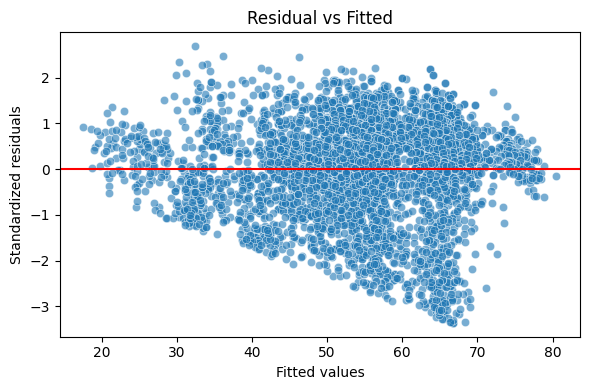

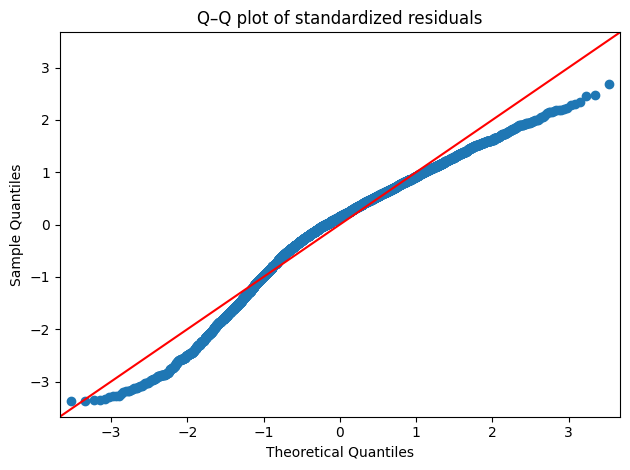

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# 以 forward_model 為例
resid = forward_model.get_influence().resid_studentized_internal
fitted = forward_model.fittedvalues

# 殘差 vs 預測值
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residual vs Fitted")
plt.tight_layout()
plt.show()

# Q-Q plot
sm.qqplot(resid, line='45', fit=True)
plt.title("Q–Q plot of standardized residuals")
plt.tight_layout()
plt.show()



📊 正態性檢定
Shapiro-Wilk test: W = 0.9630, p = 0.0000
❌ Reject H0 → 殘差不符合常態性


<Figure size 600x600 with 0 Axes>

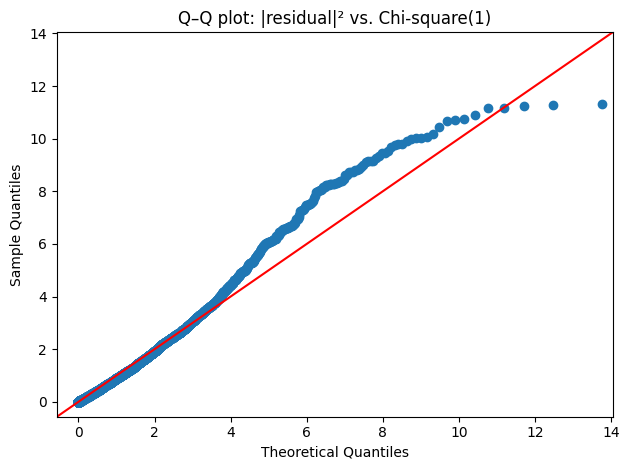


📊 異質變異檢定（目視）


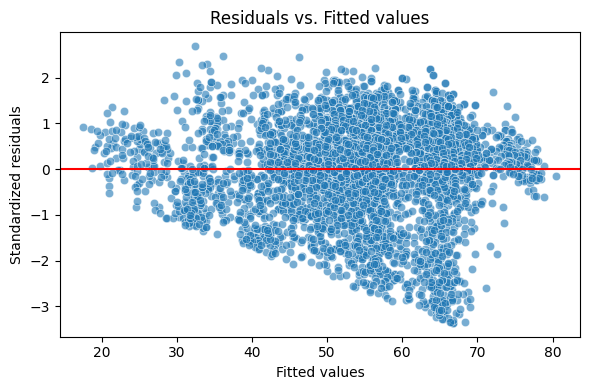

✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）

📊 獨立性檢定（Runs Test）
Runs Test: stat = -41.4269, p = 0.0000
❌ Reject H0 → 殘差可能不獨立


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.sandbox.stats.runs import runstest_1samp

# 1. 取出殘差與預測值
resid = forward_model.get_influence().resid_studentized_internal
fitted = forward_model.fittedvalues

# -----------------------------------------------------
# (a) 常態性檢定
print("\n📊 正態性檢定")

# 1.1 Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(resid)
print(f"Shapiro-Wilk test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("✅ Do not reject H0 → 殘差符合常態性")
else:
    print("❌ Reject H0 → 殘差不符合常態性")

# 1.2 Chi-square Q–Q plot
plt.figure(figsize=(6, 6))
abs_resid_squared = np.square(np.abs(resid))
sm.qqplot(abs_resid_squared, dist=stats.chi2, distargs=(1,), line='45')
plt.title("Q–Q plot: |residual|² vs. Chi-square(1)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# (b) 等變異性檢定（homoscedasticity）
print("\n📊 異質變異檢定（目視）")

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residuals vs. Fitted values")
plt.tight_layout()
plt.show()
print("✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）")

# -----------------------------------------------------
# (c) 獨立性檢定（runs test）
print("\n📊 獨立性檢定（Runs Test）")

runs_stat, runs_p = runstest_1samp(resid, cutoff='mean')
print(f"Runs Test: stat = {runs_stat:.4f}, p = {runs_p:.4f}")
if runs_p > 0.05:
    print("✅ Do not reject H0 → 殘差獨立")
else:
    print("❌ Reject H0 → 殘差可能不獨立")


### 5-2 Backward Regression

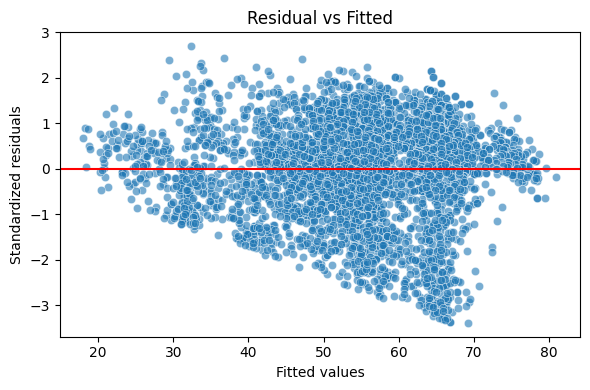

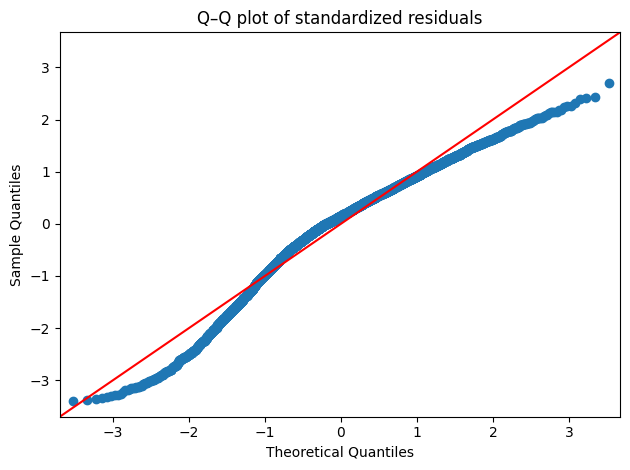

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# 以 backward_model 為例
resid = backward_model.get_influence().resid_studentized_internal
fitted = backward_model.fittedvalues

# 殘差 vs 預測值
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residual vs Fitted")
plt.tight_layout()
plt.show()

# Q-Q plot
sm.qqplot(resid, line='45', fit=True)
plt.title("Q–Q plot of standardized residuals")
plt.tight_layout()
plt.show()



📊 正態性檢定
Shapiro-Wilk test: W = 0.9628, p = 0.0000
❌ Reject H0 → 殘差不符合常態性


<Figure size 600x600 with 0 Axes>

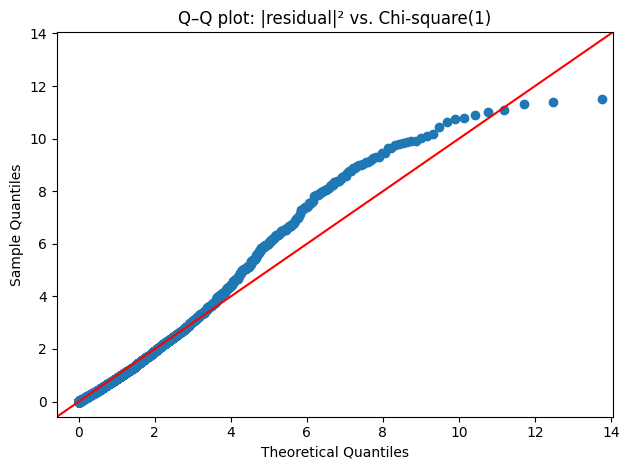


📊 異質變異檢定（目視）


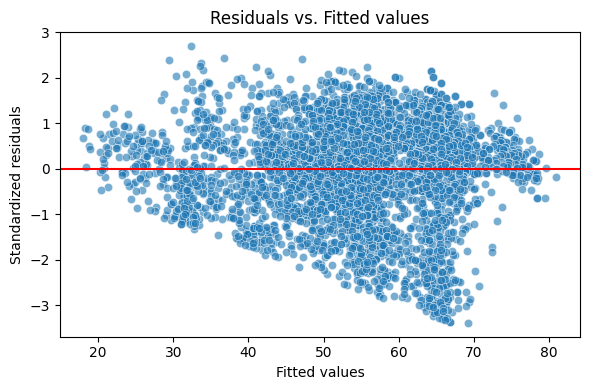

✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）

📊 獨立性檢定（Runs Test）
Runs Test: stat = -41.8681, p = 0.0000
❌ Reject H0 → 殘差可能不獨立


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.sandbox.stats.runs import runstest_1samp

# 1. 取出殘差與預測值
resid = backward_model.get_influence().resid_studentized_internal
fitted = backward_model.fittedvalues

# -----------------------------------------------------
# (a) 常態性檢定
print("\n📊 正態性檢定")

# 1.1 Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(resid)
print(f"Shapiro-Wilk test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("✅ Do not reject H0 → 殘差符合常態性")
else:
    print("❌ Reject H0 → 殘差不符合常態性")

# 1.2 Chi-square Q–Q plot
plt.figure(figsize=(6, 6))
abs_resid_squared = np.square(np.abs(resid))
sm.qqplot(abs_resid_squared, dist=stats.chi2, distargs=(1,), line='45')
plt.title("Q–Q plot: |residual|² vs. Chi-square(1)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# (b) 等變異性檢定（homoscedasticity）
print("\n📊 異質變異檢定（目視）")

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residuals vs. Fitted values")
plt.tight_layout()
plt.show()
print("✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）")

# -----------------------------------------------------
# (c) 獨立性檢定（runs test）
print("\n📊 獨立性檢定（Runs Test）")

runs_stat, runs_p = runstest_1samp(resid, cutoff='mean')
print(f"Runs Test: stat = {runs_stat:.4f}, p = {runs_p:.4f}")
if runs_p > 0.05:
    print("✅ Do not reject H0 → 殘差獨立")
else:
    print("❌ Reject H0 → 殘差可能不獨立")


# 6 歷史紀錄

初步 OLS 回歸模型分析（舊版，直接drop_cols）



In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors], genre_dummies], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     45.90
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:04:02   Log-Likelihood:                -20398.
No. Observations:                4830   AIC:                         4.089e+04
Df Residuals:                    4783   BIC:                         4.120e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

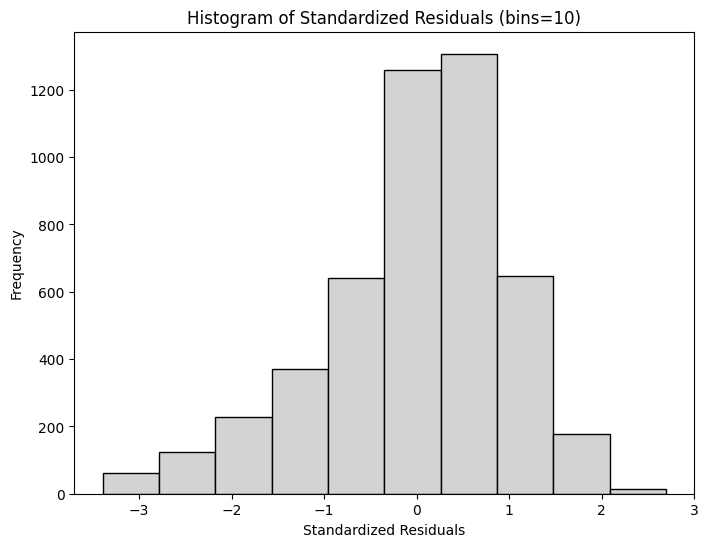

In [ ]:
import matplotlib.pyplot as plt

# 計算標準化殘差
influence = result.get_influence()
std_resid = influence.resid_studentized_internal

# 畫直方圖
plt.figure(figsize=(8, 6))
plt.hist(std_resid, bins=10, facecolor='lightgrey', edgecolor='black')
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Residuals (bins=10)')
plt.show()


## Backward Stepwise Regression
### 應變數為 track_popularity


In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

# print(data.shape)
# display(data['genre_ambient'].value_counts())
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

liveness is removed with p-value 0.9714.

genre_soul is removed with p-value 0.8937.

genre_mandopop is removed with p-value 0.7334.

genre_lofi is removed with p-value 0.7634.

genre_ambient is removed with p-value 0.6624.

duration_ms is removed with p-value 0.6585.

mode is removed with p-value 0.5505.

acousticness is removed with p-value 0.4246.

genre_latin is removed with p-value 0.3427.

genre_reggae is removed with p-value 0.3427.

genre_country is removed with p-value 0.2861.

tempo is removed with p-value 0.2366.

energy is removed with p-value 0.1674.

genre_jazz is removed with p-value 0.1677.

genre_electronic is removed with p-value 0.0753.

genre_indie is removed with p-value 0.0577.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.300
Method:                

### 🔍 殘差圖觀察重點
#### ✅ 水平橘線是殘差平均線（0）
正常情況下，點應大致分布在橘線上下，無明顯形狀。

#### ❌ 圖中問題
漏斗形（右側較窄）：

表示 異質變異（heteroscedasticity），預測值越大時殘差變異越小，這違反了迴歸分析的基本假設（殘差變異應該一致）。

意味著模型對於不同預測值的解釋力不一致，可能在中低預測值時失準。

非隨機分布：

正常的殘差圖應呈現無規律的雲狀分布，但這張圖呈現某種錐形，可能代表模型形式錯誤（例如少了非線性項）。

Text(0, 0.5, 'Standardized Residuals of track popularity')

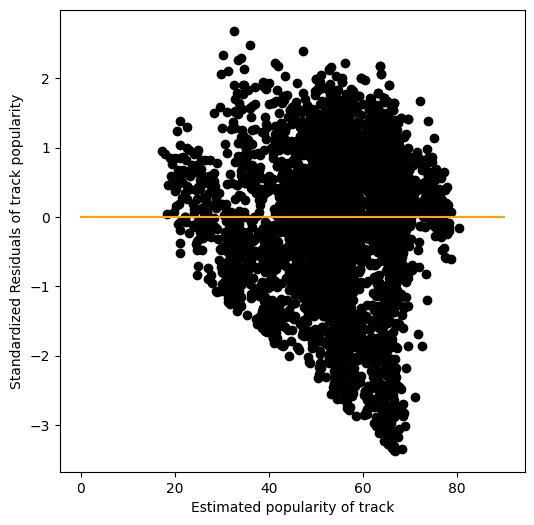

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

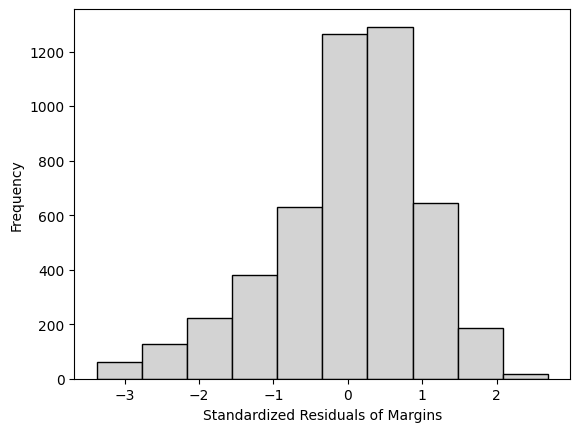

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

3.147856815344811e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -41.8393
p-value: 0.0000


## 三個交互作用項
這裡我們建立了三個交互作用項：

- `danceability_tempo`：舞蹈性 × 節奏（danceability × tempo），反映歌曲的舞蹈感與節奏快慢的綜合效果。
- `danceability_energy`：舞蹈性 × 能量（danceability × energy），結合舞蹈感與能量感，捕捉兩者同時高或低時的影響。
- `energy_valence`：能量 × 愉悅度（energy × valence），用來觀察高能量且愉悅的歌曲是否特別受歡迎。

這些交互作用項有助於模型捕捉變數間非線性的聯合效果，提升預測能力。

In [ ]:
# 先建立交互作用項
data_interact = data.copy()
# 1. danceability × tempo
data_interact['danceability_tempo'] = data_interact['danceability'] * data_interact['tempo']
# 2. danceability × energy
data_interact['danceability_energy'] = data_interact['danceability'] * data_interact['energy']
# 3. energy × valence
data_interact['energy_valence'] = data_interact['energy'] * data_interact['valence']

# 準備 response
response = 'track_popularity'

# 將所有 predictor（原本的 + 交互作用項）組合
predictors_interact = [col for col in data_interact.columns if col != response]

# 執行 backward selection
result_interact = backward_selection(data_interact[predictors_interact + [response]], response=response)
print(result_interact.summary())

liveness is removed with p-value 0.9624.

genre_soul is removed with p-value 0.8417.

genre_mandopop is removed with p-value 0.7422.

genre_ambient is removed with p-value 0.7773.

genre_lofi is removed with p-value 0.6791.

duration_ms is removed with p-value 0.6026.

mode is removed with p-value 0.4990.

genre_latin is removed with p-value 0.4078.

genre_reggae is removed with p-value 0.3707.

genre_country is removed with p-value 0.3557.

danceability_tempo is removed with p-value 0.3267.

acousticness is removed with p-value 0.2532.

energy_valence is removed with p-value 0.2474.

genre_jazz is removed with p-value 0.1813.

tempo is removed with p-value 0.1311.

genre_arabic is removed with p-value 0.0586.

genre_turkish is removed with p-value 0.0854.

genre_gospel is removed with p-value 0.0682.

valence is removed with p-value 0.0683.

danceability is removed with p-value 0.0540.

No variable is removed. Stop.
                            OLS Regression Results                   

Text(0, 0.5, 'Standardized Residuals of track popularity')

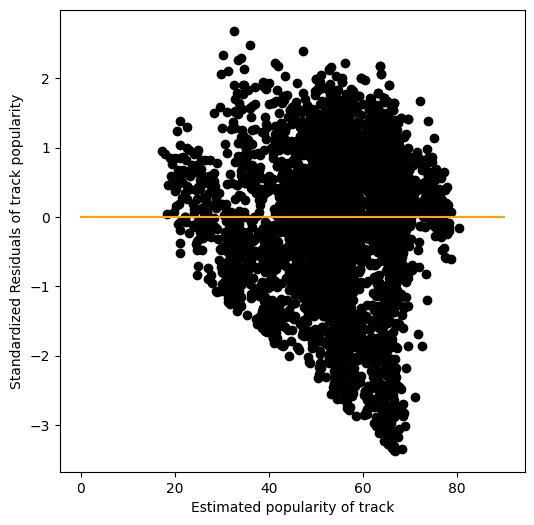

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

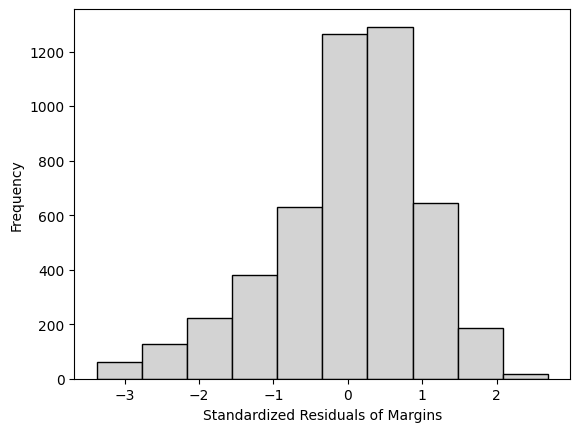

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

3.147856815344811e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -41.8393
p-value: 0.0000


## Backwards Stepwise Regression
### 應變數為 $ \log(\text{track\_popularity}) $

In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy

# 將 track_popularity 取 log（加 1 防止 log(0)）
df['track_popularity'] = np.log(df['track_popularity'])
predictors = [col for col in df.columns if col not in exclude_cols]


data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

# print(data.shape)
# display(data['genre_ambient'].value_counts())
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

genre_turkish is removed with p-value 0.9867.

genre_arabic is removed with p-value 0.9603.

liveness is removed with p-value 0.9158.

genre_gospel is removed with p-value 0.8633.

genre_country is removed with p-value 0.7872.

genre_latin is removed with p-value 0.6493.

mode is removed with p-value 0.3659.

genre_jazz is removed with p-value 0.3472.

tempo is removed with p-value 0.2499.

genre_mandopop is removed with p-value 0.2417.

duration_ms is removed with p-value 0.2172.

valence is removed with p-value 0.2273.

genre_soul is removed with p-value 0.2176.

genre_reggae is removed with p-value 0.1490.

acousticness is removed with p-value 0.1035.

energy is removed with p-value 0.1085.

genre_ambient is removed with p-value 0.0940.

speechiness is removed with p-value 0.0787.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.259
Model:          

Text(0, 0.5, 'Residuals of log(track popularity)')

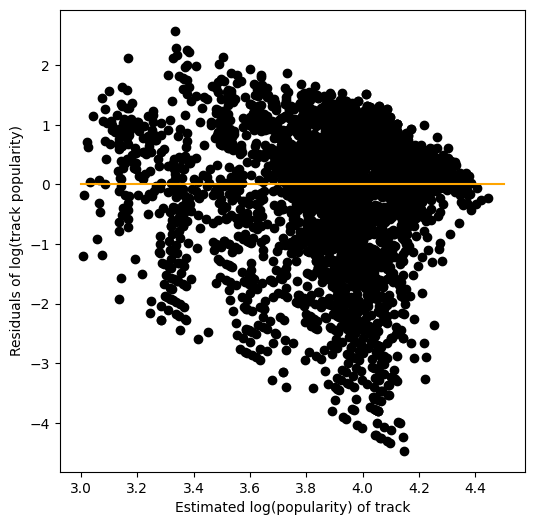

In [ ]:
influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([3, 4.5], [0, 0], color = 'orange')
plt.xlabel('Estimated log(popularity) of track')
plt.ylabel('Residuals of log(track popularity)')


Text(0, 0.5, 'Frequency')

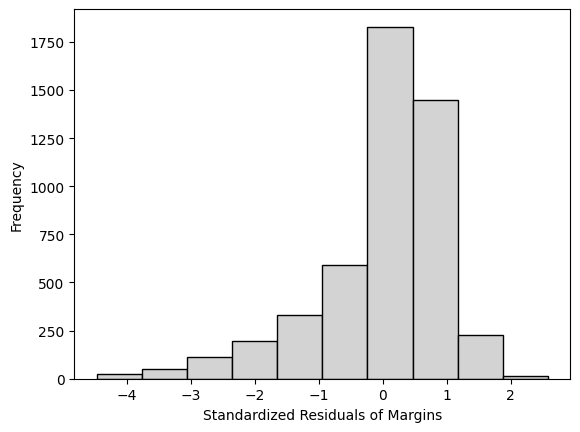

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

2.6682311789197867e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.8934
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -39.0126
p-value: 0.0000


## Genre Pop ols


In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'pop' ]  # 去除 track_popularity <= 0 的資料

exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     7.327
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.86e-12
Time:                        01:23:37   Log-Likelihood:                -2342.7
No. Observations:                 515   AIC:                             4711.
Df Residuals:                     502   BIC:                             4767.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           23.7547     14.016  

Text(0, 0.5, 'Standardized Residuals of track popularity')

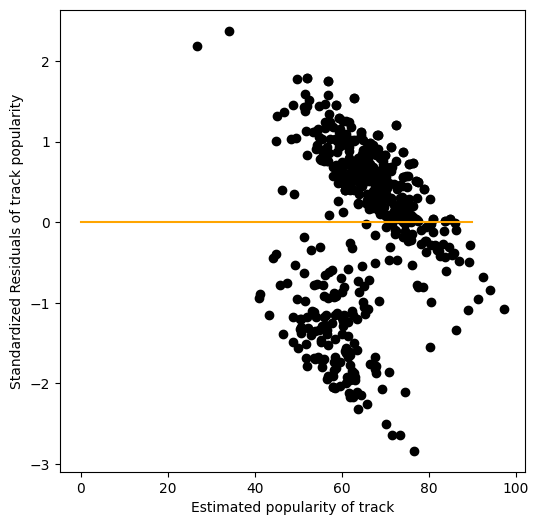

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

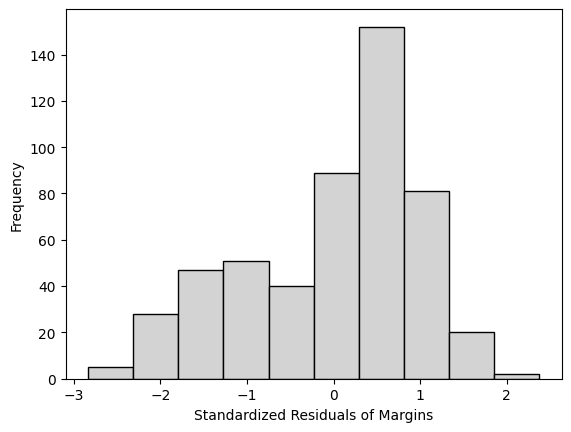

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.0006916619996732638

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9434
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -14.7655
p-value: 0.0000


## Backwards Stepwise Regression
### Genre Pop

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'pop' ]  # 去除 track_popularity <= 0 的資料


# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

liveness is removed with p-value 0.9074.

danceability is removed with p-value 0.8329.

tempo is removed with p-value 0.6245.

mode is removed with p-value 0.5666.

speechiness is removed with p-value 0.5220.

energy is removed with p-value 0.1524.

instrumentalness is removed with p-value 0.2232.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     16.76
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.44e-15
Time:                        01:23:37   Log-Likelihood:                -2345.0
No. Observations:                 515   AIC:                             4702.
Df Residuals:                     509   BIC:                             4728.
Df Model:                           5 

Text(0, 0.5, 'Standardized Residuals of track popularity')

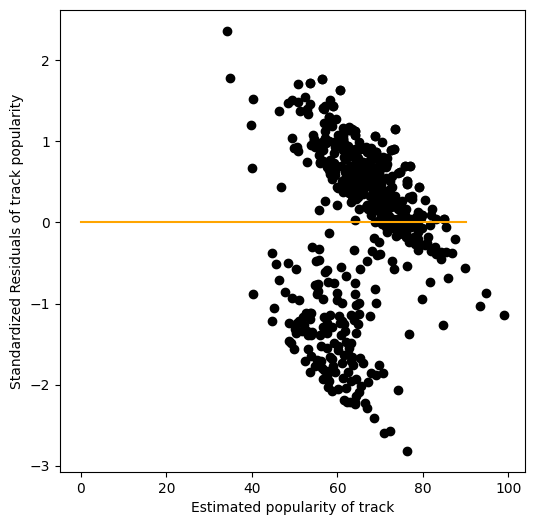

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

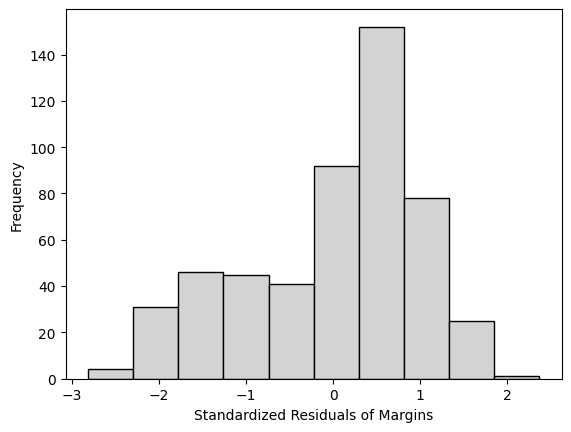

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.000474908705546643

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9397
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -14.7497
p-value: 0.0000


## Genre 的曲數 > 100 做 ols

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
# 篩選 playlist_genre 數量大於 30 的資料
genre_counts = df['playlist_genre'].value_counts()
df = df[df['playlist_genre'].isin(genre_counts[genre_counts > 100].index)]


print(df['playlist_genre'].value_counts())
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True)

exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors], genre_dummies], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
electronic    589
pop           515
latin         425
hiphop        395
ambient       359
rock          345
lofi          299
world         228
arabic        208
brazilian     148
jazz          146
gaming        133
classical     121
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     64.65
Date:                Wed, 28 May 2025   Prob (F-statistic):          1.31e-261
Time:                        01:23:38   Log-Likelihood:                -16681.
No. Observations:                3910   AIC:                         3.341e+04
Df Residuals:                    3885   BIC:                         3.357e+04
Df Model:                          24                                         
Covariance Typ

Text(0, 0.5, 'Standardized Residuals of track popularity')

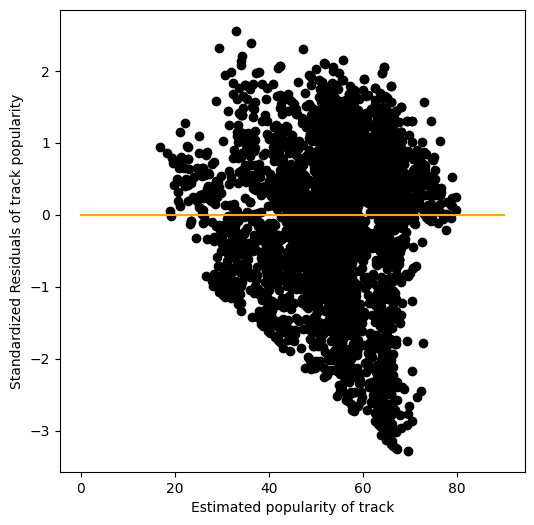

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

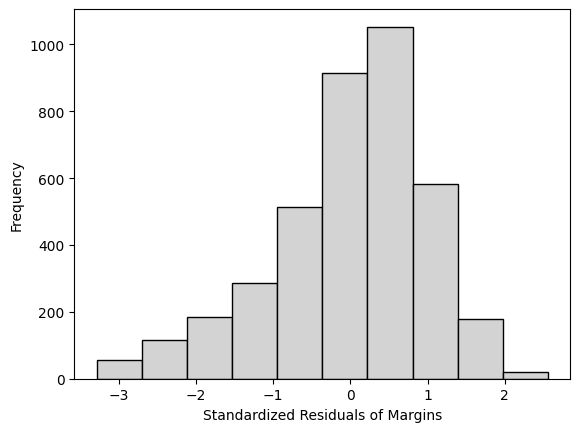

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

-2.4757540208839274e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9623
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -38.9829
p-value: 0.0000


## Backwards Stepwise Regression
### 應變數為 $ \text{track\_popularity} $

#### Genre 的曲數 > 100

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
# 篩選 playlist_genre 數量大於 100 的資料
genre_counts = df['playlist_genre'].value_counts()
df = df[df['playlist_genre'].isin(genre_counts[genre_counts > 100].index)]


print(df['playlist_genre'].value_counts())

genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
electronic    589
pop           515
latin         425
hiphop        395
ambient       359
rock          345
lofi          299
world         228
arabic        208
brazilian     148
jazz          146
gaming        133
classical     121
Name: count, dtype: int64
liveness is removed with p-value 0.8413.

genre_lofi is removed with p-value 0.8191.

mode is removed with p-value 0.6166.

genre_latin is removed with p-value 0.5988.

acousticness is removed with p-value 0.4259.

tempo is removed with p-value 0.2333.

energy is removed with p-value 0.1439.

genre_electronic is removed with p-value 0.2047.

loudness is removed with p-value 0.0840.

genre_jazz is removed with p-value 0.1002.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Leas

Text(0, 0.5, 'Standardized Residuals of track popularity')

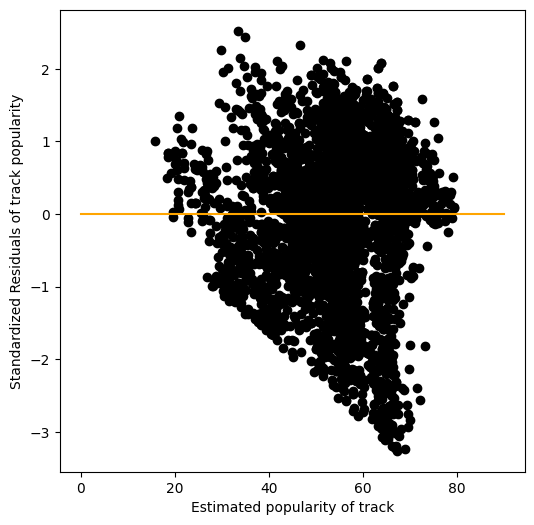

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

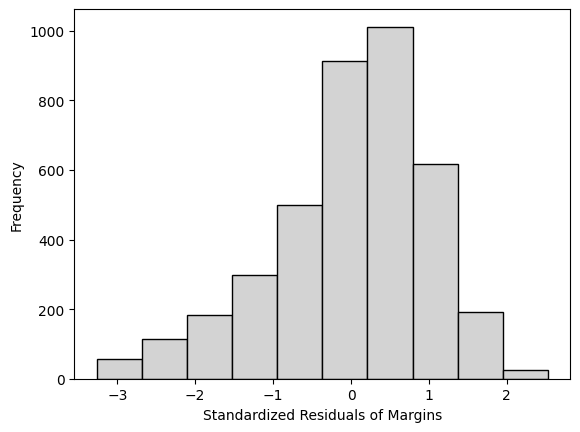

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

-3.323057807008232e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -38.4478
p-value: 0.0000


## Genre Gaming


In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'gaming' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
gaming    133
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     20.61
Date:                Wed, 28 May 2025   Prob (F-statistic):           8.35e-24
Time:                        01:23:43   Log-Likelihood:                -502.42
No. Observations:                 133   AIC:                             1031.
Df Residuals:                     120   BIC:                             1068.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

Text(0, 0.5, 'Standardized Residuals of track popularity')

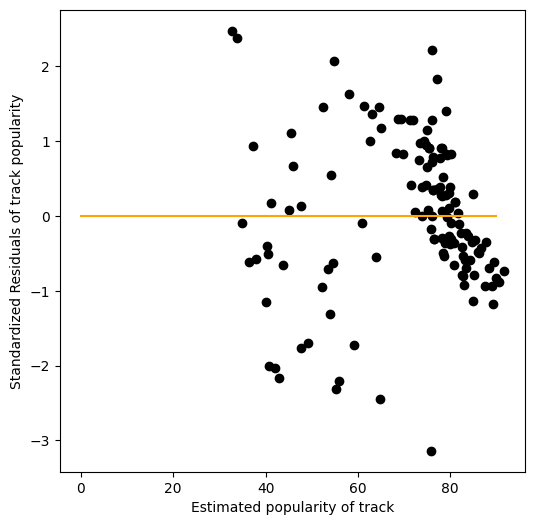

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

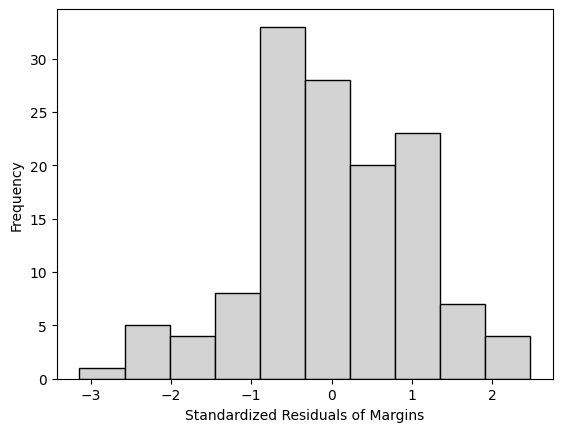

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.006573797435076452

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9852
p-value: 0.1590


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -3.5574
p-value: 0.0004


## Backwards Stepwise Regression
### Genre Gaming


In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'gaming' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
gaming    133
Name: count, dtype: int64
duration_ms is removed with p-value 0.9617.

speechiness is removed with p-value 0.9348.

energy is removed with p-value 0.8690.

mode is removed with p-value 0.8230.

key is removed with p-value 0.4682.

liveness is removed with p-value 0.4174.

valence is removed with p-value 0.3164.

acousticness is removed with p-value 0.3163.

loudness is removed with p-value 0.4040.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     84.53
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.62e-30
Time:                        01:23:43   Log-Likelihood:                -504.53
No. Observations:                 133   AIC:                     

Text(0, 0.5, 'Standardized Residuals of track popularity')

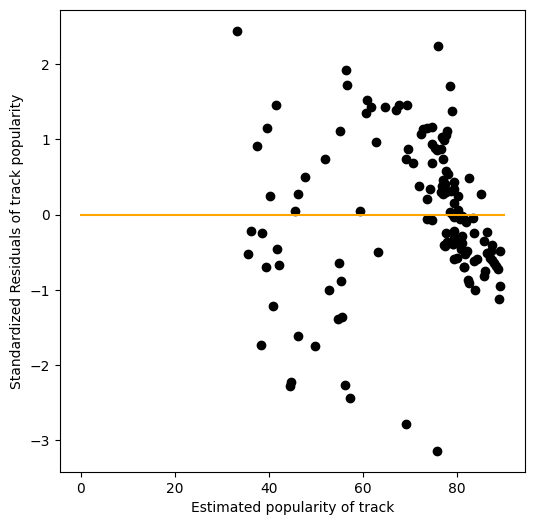

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

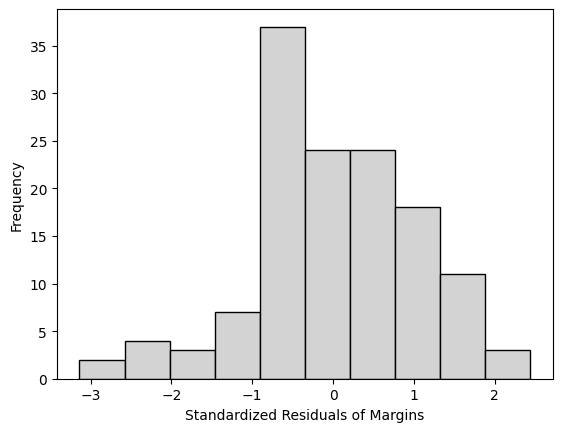

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.0016112702176818733

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9796
p-value: 0.0429


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -3.1974
p-value: 0.0014


### ROCK

In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'rock' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
rock    345
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.661
Date:                Wed, 28 May 2025   Prob (F-statistic):             0.0741
Time:                        01:27:11   Log-Likelihood:                -1421.5
No. Observations:                 345   AIC:                             2869.
Df Residuals:                     332   BIC:                             2919.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

### 後面來?

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'rock' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
rock    345
Name: count, dtype: int64
danceability is removed with p-value 0.7259.

duration_ms is removed with p-value 0.6218.

liveness is removed with p-value 0.4469.

instrumentalness is removed with p-value 0.3497.

speechiness is removed with p-value 0.3422.

acousticness is removed with p-value 0.2759.

tempo is removed with p-value 0.2225.

mode is removed with p-value 0.1342.

key is removed with p-value 0.1951.

energy is removed with p-value 0.1038.

loudness is removed with p-value 0.3696.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     7.113
Date:                Wed, 28 May 2025   Prob (F-statistic):            0.00802
Time:                        01:27:13   Log-Likeliho

### Hipop

In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'hiphop' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
hiphop    395
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     8.349
Date:                Wed, 28 May 2025   Prob (F-statistic):           4.70e-14
Time:                        01:27:15   Log-Likelihood:                -1646.1
No. Observations:                 395   AIC:                             3318.
Df Residuals:                     382   BIC:                             3370.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

### backward hipop

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'hiphop' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
hiphop    395
Name: count, dtype: int64
mode is removed with p-value 0.9771.

tempo is removed with p-value 0.8882.

danceability is removed with p-value 0.7968.

acousticness is removed with p-value 0.4265.

liveness is removed with p-value 0.1807.

key is removed with p-value 0.0581.

valence is removed with p-value 0.0662.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     18.03
Date:                Wed, 28 May 2025   Prob (F-statistic):           4.33e-16
Time:                        01:27:17   Log-Likelihood:                -1650.9
No. Observations:                 395   AIC:                             3314.
Df Residuals:                     389   BIC:                             

Text(0, 0.5, 'Standardized Residuals of track popularity')

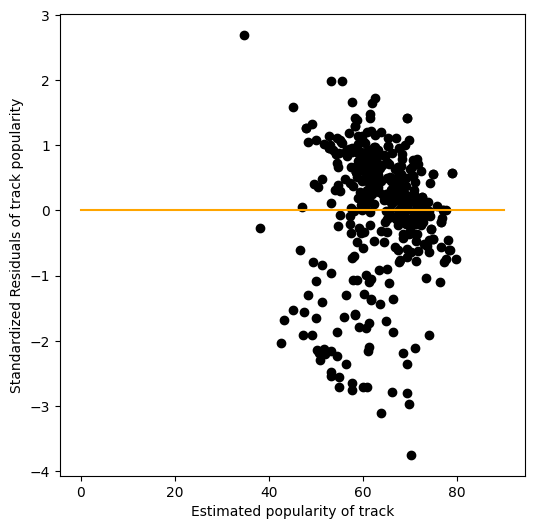

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

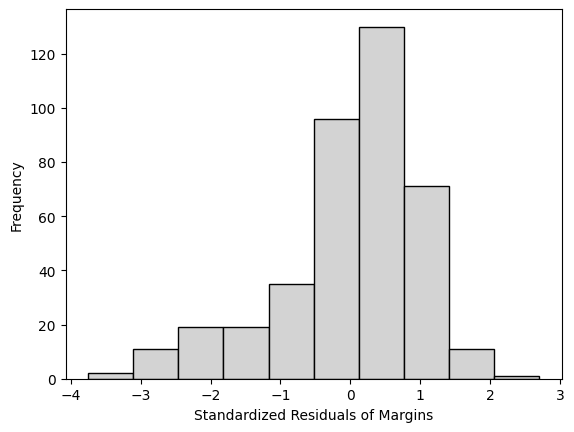

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')